In [ ]:
# !pip yfinance -q

ERROR: unknown command "yfinance"


In [1]:
import yfinance as yf
import random 
import numpy as np
import pandas as pd
import random
import numpy as np
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
import os
import gc
from matplotlib import pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%matplotlib inline


### **Data preprocessing**

In [66]:
CONTEXT=30
def technical_indicators(df):
  df_close=df['Close']
  df_close=pd.DataFrame(df_close, columns=['Close'])
  df11=df_close.reset_index()
  

  df11['change'] = df11['Close'].diff()
  # df['change']=df11['change']
  #SMA
  df['SMA10'] = df11['Close'].rolling(10).mean()
  
  # df11['gain'] = df11.change.mask(df11.change < 0, 0.0)
  # df11['loss'] = -df11.change.mask(df11.change > 0, -0.0)
  def rma(x, n):
      """Running moving average"""
      a = np.full_like(x, np.nan)
      a[n] = x[1:n+1].mean()
      for i in range(n+1, len(x)):
          a[i] = (a[i-1] * (n - 1) + x[i]) / n
      return a

  # df11['avg_gain'] = rma(df11.gain.to_numpy(), 14)        
  # df11['avg_loss'] = rma(df11.loss.to_numpy(), 14)     

  #RSI
  # df11['rs'] = df11.avg_gain / df11.avg_loss
  # df11['rsi'] = 100 - (100 / (1 + df11.rs))

  #disparity index
  ma = df['Close'].rolling(14).mean()
  df['disparity'] = ((df['Close'] - ma) / ma) * 100
  
  
  df11.drop(columns=['Close','index','change'], inplace=True)
  # print(df11.columns)
  df_cat=pd.concat([df, df11], axis=1)
  df_cat.fillna(method='bfill', axis=0, inplace=True)
  df_cat.fillna(method='ffill', axis=0, inplace=True)
  return df_cat
STOCK_csv = pd.read_csv("AAPL.csv")
STOCK=technical_indicators(STOCK_csv).drop(columns=['Date','Adj Close','Open',"High","Low",'Volume','SMA10','disparity'])
print(STOCK.columns)
# STOCK=STOCK.reset_index()
STOCK

Index(['Close'], dtype='object')


,Close
0,44.560001
1,44.459999
2,43.200001
3,41.430000
4,41.310001
...,...
1253,162.029999
1254,160.800003
1255,160.100006
1256,165.559998


In [67]:
dataset_standard=np.array(STOCK)
stock=dataset_standard
stock

array([[ 44.560001],
       [ 44.459999],
       [ 43.200001],
       ...,
       [160.100006],
       [165.559998],
       [165.210007]])

<ipython-input-68-755cfdffd617>:7: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("AAPL",xy=(0,60),textcoords='offset points', fontsize=20)


Text(0, 60, 'AAPL')

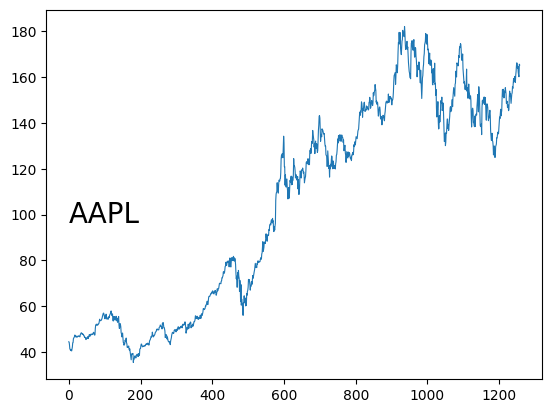

In [68]:
# stock_ma=np.array(dataset_standard[:3])   #MA, 6
# stock_delta=np.array(dataset_standard[:,2])   #change 5
stock_price=np.array(dataset_standard[:,0])   #Price   3
plt.plot(stock_price, linewidth=0.8)
# plt.plot(stock_ma, linewidth=0.8, color='orange')
# plt.plot(stock_delta, linewidth=0.8, color='b', alpha=0.2)
plt.annotate("AAPL",xy=(0,60),textcoords='offset points', fontsize=20)


### **Use Transformer Generated Prediction**

In [69]:
stock.shape
used_length=int(len(stock_price)*0.55)
stock_price=stock_price[used_length:]
stock=stock[used_length:]

# plt.plot(stock_price)
print(len(stock), len(stock_price))

567 567


In [70]:
stock.shape

(567, 1)

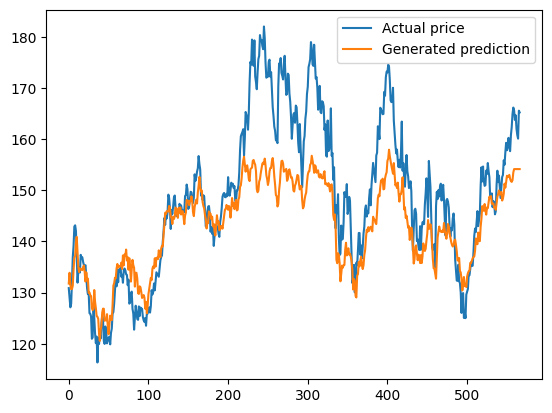

In [71]:
transformer_pred = np.array(pd.read_csv("AAPL_pred.csv" ))[:,-1]
transformer_pred = transformer_pred[used_length:]
transformer_pred.shape
plt.plot(stock_price,label='Actual price')
plt.plot(transformer_pred, label='Generated prediction')
plt.legend()

### **Create Trading Game**

In [49]:
TRANSACTION=0.0001
CONTEXT=30
LOOK_FORWARD=7
class GameAI:  # the AI go through the stock, look at a window of prices, and try to make actions at each timestep
    def __init__(self, w=CONTEXT):
        self.w = w #window size
        self.reset() 

    def reset(self):
        # restart game, initialize game state
        self.money=1000000 
        self.positions=10000   # shares holding

        self.today=CONTEXT-LOOK_FORWARD-1      #30- 7-1   =22           0~22,      22 ,     23~29
        self.inital_property=self.positions*stock_price[self.today]+self.money  #initial total investment = 10,000 shares + cash

        
        self.window_right=self.w-1   #29
        self.window_left=0         
        
        self.today_price = stock_price[self.today]        
        self.window = stock_price[ self.window_left:self.today+1] #price    0~14
        # self.window1= stock_delta[ 0: self.w] #delta
        self.window_all=stock[ self.window_left:self.today+1]  #8 features
        
        self.previous_reward=0  #to store and plot the mean reward during each game to see if improves
        self.yesterday_property= self.inital_property
        self.profit=0 
        
        
        self.money_record=[self.money]*CONTEXT
        self.positions_record=[self.positions]*CONTEXT

        self.money_window=self.money_record[self.window_left:self.today+1]
        self.positions_window=self.positions_record[self.window_left:self.today+1]

        self.window_pred=transformer_pred[self.today+1: self.window_right+1]   # transformer predictions

        
    def play_step(self, action):
        self.yesterday_price=self.money
        self.yesterday_property=(self.money + self.today_price*self.positions )

        # 2. make a move, compute money, update positions
        self.money=self.money - self.today_price * action
         #update positions
        self.positions += action     #shares in hand

        self.money_record.append(self.money)
        self.positions_record.append(self.positions)

        self.today += 1  # update the head and window
        self.today_price=stock_price[self.today] 
        #move window forward
        self.window_left += 1 
        self.window_right += 1 

        self.window=stock_price[self.window_left:self.today+1]       #past prices

        self.window_all=stock[self.window_left:self.today+1]         #past indicators

        self.window_pred=transformer_pred[self.today+1: self.window_right+1]   # transformer predictions

        self.right_max =  max( self.window_pred )

        # self.left_mean_delta =  np.mean( stock_delta[self.today-5:self.today]  )
        # self.right_mean_delta =  np.mean( stock_delta[self.today:self.today+5]  )

        # self.action_window
        
        self.money_window=self.money_record[self.window_left:self.today+1]
        self.positions_window=self.positions_record[self.window_left:self.today+1]


        # 3. check if game over
        game_over = False

        if self.is_collision():
            
            game_over = True
            reward = (self.money + self.today_price*self.positions ) - self.yesterday_property      -  abs(action)*TRANSACTION
            # reward/=10
            reward = reward+ 1*(self.right_max-self.today_price) * action
            #calculate profit at the end of each game
            self.profit= ((self.money + self.today_price*self.positions )-self.inital_property) /self.inital_property  #profitability at the end of each game
            
            return reward, game_over

        #the reward function will be defined as the difference between the portfolio value 
        #at the end of the time step and the portfolio value at the beginning of the time step.

        reward= (self.money + self.today_price*self.positions ) - self.yesterday_property            -  abs(action)*TRANSACTION
        # print("daily",reward)
        # reward/=10
        
        # print("curriculum",0.1*(self.right_mean-self.left_mean)*action 
        reward= reward+1*(self.right_max-self.today_price) * action 
                #curriculum1: if right mean > left mean, and you buy today, then reward the agent, vice versa for sell
                
        return reward, game_over


    def is_collision(self):
        # hits boundary 
        if self.window_right>len(stock_price)-2:
            return 1
        return 0


### **Define State, Action Space**

In [50]:
STATE_SIZE=2+ stock.shape[-1] #prices in window + position and money in hand
print("State size:", STATE_SIZE)  # state size is of length CONTEXT  * customized dimensions 
ACTION_SPACE=np.arange(-5000,5001,500).tolist()    #actions
ACTION_SIZE=len(ACTION_SPACE)
print("Action_size:", ACTION_SIZE)
print("Action_space:", ACTION_SPACE)

State size: 3
Action_size: 21
Action_space: [-5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]


### **Build Double Q leaning**

In [51]:
MAX_MEMORY = 10000 # record 5000 state, action, reward, next_state, done tuples
BATCH_SIZE = 128
criterion = nn.SmoothL1Loss()
LR = 0.001
GAMMA=0.999
TAU=0.5
Q_UPDATE_FREQ=20
#Qnet for a given state action pair gives value
class QNetwork(nn.Module):
    def __init__(self, state_size=STATE_SIZE, action_size=ACTION_SIZE, hidden_size=256):
        super(QNetwork, self).__init__()
        self.embedding=nn.Sequential(
        nn.Conv1d(state_size, hidden_size, kernel_size=3, stride=1, padding=1, bias=False ),
        nn.GELU(),
        nn.BatchNorm1d(hidden_size),

        nn.Conv1d(hidden_size, hidden_size, kernel_size=3, stride=1, padding=1, bias=False ),
        nn.BatchNorm1d(hidden_size),
        )

        self.fc=nn.Sequential(
            
        nn.Linear(hidden_size, hidden_size),
        nn.GELU(),
        nn.Linear(hidden_size, hidden_size),
        nn.GELU(),
        nn.Linear(hidden_size, hidden_size),
        nn.GELU()
        )
        self.Linear_out=nn.Linear(hidden_size * CONTEXT, action_size)
    def forward(self, x):

        out=self.embedding(torch.transpose(x,1,2))
        out=self.fc(torch.transpose(out,1,2))

        out=self.Linear_out(    out.flatten(1)   )
        return out

class DoubleDQN:
    def __init__(self, state_size=STATE_SIZE, action_size=ACTION_SIZE, hidden_size=256, lr=LR, tau=TAU,
                 q_update_freq=Q_UPDATE_FREQ, 
                 ):
        self.q_net = QNetwork(state_size, action_size, hidden_size)
        self.target_q_net = QNetwork(state_size, action_size, hidden_size)
        self.target_q_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.tau = tau
        self.total_steps=0
        self.q_update_freq=q_update_freq

    def soft_update(self):
        if self.total_steps % self.q_update_freq==0:
          for target_param, param in zip(self.target_q_net.parameters(), self.q_net.parameters()):
              target_param.data.copy_(self.tau * param.data + (1-self.tau) * target_param.data)

    def train_step(self, state, action, reward, next_state, done):
      self.total_steps += 1

      states_tensor = torch.FloatTensor(state)  #b * state_size 
      actions_tensor = torch.LongTensor(action)  #b 
      rewards_tensor = torch.FloatTensor(reward) #b 
      next_states_tensor = torch.FloatTensor(next_state)  #b * state_size 
      dones_tensor = torch.BoolTensor(done)  #b

      with torch.no_grad():
        q_next=self.target_q_net(next_states_tensor)
        max_q_next,_ = torch.max(q_next, dim=1)
        q_target = rewards_tensor + GAMMA * max_q_next * (~dones_tensor)

      q_pred = self.q_net(states_tensor)
      actions_index=[]
      for b in range(BATCH_SIZE):
        #print(actions_tensor[b])
        actions_index.append(ACTION_SPACE.index(actions_tensor[b]))
      actions_index=torch.tensor(actions_index, dtype=torch.int64)

      q_values_pred_selected = q_pred.gather(1, actions_index.unsqueeze(1)).squeeze(1)

      loss = criterion(q_values_pred_selected, q_target) /(BATCH_SIZE*1e+3)

      self.optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 1e+8)
      self.optimizer.step()

      self.soft_update()

      return loss.item()

### **Create Agent that play the game and sample experiences to train**

In [52]:
class Agent:
    def __init__(self):
        self.n_games = 0
        self.trainer = DoubleDQN() 
        self.memory = deque(maxlen=MAX_MEMORY) # a collection of past experiences 

    def get_state(self, game):

        window_all=np.array(game.window_all )
        money_window=(np.array(game.money_window)/10000).reshape(-1,1)   #your money
        positions_window=(np.array(game.positions_window)/100).reshape(-1,1)
        
        pred_window = np.array(game.window_pred ).reshape(-1,1)

        assert(game.money>=0.0)
        assert(game.positions>=0.0)

        state= np.concatenate( [positions_window, money_window, window_all], axis=-1  ) # 24, 5

        pred_window_repeat=np.repeat(pred_window, state.shape[-1], axis=-1)   #6, 5

        state=np.concatenate([state, pred_window_repeat], axis=0)   #30, 5

        return state

    def remember(self, state, action, reward, next_state, done):
        #state=(state- np.mean(state,axis=0))/np.std(state,axis=0) #normalize
        # reward/=100
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached


    def train_batch_experience(self):

        if len(self.memory) >= BATCH_SIZE:
            batch_sample = random.sample(self.memory, BATCH_SIZE)  # list of tuples
            #pass in batch to train
            states, actions, rewards, next_states, dones = zip(*batch_sample)
            # print("states", states.shape)
            loss=self.trainer.train_step(states, actions, rewards, next_states, dones)
            return loss
            
    def get_action(self, state, game):    # e p s i l o n greedy---------------------------------------------------------------------------------
        #80% possibility of taking random action. decrease in time
        self.epsilon = 80 - self.n_games//20   #20 games reduce 1% chance of choosing action other than the best action
        if self.epsilon<5:
          self.epsilon=5 #not allowing below 5%  randomness
        position=game.positions
        money=game.money

        today_price=game.today_price

        final_move=0.
        #explore random actions
        if random.randint(0, 100) < max(self.epsilon,0) or (len(self.memory) <= BATCH_SIZE):
            actions=np.array(ACTION_SPACE)
            final_move=np.random.choice(actions)  
            #cannot buy more than the money you have, find closest value in the action space
            if final_move>0 and final_move*today_price >= money:
              for a in reversed(ACTION_SPACE): # find action that doesn't use up all your money in action space
                if a>=0 and a*today_price < money:
                  return a
              
            if final_move<0 and final_move<-position:    
              for a in ACTION_SPACE:  #find action that doesn't sell all your shares in action space
                if a<=0 and a+position>=0:
                  return a

        #take max q action
        else:
            state_input = torch.tensor(state, dtype=torch.float).unsqueeze(0)
            # print("QpredstateL",state_input.shape)
            Q_pred= self.trainer.q_net(state_input)
            move = torch.argmax(Q_pred).item() # 
            #allowable=np.clip(move, -position, money//today_price)    
            final_move=ACTION_SPACE[move]
            
            #cannot buy more than the money you have, find closest value in the action space
            if final_move>0 and final_move*today_price > money:
              for a in reversed(ACTION_SPACE):
                if a>=0 and a*today_price< money: #find action that doesn't use up all your money in action space
                  # print("action", a, today_price, money)
                  return a
            
            if final_move<0 and final_move<-position:   
              for a in ACTION_SPACE: #find action that doesn't sell all your shares in action space
                if a<=0 and a+position>=0:
                  return a

        if final_move>0 and final_move*today_price >= money:
          # print("action", a, today_price, money)
          return 0.
        if final_move<0 and final_move<-position:
          return 0.

        return final_move

actions=[]
plot_profit=[]
plot_reward=[]
plot_loss=[]
agent = Agent()
def train():
    rewards = []
    record = 0
    game = GameAI()
    epoch=800000 #a very large number just to keep the game running
    optimizer=agent.trainer.optimizer
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=stock_price.shape[0]*3, gamma=0.99)
    for i in tqdm( range(1,epoch+1) ):
        
        curr_lr = float(optimizer.param_groups[0]['lr'])
        state_old = agent.get_state(game)
        action = agent.get_action(state_old, game)
        actions.append(action)
        
        reward, done= game.play_step(action)
#--------------------------------------------------------------------------------------------------------------------
        state_new = agent.get_state(game)
        # memory stored for replay
        agent.remember(state_old, action, reward, state_new, done)
        #loss=agent.train_single_experience(state_old, action, reward, state_new, done)

          
        rewards.append(reward)
        profit=game.profit

        if done:
            mean_reward=np.mean(rewards)
            plot_reward.append(mean_reward)
            rewards=[]
            # train minibatch
            loss=agent.train_batch_experience()
            plot_loss.append(loss)
            game.reset()
            agent.n_games += 1
            
            if profit > record:
                record = profit
               # agent.model.save()


            print('Game', agent.n_games,"mean Reward", round(mean_reward,2), 'Profit', round(profit*100,2) ,'Record:', round(record*100,2), "eps",agent.epsilon,"lr",round(curr_lr,6), "loss", round(loss,6))

            plot_profit.append(profit)
        scheduler.step()


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# PATH = "/content/drive/MyDrive/checkpoint01"
# torch.save(agent.trainer.q_net.state_dict(), PATH)

In [53]:
gc.collect()
torch.cuda.empty_cache()

### **Train and see Rewards and Profits**

In [54]:
train()
#profit is the percentage of cumulated money through the money over money that I had in hand before the game
#mean reward is the average daily dollar returns in each game

  0%|          | 755/800000 [00:00<12:44, 1045.52it/s]

Game 1 mean Reward 667.73 Profit 18.19 Record: 18.19 eps 80 lr 0.001 loss 0.227062


  0%|          | 1368/800000 [00:01<13:11, 1008.77it/s]

Game 2 mean Reward 1184.35 Profit 16.33 Record: 18.19 eps 80 lr 0.001 loss 0.231166


  0%|          | 1959/800000 [00:02<13:57, 952.44it/s]

Game 3 mean Reward 809.92 Profit 14.36 Record: 18.19 eps 80 lr 0.001 loss 0.217782


  0%|          | 2358/800000 [00:02<14:53, 893.04it/s]

Game 4 mean Reward -839.36 Profit -0.4 Record: 18.19 eps 80 lr 0.00099 loss 0.213898


  0%|          | 2951/800000 [00:03<14:08, 939.09it/s]

Game 5 mean Reward 2044.39 Profit 35.73 Record: 35.73 eps 80 lr 0.00099 loss 0.221316


  0%|          | 3574/800000 [00:03<13:40, 970.98it/s]

Game 6 mean Reward 343.92 Profit 11.6 Record: 35.73 eps 80 lr 0.00099 loss 0.215556


  0%|          | 3960/800000 [00:04<14:45, 898.76it/s]

Game 7 mean Reward 776.91 Profit 23.67 Record: 35.73 eps 80 lr 0.00098 loss 0.212583


  1%|          | 4536/800000 [00:04<13:59, 947.18it/s]

Game 8 mean Reward 295.65 Profit 9.39 Record: 35.73 eps 80 lr 0.00098 loss 0.210633


  1%|          | 5072/800000 [00:05<14:24, 919.78it/s]

Game 9 mean Reward -376.27 Profit -4.38 Record: 35.73 eps 80 lr 0.00098 loss 0.233322


  1%|          | 5654/800000 [00:06<13:49, 957.82it/s]

Game 10 mean Reward -801.24 Profit -6.42 Record: 35.73 eps 80 lr 0.00097 loss 0.1739


  1%|          | 6274/800000 [00:06<13:24, 987.07it/s]

Game 11 mean Reward 85.96 Profit 6.95 Record: 35.73 eps 80 lr 0.00097 loss 0.207395


  1%|          | 6639/800000 [00:07<14:50, 890.50it/s]

Game 12 mean Reward 289.06 Profit 3.36 Record: 35.73 eps 80 lr 0.00097 loss 0.232637


  1%|          | 7222/800000 [00:07<14:14, 927.36it/s]

Game 13 mean Reward 1257.51 Profit 21.73 Record: 35.73 eps 80 lr 0.000961 loss 0.217467


  1%|          | 7660/800000 [00:08<19:14, 686.40it/s]

Game 14 mean Reward -929.98 Profit -2.46 Record: 35.73 eps 80 lr 0.000961 loss 0.199832


  1%|          | 8202/800000 [00:09<24:52, 530.40it/s]

Game 15 mean Reward -969.05 Profit -11.03 Record: 35.73 eps 80 lr 0.000961 loss 0.19359


  1%|          | 8728/800000 [00:10<25:59, 507.34it/s]

Game 16 mean Reward 1031.18 Profit 27.02 Record: 35.73 eps 80 lr 0.000951 loss 0.206268


  1%|          | 9421/800000 [00:11<19:02, 691.71it/s]

Game 17 mean Reward 476.13 Profit 10.27 Record: 35.73 eps 80 lr 0.000951 loss 0.183941


  1%|          | 9999/800000 [00:12<15:23, 855.70it/s]

Game 18 mean Reward -831.94 Profit -5.8 Record: 35.73 eps 80 lr 0.000951 loss 0.1815


  1%|▏         | 10563/800000 [00:12<13:57, 942.79it/s]

Game 19 mean Reward 1073.92 Profit 21.76 Record: 35.73 eps 80 lr 0.000951 loss 0.17419


  1%|▏         | 11077/800000 [00:13<14:50, 885.44it/s]

Game 20 mean Reward 1276.24 Profit 16.74 Record: 35.73 eps 80 lr 0.000941 loss 0.146293


  1%|▏         | 11585/800000 [00:14<15:28, 849.20it/s]

Game 21 mean Reward 406.55 Profit 4.91 Record: 35.73 eps 79 lr 0.000941 loss 0.211276


  2%|▏         | 12172/800000 [00:14<13:58, 939.41it/s]

Game 22 mean Reward -1019.21 Profit -15.65 Record: 35.73 eps 79 lr 0.000941 loss 0.177431


  2%|▏         | 12685/800000 [00:15<14:54, 880.16it/s]

Game 23 mean Reward 147.13 Profit 4.28 Record: 35.73 eps 79 lr 0.000932 loss 0.167901


  2%|▏         | 13185/800000 [00:15<15:46, 831.53it/s]

Game 24 mean Reward 2417.45 Profit 47.0 Record: 47.0 eps 79 lr 0.000932 loss 0.181391


  2%|▏         | 13622/800000 [00:16<17:00, 770.54it/s]

Game 25 mean Reward 115.5 Profit 1.25 Record: 47.0 eps 79 lr 0.000932 loss 0.146265


  2%|▏         | 14166/800000 [00:17<15:34, 841.12it/s]

Game 26 mean Reward -729.12 Profit -3.51 Record: 47.0 eps 79 lr 0.000923 loss 0.135724


  2%|▏         | 14699/800000 [00:17<14:32, 900.55it/s]

Game 27 mean Reward -932.91 Profit -15.21 Record: 47.0 eps 79 lr 0.000923 loss 0.135493


  2%|▏         | 15215/800000 [00:18<15:21, 851.91it/s]

Game 28 mean Reward 124.58 Profit 1.5 Record: 47.0 eps 79 lr 0.000923 loss 0.183194


  2%|▏         | 15738/800000 [00:19<15:24, 848.06it/s]

Game 29 mean Reward 484.53 Profit 9.57 Record: 47.0 eps 79 lr 0.000914 loss 0.15895


  2%|▏         | 16476/800000 [00:19<12:24, 1051.82it/s]

Game 30 mean Reward -51.46 Profit 6.04 Record: 47.0 eps 79 lr 0.000914 loss 0.175556


  2%|▏         | 16809/800000 [00:20<15:39, 833.70it/s]

Game 31 mean Reward 585.26 Profit 8.17 Record: 47.0 eps 79 lr 0.000914 loss 0.117905


  2%|▏         | 17336/800000 [00:20<18:07, 719.77it/s] 

Game 32 mean Reward -270.28 Profit -2.59 Record: 47.0 eps 79 lr 0.000904 loss 0.122416


  2%|▏         | 17924/800000 [00:21<21:53, 595.30it/s]

Game 33 mean Reward -393.89 Profit -11.74 Record: 47.0 eps 79 lr 0.000904 loss 0.149926


  2%|▏         | 18475/800000 [00:22<22:31, 578.06it/s]

Game 34 mean Reward 187.36 Profit 10.15 Record: 47.0 eps 79 lr 0.000904 loss 0.160659


  2%|▏         | 18990/800000 [00:23<25:03, 519.49it/s]

Game 35 mean Reward 1567.14 Profit 24.11 Record: 47.0 eps 79 lr 0.000895 loss 0.13764


  2%|▏         | 19537/800000 [00:24<19:41, 660.34it/s]

Game 36 mean Reward 1467.07 Profit 14.33 Record: 47.0 eps 79 lr 0.000895 loss 0.125142


  3%|▎         | 20071/800000 [00:25<16:59, 764.71it/s]

Game 37 mean Reward 307.71 Profit -1.27 Record: 47.0 eps 79 lr 0.000895 loss 0.141719


  3%|▎         | 20565/800000 [00:25<16:25, 791.23it/s]

Game 38 mean Reward 183.44 Profit -3.2 Record: 47.0 eps 79 lr 0.000895 loss 0.119308


  3%|▎         | 21144/800000 [00:26<14:35, 889.70it/s]

Game 39 mean Reward 87.07 Profit 3.13 Record: 47.0 eps 79 lr 0.000886 loss 0.124967


  3%|▎         | 21715/800000 [00:27<14:30, 893.76it/s]

Game 40 mean Reward 778.41 Profit 11.3 Record: 47.0 eps 79 lr 0.000886 loss 0.167247


  3%|▎         | 22238/800000 [00:27<14:47, 876.12it/s]

Game 41 mean Reward 991.89 Profit 17.49 Record: 47.0 eps 78 lr 0.000886 loss 0.131033


  3%|▎         | 22756/800000 [00:28<14:58, 864.68it/s]

Game 42 mean Reward -305.25 Profit 0.66 Record: 47.0 eps 78 lr 0.000878 loss 0.094743


  3%|▎         | 23294/800000 [00:29<14:52, 870.70it/s]

Game 43 mean Reward 152.92 Profit 3.28 Record: 47.0 eps 78 lr 0.000878 loss 0.129093


  3%|▎         | 23867/800000 [00:29<13:51, 933.63it/s]

Game 44 mean Reward 743.6 Profit 10.62 Record: 47.0 eps 78 lr 0.000878 loss 0.149201


  3%|▎         | 24426/800000 [00:30<14:01, 921.99it/s]

Game 45 mean Reward 503.73 Profit 11.37 Record: 47.0 eps 78 lr 0.000869 loss 0.158713


  3%|▎         | 24888/800000 [00:30<15:52, 814.19it/s]

Game 46 mean Reward 86.75 Profit 2.47 Record: 47.0 eps 78 lr 0.000869 loss 0.129676


  3%|▎         | 25529/800000 [00:31<15:39, 823.96it/s]

Game 47 mean Reward 110.32 Profit 1.01 Record: 47.0 eps 78 lr 0.000869 loss 0.108705


  3%|▎         | 26116/800000 [00:32<14:28, 890.74it/s]

Game 48 mean Reward -71.61 Profit -2.54 Record: 47.0 eps 78 lr 0.00086 loss 0.115519


  3%|▎         | 26601/800000 [00:32<15:21, 839.05it/s]

Game 49 mean Reward 224.82 Profit 9.06 Record: 47.0 eps 78 lr 0.00086 loss 0.113202


  3%|▎         | 27072/800000 [00:33<16:34, 776.88it/s]

Game 50 mean Reward 778.71 Profit 15.8 Record: 47.0 eps 78 lr 0.00086 loss 0.122409


  3%|▎         | 27586/800000 [00:34<15:45, 817.11it/s]

Game 51 mean Reward 107.53 Profit -2.1 Record: 47.0 eps 78 lr 0.000851 loss 0.125674


  4%|▎         | 28111/800000 [00:35<23:17, 552.29it/s]

Game 52 mean Reward 876.26 Profit 11.66 Record: 47.0 eps 78 lr 0.000851 loss 0.118294


  4%|▎         | 28611/800000 [00:36<24:43, 519.87it/s]

Game 53 mean Reward 1324.11 Profit 21.54 Record: 47.0 eps 78 lr 0.000851 loss 0.101853


  4%|▎         | 29105/800000 [00:37<26:02, 493.39it/s]

Game 54 mean Reward 358.37 Profit -0.45 Record: 47.0 eps 78 lr 0.000843 loss 0.121193


  4%|▎         | 29735/800000 [00:37<16:34, 774.44it/s]

Game 55 mean Reward 629.17 Profit 11.78 Record: 47.0 eps 78 lr 0.000843 loss 0.10592


  4%|▍         | 30325/800000 [00:38<16:40, 769.28it/s]

Game 56 mean Reward 643.85 Profit 12.81 Record: 47.0 eps 78 lr 0.000843 loss 0.125924


  4%|▍         | 30892/800000 [00:39<14:59, 854.74it/s]

Game 57 mean Reward 779.02 Profit 12.28 Record: 47.0 eps 78 lr 0.000843 loss 0.09454


  4%|▍         | 31391/800000 [00:39<15:43, 814.50it/s]

Game 58 mean Reward 989.53 Profit 15.21 Record: 47.0 eps 78 lr 0.000835 loss 0.107419


  4%|▍         | 31887/800000 [00:40<23:59, 533.55it/s]

Game 59 mean Reward 143.23 Profit 8.6 Record: 47.0 eps 78 lr 0.000835 loss 0.109072


  4%|▍         | 32312/800000 [00:41<30:01, 426.18it/s]

Game 60 mean Reward -298.32 Profit -1.69 Record: 47.0 eps 78 lr 0.000835 loss 0.098106


  4%|▍         | 32929/800000 [00:42<27:56, 457.60it/s]

Game 61 mean Reward 694.75 Profit 10.59 Record: 47.0 eps 77 lr 0.000826 loss 0.111337


  4%|▍         | 33452/800000 [00:43<19:40, 649.51it/s]

Game 62 mean Reward 209.07 Profit -0.28 Record: 47.0 eps 77 lr 0.000826 loss 0.090963


  4%|▍         | 34103/800000 [00:44<16:08, 791.20it/s]

Game 63 mean Reward 241.03 Profit 9.79 Record: 47.0 eps 77 lr 0.000826 loss 0.102924


  4%|▍         | 34639/800000 [00:44<14:04, 906.60it/s]

Game 64 mean Reward 397.6 Profit 5.12 Record: 47.0 eps 77 lr 0.000818 loss 0.085888


  4%|▍         | 35157/800000 [00:45<14:31, 877.67it/s]

Game 65 mean Reward 358.34 Profit 6.74 Record: 47.0 eps 77 lr 0.000818 loss 0.095161


  4%|▍         | 35686/800000 [00:46<14:55, 853.35it/s]

Game 66 mean Reward -960.86 Profit -12.88 Record: 47.0 eps 77 lr 0.000818 loss 0.09123


  5%|▍         | 36198/800000 [00:46<14:50, 857.80it/s]

Game 67 mean Reward 1053.9 Profit 20.57 Record: 47.0 eps 77 lr 0.00081 loss 0.08077


  5%|▍         | 36666/800000 [00:47<18:19, 694.41it/s]

Game 68 mean Reward 1265.83 Profit 13.83 Record: 47.0 eps 77 lr 0.00081 loss 0.094434


  5%|▍         | 37218/800000 [00:48<21:34, 589.30it/s]

Game 69 mean Reward 362.88 Profit 3.28 Record: 47.0 eps 77 lr 0.00081 loss 0.098112


  5%|▍         | 37749/800000 [00:49<24:11, 524.98it/s]

Game 70 mean Reward -56.28 Profit -4.93 Record: 47.0 eps 77 lr 0.000802 loss 0.096538


  5%|▍         | 38448/800000 [00:50<19:47, 641.17it/s]

Game 71 mean Reward 933.02 Profit 23.36 Record: 47.0 eps 77 lr 0.000802 loss 0.080046


  5%|▍         | 38978/800000 [00:51<16:14, 780.73it/s]

Game 72 mean Reward 323.51 Profit 9.25 Record: 47.0 eps 77 lr 0.000802 loss 0.102759


  5%|▍         | 39466/800000 [00:51<15:38, 810.12it/s]

Game 73 mean Reward 2111.18 Profit 23.48 Record: 47.0 eps 77 lr 0.000794 loss 0.100285


  5%|▍         | 39980/800000 [00:52<16:08, 784.95it/s]

Game 74 mean Reward 833.8 Profit 26.4 Record: 47.0 eps 77 lr 0.000794 loss 0.076181


  5%|▌         | 40525/800000 [00:52<14:53, 850.33it/s]

Game 75 mean Reward 1729.44 Profit 25.16 Record: 47.0 eps 77 lr 0.000794 loss 0.105096


  5%|▌         | 41062/800000 [00:53<14:20, 882.12it/s]

Game 76 mean Reward -167.96 Profit -7.59 Record: 47.0 eps 77 lr 0.000794 loss 0.096189


  5%|▌         | 41530/800000 [00:54<15:52, 796.19it/s]

Game 77 mean Reward 1214.74 Profit 17.44 Record: 47.0 eps 77 lr 0.000786 loss 0.092246


  5%|▌         | 42084/800000 [00:54<14:25, 875.28it/s]

Game 78 mean Reward -88.45 Profit 2.55 Record: 47.0 eps 77 lr 0.000786 loss 0.098427


  5%|▌         | 42627/800000 [00:55<14:35, 865.11it/s]

Game 79 mean Reward 266.74 Profit 4.91 Record: 47.0 eps 77 lr 0.000786 loss 0.075709


  5%|▌         | 43142/800000 [00:56<14:58, 842.00it/s]

Game 80 mean Reward -228.56 Profit 2.68 Record: 47.0 eps 77 lr 0.000778 loss 0.090674


  5%|▌         | 43672/800000 [00:56<14:32, 867.03it/s]

Game 81 mean Reward 1135.93 Profit 15.3 Record: 47.0 eps 76 lr 0.000778 loss 0.128069


  6%|▌         | 44336/800000 [00:57<13:54, 905.18it/s]

Game 82 mean Reward -45.73 Profit 3.16 Record: 47.0 eps 76 lr 0.000778 loss 0.11742


  6%|▌         | 44860/800000 [00:58<14:50, 847.95it/s]

Game 83 mean Reward -864.42 Profit -2.88 Record: 47.0 eps 76 lr 0.00077 loss 0.105144


  6%|▌         | 45353/800000 [00:58<15:08, 831.02it/s]

Game 84 mean Reward -587.11 Profit -6.75 Record: 47.0 eps 76 lr 0.00077 loss 0.118905


  6%|▌         | 45836/800000 [00:59<15:44, 798.31it/s]

Game 85 mean Reward 689.99 Profit 10.49 Record: 47.0 eps 76 lr 0.00077 loss 0.125047


  6%|▌         | 46501/800000 [01:00<14:31, 864.97it/s]

Game 86 mean Reward 180.8 Profit 5.51 Record: 47.0 eps 76 lr 0.000762 loss 0.104849


  6%|▌         | 46917/800000 [01:01<21:35, 581.40it/s]

Game 87 mean Reward -1071.82 Profit -11.3 Record: 47.0 eps 76 lr 0.000762 loss 0.12051


  6%|▌         | 47438/800000 [01:02<25:11, 497.78it/s]

Game 88 mean Reward 147.26 Profit 2.87 Record: 47.0 eps 76 lr 0.000762 loss 0.107994


  6%|▌         | 47897/800000 [01:03<27:19, 458.78it/s]

Game 89 mean Reward 179.46 Profit 3.83 Record: 47.0 eps 76 lr 0.000755 loss 0.109231


  6%|▌         | 48623/800000 [01:03<15:38, 800.53it/s]

Game 90 mean Reward -432.6 Profit -1.34 Record: 47.0 eps 76 lr 0.000755 loss 0.102881


  6%|▌         | 49125/800000 [01:04<15:09, 825.37it/s]

Game 91 mean Reward -1231.94 Profit -10.92 Record: 47.0 eps 76 lr 0.000755 loss 0.09622


  6%|▌         | 49662/800000 [01:05<14:20, 871.75it/s]

Game 92 mean Reward 215.45 Profit 1.61 Record: 47.0 eps 76 lr 0.000747 loss 0.093209


  6%|▋         | 50123/800000 [01:05<15:22, 813.00it/s]

Game 93 mean Reward 85.71 Profit 5.33 Record: 47.0 eps 76 lr 0.000747 loss 0.080557


  6%|▋         | 50810/800000 [01:06<14:01, 890.40it/s]

Game 94 mean Reward -617.28 Profit -9.02 Record: 47.0 eps 76 lr 0.000747 loss 0.10127


  6%|▋         | 51293/800000 [01:07<15:00, 831.31it/s]

Game 95 mean Reward 657.23 Profit 15.9 Record: 47.0 eps 76 lr 0.000747 loss 0.081297


  6%|▋         | 51771/800000 [01:07<15:28, 805.87it/s]

Game 96 mean Reward -89.02 Profit 1.51 Record: 47.0 eps 76 lr 0.00074 loss 0.103039


  7%|▋         | 52278/800000 [01:08<14:50, 839.51it/s]

Game 97 mean Reward -915.33 Profit -11.54 Record: 47.0 eps 76 lr 0.00074 loss 0.082969


  7%|▋         | 52943/800000 [01:09<14:13, 875.09it/s]

Game 98 mean Reward -733.39 Profit -6.59 Record: 47.0 eps 76 lr 0.00074 loss 0.0863


  7%|▋         | 53437/800000 [01:09<15:05, 824.64it/s]

Game 99 mean Reward -686.37 Profit -7.33 Record: 47.0 eps 76 lr 0.000732 loss 0.082179


  7%|▋         | 53881/800000 [01:10<16:07, 771.41it/s]

Game 100 mean Reward 110.95 Profit 6.51 Record: 47.0 eps 76 lr 0.000732 loss 0.100885


  7%|▋         | 54513/800000 [01:11<15:15, 814.30it/s]

Game 101 mean Reward 1027.57 Profit 19.07 Record: 47.0 eps 75 lr 0.000732 loss 0.130615


  7%|▋         | 55020/800000 [01:11<15:17, 812.39it/s]

Game 102 mean Reward -505.13 Profit -6.56 Record: 47.0 eps 75 lr 0.000725 loss 0.123071


  7%|▋         | 55537/800000 [01:12<15:00, 826.44it/s]

Game 103 mean Reward 1448.72 Profit 25.73 Record: 47.0 eps 75 lr 0.000725 loss 0.113288


  7%|▋         | 55999/800000 [01:12<15:59, 775.35it/s]

Game 104 mean Reward 137.75 Profit 10.91 Record: 47.0 eps 75 lr 0.000725 loss 0.103412


  7%|▋         | 56569/800000 [01:13<19:59, 619.60it/s]

Game 105 mean Reward 772.32 Profit 16.09 Record: 47.0 eps 75 lr 0.000718 loss 0.106042


  7%|▋         | 57041/800000 [01:14<25:03, 494.16it/s]

Game 106 mean Reward -139.01 Profit 4.25 Record: 47.0 eps 75 lr 0.000718 loss 0.099345


  7%|▋         | 57583/800000 [01:15<27:54, 443.45it/s]

Game 107 mean Reward -519.23 Profit -3.23 Record: 47.0 eps 75 lr 0.000718 loss 0.111176


  7%|▋         | 58192/800000 [01:16<18:39, 662.50it/s]

Game 108 mean Reward 350.43 Profit 6.99 Record: 47.0 eps 75 lr 0.000711 loss 0.091002


  7%|▋         | 58720/800000 [01:17<20:18, 608.60it/s]

Game 109 mean Reward -1062.71 Profit -13.63 Record: 47.0 eps 75 lr 0.000711 loss 0.090818


  7%|▋         | 59249/800000 [01:18<20:20, 606.78it/s]

Game 110 mean Reward -686.84 Profit -11.89 Record: 47.0 eps 75 lr 0.000711 loss 0.091276


  7%|▋         | 59760/800000 [01:19<17:12, 717.28it/s]

Game 111 mean Reward 1782.17 Profit 23.48 Record: 47.0 eps 75 lr 0.000703 loss 0.088105


  8%|▊         | 60376/800000 [01:19<15:39, 786.85it/s]

Game 112 mean Reward 503.06 Profit 1.06 Record: 47.0 eps 75 lr 0.000703 loss 0.0824


  8%|▊         | 60969/800000 [01:20<15:21, 802.39it/s]

Game 113 mean Reward -329.89 Profit -3.09 Record: 47.0 eps 75 lr 0.000703 loss 0.076779


  8%|▊         | 61442/800000 [01:21<16:03, 766.42it/s]

Game 114 mean Reward 930.36 Profit 15.29 Record: 47.0 eps 75 lr 0.000703 loss 0.093


  8%|▊         | 61926/800000 [01:21<15:42, 783.29it/s]

Game 115 mean Reward 324.82 Profit 3.51 Record: 47.0 eps 75 lr 0.000696 loss 0.081678


  8%|▊         | 62562/800000 [01:22<15:26, 795.54it/s]

Game 116 mean Reward 817.29 Profit 15.66 Record: 47.0 eps 75 lr 0.000696 loss 0.09898


  8%|▊         | 63091/800000 [01:23<14:53, 824.86it/s]

Game 117 mean Reward 1326.85 Profit 24.03 Record: 47.0 eps 75 lr 0.000696 loss 0.085419


  8%|▊         | 63519/800000 [01:23<16:32, 741.89it/s]

Game 118 mean Reward 972.93 Profit 26.25 Record: 47.0 eps 75 lr 0.000689 loss 0.079397


  8%|▊         | 64170/800000 [01:24<14:41, 835.15it/s]

Game 119 mean Reward 1438.48 Profit 29.21 Record: 47.0 eps 75 lr 0.000689 loss 0.085293


  8%|▊         | 64585/800000 [01:25<16:28, 744.32it/s]

Game 120 mean Reward -767.31 Profit 0.15 Record: 47.0 eps 75 lr 0.000689 loss 0.109467


  8%|▊         | 65207/800000 [01:25<14:38, 835.98it/s]

Game 121 mean Reward 773.05 Profit 14.04 Record: 47.0 eps 74 lr 0.000683 loss 0.127667


  8%|▊         | 65617/800000 [01:26<19:24, 630.63it/s]

Game 122 mean Reward 58.34 Profit -0.4 Record: 47.0 eps 74 lr 0.000683 loss 0.128341


  8%|▊         | 66235/800000 [01:29<48:05, 254.27it/s]  

Game 123 mean Reward 1340.1 Profit 21.02 Record: 47.0 eps 74 lr 0.000683 loss 0.141617


  8%|▊         | 66826/800000 [01:30<20:50, 586.31it/s]

Game 124 mean Reward -86.33 Profit 5.35 Record: 47.0 eps 74 lr 0.000676 loss 0.123207


  8%|▊         | 67408/800000 [01:30<16:53, 723.03it/s]

Game 125 mean Reward 581.28 Profit 15.87 Record: 47.0 eps 74 lr 0.000676 loss 0.103903


  8%|▊         | 67828/800000 [01:31<17:29, 697.61it/s]

Game 126 mean Reward -43.78 Profit 4.63 Record: 47.0 eps 74 lr 0.000676 loss 0.09598


  9%|▊         | 68435/800000 [01:32<15:41, 777.38it/s]

Game 127 mean Reward 1058.36 Profit 16.9 Record: 47.0 eps 74 lr 0.000669 loss 0.114996


  9%|▊         | 68989/800000 [01:32<14:22, 847.73it/s]

Game 128 mean Reward 432.6 Profit 2.54 Record: 47.0 eps 74 lr 0.000669 loss 0.086257


  9%|▊         | 69400/800000 [01:33<17:02, 714.75it/s]

Game 129 mean Reward -264.84 Profit -4.62 Record: 47.0 eps 74 lr 0.000669 loss 0.085609


  9%|▉         | 70029/800000 [01:34<15:09, 802.38it/s]

Game 130 mean Reward 222.96 Profit -0.34 Record: 47.0 eps 74 lr 0.000662 loss 0.088617


  9%|▉         | 70638/800000 [01:34<15:12, 799.56it/s]

Game 131 mean Reward 49.21 Profit 3.52 Record: 47.0 eps 74 lr 0.000662 loss 0.107453


  9%|▉         | 71144/800000 [01:35<15:07, 803.17it/s]

Game 132 mean Reward -192.83 Profit 4.62 Record: 47.0 eps 74 lr 0.000662 loss 0.089535


  9%|▉         | 71637/800000 [01:36<15:42, 772.99it/s]

Game 133 mean Reward 362.21 Profit 8.3 Record: 47.0 eps 74 lr 0.000662 loss 0.095523


  9%|▉         | 72113/800000 [01:36<15:39, 774.64it/s]

Game 134 mean Reward 797.13 Profit 14.64 Record: 47.0 eps 74 lr 0.000656 loss 0.088525


  9%|▉         | 72772/800000 [01:37<14:19, 846.56it/s]

Game 135 mean Reward 598.15 Profit 15.79 Record: 47.0 eps 74 lr 0.000656 loss 0.083412


  9%|▉         | 73221/800000 [01:38<15:23, 787.27it/s]

Game 136 mean Reward 1467.57 Profit 24.83 Record: 47.0 eps 74 lr 0.000656 loss 0.093889


  9%|▉         | 73873/800000 [01:38<13:57, 867.22it/s]

Game 137 mean Reward 366.75 Profit 9.66 Record: 47.0 eps 74 lr 0.000649 loss 0.08647


  9%|▉         | 74272/800000 [01:39<17:44, 681.92it/s]

Game 138 mean Reward 558.87 Profit 10.7 Record: 47.0 eps 74 lr 0.000649 loss 0.090874


  9%|▉         | 74818/800000 [01:40<25:51, 467.47it/s]

Game 139 mean Reward 1104.22 Profit 13.99 Record: 47.0 eps 74 lr 0.000649 loss 0.085319


  9%|▉         | 75318/800000 [01:41<29:50, 404.76it/s]

Game 140 mean Reward 524.14 Profit 12.17 Record: 47.0 eps 74 lr 0.000643 loss 0.085729


  9%|▉         | 75889/800000 [01:42<23:11, 520.26it/s]

Game 141 mean Reward -461.34 Profit -1.11 Record: 47.0 eps 73 lr 0.000643 loss 0.160842


 10%|▉         | 76475/800000 [01:43<17:28, 690.00it/s]

Game 142 mean Reward -235.36 Profit -6.02 Record: 47.0 eps 73 lr 0.000643 loss 0.143175


 10%|▉         | 76920/800000 [01:44<17:07, 703.82it/s]

Game 143 mean Reward 237.74 Profit 4.3 Record: 47.0 eps 73 lr 0.000636 loss 0.138189


 10%|▉         | 77511/800000 [01:44<15:59, 752.79it/s]

Game 144 mean Reward -39.12 Profit 4.67 Record: 47.0 eps 73 lr 0.000636 loss 0.109945


 10%|▉         | 78091/800000 [01:45<15:34, 772.60it/s]

Game 145 mean Reward -369.22 Profit -7.08 Record: 47.0 eps 73 lr 0.000636 loss 0.102586


 10%|▉         | 78646/800000 [01:46<15:59, 752.03it/s]

Game 146 mean Reward -600.73 Profit -9.64 Record: 47.0 eps 73 lr 0.00063 loss 0.099267


 10%|▉         | 79082/800000 [01:46<16:19, 735.77it/s]

Game 147 mean Reward 625.15 Profit 18.02 Record: 47.0 eps 73 lr 0.00063 loss 0.114556


 10%|▉         | 79680/800000 [01:47<15:04, 796.45it/s]

Game 148 mean Reward 718.65 Profit 14.24 Record: 47.0 eps 73 lr 0.00063 loss 0.075364


 10%|█         | 80246/800000 [01:48<15:51, 756.37it/s]

Game 149 mean Reward 848.95 Profit 11.38 Record: 47.0 eps 73 lr 0.000624 loss 0.101902


 10%|█         | 80895/800000 [01:48<13:55, 860.37it/s]

Game 150 mean Reward 1517.31 Profit 16.7 Record: 47.0 eps 73 lr 0.000624 loss 0.09967


 10%|█         | 81372/800000 [01:49<14:48, 808.59it/s]

Game 151 mean Reward 958.12 Profit 19.24 Record: 47.0 eps 73 lr 0.000624 loss 0.094787


 10%|█         | 81828/800000 [01:50<15:58, 749.21it/s]

Game 152 mean Reward 2313.7 Profit 27.79 Record: 47.0 eps 73 lr 0.000624 loss 0.099802


 10%|█         | 82428/800000 [01:50<15:16, 782.85it/s]

Game 153 mean Reward 1041.27 Profit 18.26 Record: 47.0 eps 73 lr 0.000617 loss 0.094495


 10%|█         | 82860/800000 [01:51<15:57, 748.68it/s]

Game 154 mean Reward 1304.05 Profit 11.71 Record: 47.0 eps 73 lr 0.000617 loss 0.100224


 10%|█         | 83471/800000 [01:52<15:04, 792.29it/s]

Game 155 mean Reward 801.13 Profit 16.78 Record: 47.0 eps 73 lr 0.000617 loss 0.100147


 10%|█         | 83958/800000 [01:53<22:38, 527.23it/s]

Game 156 mean Reward 1127.95 Profit 18.32 Record: 47.0 eps 73 lr 0.000611 loss 0.110161


 11%|█         | 84441/800000 [01:54<24:31, 486.21it/s]

Game 157 mean Reward 983.1 Profit 15.66 Record: 47.0 eps 73 lr 0.000611 loss 0.113299


 11%|█         | 84967/800000 [01:55<27:33, 432.44it/s]

Game 158 mean Reward 3463.75 Profit 56.18 Record: 56.18 eps 73 lr 0.000611 loss 0.097439


 11%|█         | 85563/800000 [01:56<19:09, 621.39it/s]

Game 159 mean Reward 2321.57 Profit 29.39 Record: 56.18 eps 73 lr 0.000605 loss 0.09629


 11%|█         | 86138/800000 [01:56<17:05, 696.15it/s]

Game 160 mean Reward 1359.15 Profit 22.24 Record: 56.18 eps 73 lr 0.000605 loss 0.102049


 11%|█         | 86608/800000 [01:57<19:31, 608.87it/s]

Game 161 mean Reward 1690.44 Profit 27.75 Record: 56.18 eps 72 lr 0.000605 loss 0.14699


 11%|█         | 87191/800000 [01:58<16:30, 719.33it/s]

Game 162 mean Reward -6.58 Profit 4.14 Record: 56.18 eps 72 lr 0.000599 loss 0.167419


 11%|█         | 87833/800000 [01:59<14:35, 813.65it/s]

Game 163 mean Reward 1549.74 Profit 20.11 Record: 56.18 eps 72 lr 0.000599 loss 0.154591


 11%|█         | 88239/800000 [01:59<16:38, 712.54it/s]

Game 164 mean Reward 71.09 Profit 7.91 Record: 56.18 eps 72 lr 0.000599 loss 0.145504


 11%|█         | 88799/800000 [02:00<16:28, 719.43it/s]

Game 165 mean Reward -792.17 Profit -17.44 Record: 56.18 eps 72 lr 0.000593 loss 0.133346


 11%|█         | 89378/800000 [02:01<15:43, 753.34it/s]

Game 166 mean Reward 792.1 Profit 14.4 Record: 56.18 eps 72 lr 0.000593 loss 0.132631


 11%|█         | 89820/800000 [02:01<16:13, 729.72it/s]

Game 167 mean Reward 1769.08 Profit 23.72 Record: 56.18 eps 72 lr 0.000593 loss 0.115073


 11%|█▏        | 90401/800000 [02:02<15:16, 773.92it/s]

Game 168 mean Reward 1168.24 Profit 16.32 Record: 56.18 eps 72 lr 0.000587 loss 0.129003


 11%|█▏        | 91003/800000 [02:03<15:34, 758.42it/s]

Game 169 mean Reward -600.58 Profit -2.99 Record: 56.18 eps 72 lr 0.000587 loss 0.14506


 11%|█▏        | 91447/800000 [02:03<15:54, 742.52it/s]

Game 170 mean Reward -1023.69 Profit -17.46 Record: 56.18 eps 72 lr 0.000587 loss 0.120486


 12%|█▏        | 92015/800000 [02:04<16:17, 724.26it/s]

Game 171 mean Reward 2170.01 Profit 25.61 Record: 56.18 eps 72 lr 0.000587 loss 0.107571


 12%|█▏        | 92628/800000 [02:05<15:13, 774.67it/s]

Game 172 mean Reward 1620.11 Profit 16.88 Record: 56.18 eps 72 lr 0.000581 loss 0.095642


 12%|█▏        | 93061/800000 [02:06<19:20, 609.06it/s]

Game 173 mean Reward -1446.23 Profit -19.44 Record: 56.18 eps 72 lr 0.000581 loss 0.114786


 12%|█▏        | 93578/800000 [02:07<26:43, 440.62it/s]

Game 174 mean Reward -1407.56 Profit -18.19 Record: 56.18 eps 72 lr 0.000581 loss 0.107527


 12%|█▏        | 94100/800000 [02:08<28:09, 417.70it/s]

Game 175 mean Reward -13.68 Profit -0.97 Record: 56.18 eps 72 lr 0.000575 loss 0.122528


 12%|█▏        | 94643/800000 [02:09<20:46, 565.92it/s]

Game 176 mean Reward 678.78 Profit 5.06 Record: 56.18 eps 72 lr 0.000575 loss 0.134418


 12%|█▏        | 95217/800000 [02:09<16:26, 714.16it/s]

Game 177 mean Reward 2629.6 Profit 44.82 Record: 56.18 eps 72 lr 0.000575 loss 0.112103


 12%|█▏        | 95742/800000 [02:10<16:24, 715.18it/s]

Game 178 mean Reward -897.05 Profit -9.86 Record: 56.18 eps 72 lr 0.00057 loss 0.144648


 12%|█▏        | 96336/800000 [02:11<15:12, 771.23it/s]

Game 179 mean Reward 1727.6 Profit 23.06 Record: 56.18 eps 72 lr 0.00057 loss 0.129395


 12%|█▏        | 96805/800000 [02:11<15:46, 742.82it/s]

Game 180 mean Reward 2211.47 Profit 33.0 Record: 56.18 eps 72 lr 0.00057 loss 0.142024


 12%|█▏        | 97379/800000 [02:12<16:01, 730.68it/s]

Game 181 mean Reward 470.76 Profit 9.52 Record: 56.18 eps 71 lr 0.000564 loss 0.173177


 12%|█▏        | 97969/800000 [02:13<15:42, 745.22it/s]

Game 182 mean Reward 1554.99 Profit 22.47 Record: 56.18 eps 71 lr 0.000564 loss 0.164633


 12%|█▏        | 98539/800000 [02:14<15:20, 761.80it/s]

Game 183 mean Reward -739.16 Profit -13.99 Record: 56.18 eps 71 lr 0.000564 loss 0.166638


 12%|█▏        | 98978/800000 [02:14<16:08, 723.76it/s]

Game 184 mean Reward 1323.65 Profit 7.11 Record: 56.18 eps 71 lr 0.000558 loss 0.126174


 12%|█▏        | 99563/800000 [02:15<14:51, 785.82it/s]

Game 185 mean Reward 2391.58 Profit 38.46 Record: 56.18 eps 71 lr 0.000558 loss 0.144099


 13%|█▎        | 100119/800000 [02:16<16:03, 726.34it/s]

Game 186 mean Reward 720.27 Profit 15.7 Record: 56.18 eps 71 lr 0.000558 loss 0.128787


 13%|█▎        | 100547/800000 [02:16<16:43, 697.15it/s]

Game 187 mean Reward 1841.66 Profit 28.06 Record: 56.18 eps 71 lr 0.000553 loss 0.135931


 13%|█▎        | 101120/800000 [02:17<15:35, 747.30it/s]

Game 188 mean Reward 970.23 Profit 12.94 Record: 56.18 eps 71 lr 0.000553 loss 0.134365


 13%|█▎        | 101764/800000 [02:18<14:50, 784.14it/s]

Game 189 mean Reward 2834.69 Profit 46.42 Record: 56.18 eps 71 lr 0.000553 loss 0.150837


 13%|█▎        | 102125/800000 [02:19<21:57, 529.53it/s]

Game 190 mean Reward 1457.3 Profit 13.26 Record: 56.18 eps 71 lr 0.000553 loss 0.124905


 13%|█▎        | 102731/800000 [02:20<26:29, 438.58it/s]

Game 191 mean Reward -661.95 Profit -5.15 Record: 56.18 eps 71 lr 0.000547 loss 0.146545


 13%|█▎        | 103264/800000 [02:21<27:00, 429.99it/s]

Game 192 mean Reward 186.16 Profit 10.84 Record: 56.18 eps 71 lr 0.000547 loss 0.148882


 13%|█▎        | 103862/800000 [02:22<18:41, 620.75it/s]

Game 193 mean Reward 1971.04 Profit 23.96 Record: 56.18 eps 71 lr 0.000547 loss 0.120252


 13%|█▎        | 104431/800000 [02:23<16:47, 690.34it/s]

Game 194 mean Reward 326.14 Profit 4.16 Record: 56.18 eps 71 lr 0.000542 loss 0.147923


 13%|█▎        | 104839/800000 [02:23<20:32, 563.87it/s]

Game 195 mean Reward 1115.91 Profit 17.66 Record: 56.18 eps 71 lr 0.000542 loss 0.136422


 13%|█▎        | 105427/800000 [02:24<16:09, 716.52it/s]

Game 196 mean Reward 1238.46 Profit 20.82 Record: 56.18 eps 71 lr 0.000542 loss 0.125588


 13%|█▎        | 106012/800000 [02:25<15:35, 741.99it/s]

Game 197 mean Reward 2533.94 Profit 42.28 Record: 56.18 eps 71 lr 0.000536 loss 0.117026


 13%|█▎        | 106454/800000 [02:25<16:11, 714.20it/s]

Game 198 mean Reward 632.96 Profit 16.55 Record: 56.18 eps 71 lr 0.000536 loss 0.133528


 13%|█▎        | 107076/800000 [02:26<14:54, 774.28it/s]

Game 199 mean Reward 1449.78 Profit 27.49 Record: 56.18 eps 71 lr 0.000536 loss 0.140738


 13%|█▎        | 107612/800000 [02:27<16:16, 708.82it/s]

Game 200 mean Reward 1536.78 Profit 27.83 Record: 56.18 eps 71 lr 0.000531 loss 0.128069


 14%|█▎        | 108169/800000 [02:28<16:17, 708.05it/s]

Game 201 mean Reward 740.81 Profit 15.46 Record: 56.18 eps 70 lr 0.000531 loss 0.1936


 14%|█▎        | 108704/800000 [02:28<15:43, 732.59it/s]

Game 202 mean Reward 2279.4 Profit 41.07 Record: 56.18 eps 70 lr 0.000531 loss 0.176584


 14%|█▎        | 109160/800000 [02:29<16:06, 715.01it/s]

Game 203 mean Reward 275.41 Profit 17.93 Record: 56.18 eps 70 lr 0.000526 loss 0.156518


 14%|█▎        | 109690/800000 [02:30<16:44, 686.88it/s]

Game 204 mean Reward 2153.24 Profit 31.09 Record: 56.18 eps 70 lr 0.000526 loss 0.144744


 14%|█▍        | 110285/800000 [02:30<15:08, 758.95it/s]

Game 205 mean Reward 2690.65 Profit 43.39 Record: 56.18 eps 70 lr 0.000526 loss 0.145401


 14%|█▍        | 110878/800000 [02:31<15:21, 747.52it/s]

Game 206 mean Reward 1676.85 Profit 16.86 Record: 56.18 eps 70 lr 0.00052 loss 0.114619


 14%|█▍        | 111249/800000 [02:32<27:25, 418.64it/s]

Game 207 mean Reward 1639.83 Profit 24.49 Record: 56.18 eps 70 lr 0.00052 loss 0.128784


 14%|█▍        | 111872/800000 [02:33<27:11, 421.72it/s]

Game 208 mean Reward 3669.82 Profit 50.92 Record: 56.18 eps 70 lr 0.00052 loss 0.145548


 14%|█▍        | 112399/800000 [02:34<27:57, 410.00it/s]

Game 209 mean Reward 1054.81 Profit 16.93 Record: 56.18 eps 70 lr 0.00052 loss 0.12887


 14%|█▍        | 112976/800000 [02:35<18:30, 618.70it/s]

Game 210 mean Reward 1329.51 Profit 25.73 Record: 56.18 eps 70 lr 0.000515 loss 0.17011


 14%|█▍        | 113461/800000 [02:36<17:42, 646.07it/s]

Game 211 mean Reward 270.82 Profit -1.1 Record: 56.18 eps 70 lr 0.000515 loss 0.142765


 14%|█▍        | 114063/800000 [02:37<15:44, 725.96it/s]

Game 212 mean Reward -643.25 Profit 1.27 Record: 56.18 eps 70 lr 0.000515 loss 0.136166


 14%|█▍        | 114621/800000 [02:37<15:31, 735.78it/s]

Game 213 mean Reward 2062.35 Profit 27.63 Record: 56.18 eps 70 lr 0.00051 loss 0.153363


 14%|█▍        | 115130/800000 [02:38<16:12, 704.53it/s]

Game 214 mean Reward 1111.03 Profit 14.48 Record: 56.18 eps 70 lr 0.00051 loss 0.132698


 14%|█▍        | 115709/800000 [02:39<15:42, 726.38it/s]

Game 215 mean Reward -820.16 Profit -11.79 Record: 56.18 eps 70 lr 0.00051 loss 0.119002


 15%|█▍        | 116242/800000 [02:40<15:33, 732.12it/s]

Game 216 mean Reward -510.68 Profit -5.13 Record: 56.18 eps 70 lr 0.000505 loss 0.138374


 15%|█▍        | 116810/800000 [02:40<15:13, 747.58it/s]

Game 217 mean Reward 994.55 Profit 9.73 Record: 56.18 eps 70 lr 0.000505 loss 0.139564


 15%|█▍        | 117240/800000 [02:41<15:34, 730.56it/s]

Game 218 mean Reward 350.91 Profit 2.5 Record: 56.18 eps 70 lr 0.000505 loss 0.154291


 15%|█▍        | 117789/800000 [02:42<15:39, 725.87it/s]

Game 219 mean Reward 1663.41 Profit 30.24 Record: 56.18 eps 70 lr 0.0005 loss 0.143192


 15%|█▍        | 118336/800000 [02:42<15:54, 714.46it/s]

Game 220 mean Reward -648.71 Profit -11.14 Record: 56.18 eps 70 lr 0.0005 loss 0.165935


 15%|█▍        | 118877/800000 [02:43<15:42, 722.77it/s]

Game 221 mean Reward 1652.24 Profit 27.35 Record: 56.18 eps 69 lr 0.0005 loss 0.22313


 15%|█▍        | 119382/800000 [02:44<16:41, 679.61it/s]

Game 222 mean Reward -461.1 Profit -4.35 Record: 56.18 eps 69 lr 0.000495 loss 0.195137


 15%|█▍        | 119848/800000 [02:45<18:49, 602.01it/s]

Game 223 mean Reward 845.97 Profit 10.01 Record: 56.18 eps 69 lr 0.000495 loss 0.202618


 15%|█▌        | 120417/800000 [02:46<27:29, 412.03it/s]

Game 224 mean Reward 528.18 Profit 18.46 Record: 56.18 eps 69 lr 0.000495 loss 0.153911


 15%|█▌        | 120939/800000 [02:47<26:54, 420.48it/s]

Game 225 mean Reward 1445.55 Profit 23.19 Record: 56.18 eps 69 lr 0.00049 loss 0.164082


 15%|█▌        | 121608/800000 [02:48<20:48, 543.57it/s]

Game 226 mean Reward 857.4 Profit 12.96 Record: 56.18 eps 69 lr 0.00049 loss 0.148646


 15%|█▌        | 122133/800000 [02:49<17:25, 648.60it/s]

Game 227 mean Reward 322.1 Profit 7.22 Record: 56.18 eps 69 lr 0.00049 loss 0.162269


 15%|█▌        | 122692/800000 [02:50<16:33, 681.73it/s]

Game 228 mean Reward 692.87 Profit 11.6 Record: 56.18 eps 69 lr 0.00049 loss 0.146897


 15%|█▌        | 123244/800000 [02:50<15:49, 713.08it/s]

Game 229 mean Reward 2321.88 Profit 34.32 Record: 56.18 eps 69 lr 0.000485 loss 0.163343


 15%|█▌        | 123739/800000 [02:51<17:08, 657.49it/s]

Game 230 mean Reward 1698.87 Profit 17.94 Record: 56.18 eps 69 lr 0.000485 loss 0.208758


 16%|█▌        | 124263/800000 [02:52<16:37, 677.37it/s]

Game 231 mean Reward 3290.72 Profit 52.39 Record: 56.18 eps 69 lr 0.000485 loss 0.14524


 16%|█▌        | 124778/800000 [02:53<17:17, 650.87it/s]

Game 232 mean Reward 1936.55 Profit 32.36 Record: 56.18 eps 69 lr 0.00048 loss 0.15632


 16%|█▌        | 125356/800000 [02:53<15:14, 737.66it/s]

Game 233 mean Reward 1402.62 Profit 18.46 Record: 56.18 eps 69 lr 0.00048 loss 0.13549


 16%|█▌        | 125935/800000 [02:54<14:50, 757.08it/s]

Game 234 mean Reward 1960.41 Profit 30.4 Record: 56.18 eps 69 lr 0.00048 loss 0.151245


 16%|█▌        | 126361/800000 [02:55<15:33, 721.27it/s]

Game 235 mean Reward 1166.89 Profit 12.26 Record: 56.18 eps 69 lr 0.000475 loss 0.154364


 16%|█▌        | 126891/800000 [02:55<15:30, 723.08it/s]

Game 236 mean Reward 1237.47 Profit 22.49 Record: 56.18 eps 69 lr 0.000475 loss 0.182222


 16%|█▌        | 127406/800000 [02:56<16:15, 689.59it/s]

Game 237 mean Reward 2241.47 Profit 35.09 Record: 56.18 eps 69 lr 0.000475 loss 0.168742


 16%|█▌        | 127979/800000 [02:57<16:00, 699.43it/s]

Game 238 mean Reward 1837.89 Profit 17.15 Record: 56.18 eps 69 lr 0.000471 loss 0.164809


 16%|█▌        | 128502/800000 [02:58<17:03, 656.08it/s]

Game 239 mean Reward 1539.95 Profit 27.86 Record: 56.18 eps 69 lr 0.000471 loss 0.13014


 16%|█▌        | 128985/800000 [02:59<23:11, 482.37it/s]

Game 240 mean Reward 185.16 Profit 4.35 Record: 56.18 eps 69 lr 0.000471 loss 0.159927


 16%|█▌        | 129516/800000 [03:00<31:10, 358.42it/s]

Game 241 mean Reward 2976.53 Profit 42.41 Record: 56.18 eps 68 lr 0.000466 loss 0.253506


 16%|█▋        | 130226/800000 [03:01<19:14, 580.27it/s]

Game 242 mean Reward 2084.99 Profit 35.14 Record: 56.18 eps 68 lr 0.000466 loss 0.196825


 16%|█▋        | 130720/800000 [03:02<18:10, 613.52it/s]

Game 243 mean Reward -135.36 Profit 9.4 Record: 56.18 eps 68 lr 0.000466 loss 0.185993


 16%|█▋        | 131254/800000 [03:03<16:21, 681.48it/s]

Game 244 mean Reward 1363.34 Profit 13.06 Record: 56.18 eps 68 lr 0.000461 loss 0.149051


 16%|█▋        | 131759/800000 [03:03<16:42, 666.39it/s]

Game 245 mean Reward 2559.9 Profit 32.61 Record: 56.18 eps 68 lr 0.000461 loss 0.150776


 17%|█▋        | 132291/800000 [03:04<16:21, 680.01it/s]

Game 246 mean Reward 805.32 Profit 12.88 Record: 56.18 eps 68 lr 0.000461 loss 0.132878


 17%|█▋        | 132861/800000 [03:05<15:17, 726.78it/s]

Game 247 mean Reward 794.36 Profit 19.14 Record: 56.18 eps 68 lr 0.000461 loss 0.12908


 17%|█▋        | 133398/800000 [03:05<15:07, 734.48it/s]

Game 248 mean Reward 2261.82 Profit 34.23 Record: 56.18 eps 68 lr 0.000457 loss 0.139873


 17%|█▋        | 133908/800000 [03:06<16:03, 691.15it/s]

Game 249 mean Reward 1579.77 Profit 32.24 Record: 56.18 eps 68 lr 0.000457 loss 0.14291


 17%|█▋        | 134494/800000 [03:07<15:13, 728.73it/s]

Game 250 mean Reward 1519.22 Profit 20.41 Record: 56.18 eps 68 lr 0.000457 loss 0.188836


 17%|█▋        | 134996/800000 [03:08<16:12, 683.76it/s]

Game 251 mean Reward 114.71 Profit 10.98 Record: 56.18 eps 68 lr 0.000452 loss 0.150193


 17%|█▋        | 135501/800000 [03:08<15:54, 696.19it/s]

Game 252 mean Reward 1675.01 Profit 24.19 Record: 56.18 eps 68 lr 0.000452 loss 0.121412


 17%|█▋        | 136019/800000 [03:09<16:58, 651.91it/s]

Game 253 mean Reward 1402.49 Profit 23.6 Record: 56.18 eps 68 lr 0.000452 loss 0.116149


 17%|█▋        | 136575/800000 [03:10<15:46, 701.26it/s]

Game 254 mean Reward 2376.91 Profit 36.83 Record: 56.18 eps 68 lr 0.000448 loss 0.130791


 17%|█▋        | 137082/800000 [03:11<16:55, 652.85it/s]

Game 255 mean Reward 2093.01 Profit 37.78 Record: 56.18 eps 68 lr 0.000448 loss 0.116557


 17%|█▋        | 137581/800000 [03:12<23:44, 464.97it/s]

Game 256 mean Reward 1423.19 Profit 28.74 Record: 56.18 eps 68 lr 0.000448 loss 0.1276


 17%|█▋        | 138189/800000 [03:13<24:47, 445.03it/s]

Game 257 mean Reward 598.07 Profit 15.67 Record: 56.18 eps 68 lr 0.000443 loss 0.108317


 17%|█▋        | 138731/800000 [03:14<26:53, 409.96it/s]

Game 258 mean Reward 658.57 Profit 7.49 Record: 56.18 eps 68 lr 0.000443 loss 0.129717


 17%|█▋        | 139237/800000 [03:15<18:16, 602.49it/s]

Game 259 mean Reward 3006.51 Profit 39.65 Record: 56.18 eps 68 lr 0.000443 loss 0.13634


 17%|█▋        | 139803/800000 [03:16<16:04, 684.64it/s]

Game 260 mean Reward 1713.78 Profit 32.44 Record: 56.18 eps 68 lr 0.000439 loss 0.110113


 18%|█▊        | 140328/800000 [03:16<15:52, 692.31it/s]

Game 261 mean Reward 4454.37 Profit 64.57 Record: 64.57 eps 67 lr 0.000439 loss 0.178622


 18%|█▊        | 140877/800000 [03:17<15:50, 693.59it/s]

Game 262 mean Reward 2621.5 Profit 42.22 Record: 64.57 eps 67 lr 0.000439 loss 0.178571


 18%|█▊        | 141389/800000 [03:18<16:26, 667.43it/s]

Game 263 mean Reward 3810.0 Profit 42.69 Record: 64.57 eps 67 lr 0.000434 loss 0.153822


 18%|█▊        | 142030/800000 [03:19<15:30, 707.03it/s]

Game 264 mean Reward 2348.32 Profit 30.23 Record: 64.57 eps 67 lr 0.000434 loss 0.154058


 18%|█▊        | 142555/800000 [03:19<15:42, 697.71it/s]

Game 265 mean Reward 749.95 Profit 21.35 Record: 64.57 eps 67 lr 0.000434 loss 0.132058


 18%|█▊        | 143067/800000 [03:20<16:33, 661.25it/s]

Game 266 mean Reward 3544.25 Profit 50.63 Record: 64.57 eps 67 lr 0.000434 loss 0.150148


 18%|█▊        | 143537/800000 [03:21<17:24, 628.76it/s]

Game 267 mean Reward 2589.54 Profit 46.96 Record: 64.57 eps 67 lr 0.00043 loss 0.137988


 18%|█▊        | 144103/800000 [03:22<15:14, 716.97it/s]

Game 268 mean Reward 891.08 Profit 24.21 Record: 64.57 eps 67 lr 0.00043 loss 0.156992


 18%|█▊        | 144609/800000 [03:22<15:48, 690.97it/s]

Game 269 mean Reward 1228.81 Profit 24.48 Record: 64.57 eps 67 lr 0.00043 loss 0.184181


 18%|█▊        | 145276/800000 [03:23<14:21, 759.78it/s]

Game 270 mean Reward 3763.73 Profit 67.51 Record: 67.51 eps 67 lr 0.000426 loss 0.180577


 18%|█▊        | 145644/800000 [03:24<19:53, 548.41it/s]

Game 271 mean Reward 2106.88 Profit 39.07 Record: 67.51 eps 67 lr 0.000426 loss 0.172289


 18%|█▊        | 146232/800000 [03:25<24:01, 453.51it/s]

Game 272 mean Reward 2814.15 Profit 44.03 Record: 67.51 eps 67 lr 0.000426 loss 0.179186


 18%|█▊        | 146777/800000 [03:26<27:40, 393.43it/s]

Game 273 mean Reward 2612.8 Profit 38.93 Record: 67.51 eps 67 lr 0.000421 loss 0.161666


 18%|█▊        | 147328/800000 [03:27<25:05, 433.44it/s]

Game 274 mean Reward 5559.12 Profit 74.24 Record: 74.24 eps 67 lr 0.000421 loss 0.191018


 18%|█▊        | 147854/800000 [03:28<17:45, 612.24it/s]

Game 275 mean Reward 2250.63 Profit 40.14 Record: 74.24 eps 67 lr 0.000421 loss 0.163066


 19%|█▊        | 148361/800000 [03:29<17:08, 633.57it/s]

Game 276 mean Reward 2710.13 Profit 45.78 Record: 74.24 eps 67 lr 0.000417 loss 0.169635


 19%|█▊        | 148889/800000 [03:29<15:51, 684.52it/s]

Game 277 mean Reward 4150.63 Profit 72.3 Record: 74.24 eps 67 lr 0.000417 loss 0.174776


 19%|█▊        | 149524/800000 [03:30<15:33, 696.61it/s]

Game 278 mean Reward 3422.21 Profit 54.79 Record: 74.24 eps 67 lr 0.000417 loss 0.146517


 19%|█▊        | 149982/800000 [03:31<17:11, 630.42it/s]

Game 279 mean Reward 1841.06 Profit 32.67 Record: 74.24 eps 67 lr 0.000413 loss 0.152115


 19%|█▉        | 150598/800000 [03:32<16:36, 651.94it/s]

Game 280 mean Reward 3971.34 Profit 63.44 Record: 74.24 eps 67 lr 0.000413 loss 0.174281


 19%|█▉        | 151123/800000 [03:33<16:29, 655.90it/s]

Game 281 mean Reward 3188.65 Profit 54.22 Record: 74.24 eps 66 lr 0.000413 loss 0.23569


 19%|█▉        | 151601/800000 [03:33<17:14, 626.89it/s]

Game 282 mean Reward 2674.09 Profit 51.22 Record: 74.24 eps 66 lr 0.000409 loss 0.19928


 19%|█▉        | 152094/800000 [03:34<17:06, 631.42it/s]

Game 283 mean Reward 2172.87 Profit 36.0 Record: 74.24 eps 66 lr 0.000409 loss 0.216312


 19%|█▉        | 152694/800000 [03:35<16:51, 640.15it/s]

Game 284 mean Reward 2173.33 Profit 36.0 Record: 74.24 eps 66 lr 0.000409 loss 0.184803


 19%|█▉        | 153185/800000 [03:36<16:40, 646.42it/s]

Game 285 mean Reward 3863.77 Profit 63.48 Record: 74.24 eps 66 lr 0.000409 loss 0.172047


 19%|█▉        | 153807/800000 [03:37<15:42, 685.45it/s]

Game 286 mean Reward 3924.42 Profit 48.55 Record: 74.24 eps 66 lr 0.000405 loss 0.152658


 19%|█▉        | 154270/800000 [03:37<18:40, 576.16it/s]

Game 287 mean Reward 2865.23 Profit 41.03 Record: 74.24 eps 66 lr 0.000405 loss 0.159862


 19%|█▉        | 154813/800000 [03:39<28:45, 373.84it/s]

Game 288 mean Reward 1551.06 Profit 23.83 Record: 74.24 eps 66 lr 0.000405 loss 0.159675


 19%|█▉        | 155320/800000 [03:40<30:38, 350.67it/s]

Game 289 mean Reward 4139.99 Profit 62.45 Record: 74.24 eps 66 lr 0.000401 loss 0.156574


 19%|█▉        | 155846/800000 [03:41<21:03, 510.02it/s]

Game 290 mean Reward 3117.89 Profit 42.83 Record: 74.24 eps 66 lr 0.000401 loss 0.20324


 20%|█▉        | 156391/800000 [03:41<17:15, 621.63it/s]

Game 291 mean Reward 2910.58 Profit 43.23 Record: 74.24 eps 66 lr 0.000401 loss 0.183345


 20%|█▉        | 157060/800000 [03:42<15:15, 702.22it/s]

Game 292 mean Reward 3003.94 Profit 41.69 Record: 74.24 eps 66 lr 0.000397 loss 0.178197


 20%|█▉        | 157570/800000 [03:43<15:55, 672.10it/s]

Game 293 mean Reward 3291.73 Profit 50.68 Record: 74.24 eps 66 lr 0.000397 loss 0.155365


 20%|█▉        | 158057/800000 [03:44<16:05, 664.99it/s]

Game 294 mean Reward 3287.29 Profit 55.35 Record: 74.24 eps 66 lr 0.000397 loss 0.149476


 20%|█▉        | 158555/800000 [03:44<16:08, 662.53it/s]

Game 295 mean Reward 5063.52 Profit 69.17 Record: 74.24 eps 66 lr 0.000393 loss 0.134198


 20%|█▉        | 159086/800000 [03:45<15:37, 683.71it/s]

Game 296 mean Reward 3346.99 Profit 53.4 Record: 74.24 eps 66 lr 0.000393 loss 0.134554


 20%|█▉        | 159688/800000 [03:46<16:13, 657.47it/s]

Game 297 mean Reward 4060.25 Profit 60.7 Record: 74.24 eps 66 lr 0.000393 loss 0.163617


 20%|██        | 160136/800000 [03:47<17:58, 593.03it/s]

Game 298 mean Reward 3041.01 Profit 55.92 Record: 74.24 eps 66 lr 0.000389 loss 0.133424


 20%|██        | 160778/800000 [03:48<16:28, 646.34it/s]

Game 299 mean Reward 3471.06 Profit 55.13 Record: 74.24 eps 66 lr 0.000389 loss 0.142028


 20%|██        | 161272/800000 [03:48<16:56, 628.51it/s]

Game 300 mean Reward 5193.03 Profit 75.91 Record: 75.91 eps 66 lr 0.000389 loss 0.141637


 20%|██        | 161759/800000 [03:49<16:40, 638.15it/s]

Game 301 mean Reward 4052.6 Profit 57.52 Record: 75.91 eps 65 lr 0.000385 loss 0.202912


 20%|██        | 162331/800000 [03:50<17:39, 602.05it/s]

Game 302 mean Reward 4376.91 Profit 75.0 Record: 75.91 eps 65 lr 0.000385 loss 0.197262


 20%|██        | 162802/800000 [03:51<26:37, 398.79it/s]

Game 303 mean Reward 3524.71 Profit 63.24 Record: 75.91 eps 65 lr 0.000385 loss 0.188823


 20%|██        | 163329/800000 [03:52<29:46, 356.44it/s]

Game 304 mean Reward 4452.08 Profit 65.15 Record: 75.91 eps 65 lr 0.000385 loss 0.186534


 20%|██        | 163889/800000 [03:53<29:19, 361.53it/s]

Game 305 mean Reward 5036.43 Profit 75.74 Record: 75.91 eps 65 lr 0.000381 loss 0.17839


 21%|██        | 164433/800000 [03:54<19:27, 544.52it/s]

Game 306 mean Reward 4586.24 Profit 69.66 Record: 75.91 eps 65 lr 0.000381 loss 0.169705


 21%|██        | 165015/800000 [03:55<16:46, 630.62it/s]

Game 307 mean Reward 2767.18 Profit 43.14 Record: 75.91 eps 65 lr 0.000381 loss 0.178486


 21%|██        | 165528/800000 [03:56<16:08, 654.92it/s]

Game 308 mean Reward 3246.85 Profit 57.36 Record: 75.91 eps 65 lr 0.000377 loss 0.137094


 21%|██        | 166049/800000 [03:57<16:09, 654.10it/s]

Game 309 mean Reward 4444.61 Profit 72.04 Record: 75.91 eps 65 lr 0.000377 loss 0.169161


 21%|██        | 166746/800000 [03:57<12:35, 838.29it/s]

Game 310 mean Reward 3407.96 Profit 55.25 Record: 75.91 eps 65 lr 0.000377 loss 0.149662


 21%|██        | 167265/800000 [03:58<14:28, 728.35it/s]

Game 311 mean Reward 2710.43 Profit 40.37 Record: 75.91 eps 65 lr 0.000373 loss 0.168009


 21%|██        | 167819/800000 [03:59<14:12, 741.20it/s]

Game 312 mean Reward 4242.07 Profit 65.94 Record: 75.91 eps 65 lr 0.000373 loss 0.186246


 21%|██        | 168301/800000 [04:00<16:26, 640.22it/s]

Game 313 mean Reward 3195.34 Profit 55.35 Record: 75.91 eps 65 lr 0.000373 loss 0.155746


 21%|██        | 168779/800000 [04:00<16:56, 620.69it/s]

Game 314 mean Reward 5057.29 Profit 85.79 Record: 85.79 eps 65 lr 0.00037 loss 0.18077


 21%|██        | 169381/800000 [04:01<16:07, 651.69it/s]

Game 315 mean Reward 2392.14 Profit 36.84 Record: 85.79 eps 65 lr 0.00037 loss 0.1509


 21%|██        | 169875/800000 [04:02<16:28, 637.66it/s]

Game 316 mean Reward 4405.14 Profit 71.99 Record: 85.79 eps 65 lr 0.00037 loss 0.139174


 21%|██▏       | 170359/800000 [04:03<16:33, 633.48it/s]

Game 317 mean Reward 3503.14 Profit 56.68 Record: 85.79 eps 65 lr 0.000366 loss 0.113792


 21%|██▏       | 170893/800000 [04:03<15:45, 665.19it/s]

Game 318 mean Reward 2993.64 Profit 45.43 Record: 85.79 eps 65 lr 0.000366 loss 0.121115


 21%|██▏       | 171457/800000 [04:05<25:28, 411.34it/s]

Game 319 mean Reward 4498.68 Profit 74.65 Record: 85.79 eps 65 lr 0.000366 loss 0.136351


 21%|██▏       | 171901/800000 [04:06<36:02, 290.46it/s]

Game 320 mean Reward 2999.7 Profit 41.63 Record: 85.79 eps 65 lr 0.000362 loss 0.152658


 22%|██▏       | 172571/800000 [04:07<22:32, 463.74it/s]

Game 321 mean Reward 4662.19 Profit 72.43 Record: 85.79 eps 64 lr 0.000362 loss 0.236418


 22%|██▏       | 173014/800000 [04:08<19:21, 539.58it/s]

Game 322 mean Reward 1006.3 Profit 30.45 Record: 85.79 eps 64 lr 0.000362 loss 0.217168


 22%|██▏       | 173636/800000 [04:09<16:08, 646.61it/s]

Game 323 mean Reward 1620.31 Profit 29.53 Record: 85.79 eps 64 lr 0.000362 loss 0.229748


 22%|██▏       | 174252/800000 [04:09<15:30, 672.81it/s]

Game 324 mean Reward 4310.1 Profit 65.05 Record: 85.79 eps 64 lr 0.000359 loss 0.212441


 22%|██▏       | 174745/800000 [04:10<15:49, 658.36it/s]

Game 325 mean Reward 3653.4 Profit 55.84 Record: 85.79 eps 64 lr 0.000359 loss 0.167579


 22%|██▏       | 175255/800000 [04:11<15:42, 662.77it/s]

Game 326 mean Reward 4608.38 Profit 66.65 Record: 85.79 eps 64 lr 0.000359 loss 0.170226


 22%|██▏       | 175743/800000 [04:12<16:11, 642.64it/s]

Game 327 mean Reward 3723.23 Profit 62.97 Record: 85.79 eps 64 lr 0.000355 loss 0.141447


 22%|██▏       | 176370/800000 [04:13<15:40, 663.18it/s]

Game 328 mean Reward 3274.26 Profit 56.36 Record: 85.79 eps 64 lr 0.000355 loss 0.139953


 22%|██▏       | 176833/800000 [04:13<17:37, 589.26it/s]

Game 329 mean Reward 3024.93 Profit 53.34 Record: 85.79 eps 64 lr 0.000355 loss 0.150524


 22%|██▏       | 177407/800000 [04:14<16:28, 629.96it/s]

Game 330 mean Reward 2361.14 Profit 47.11 Record: 85.79 eps 64 lr 0.000352 loss 0.177088


 22%|██▏       | 177956/800000 [04:15<17:00, 609.55it/s]

Game 331 mean Reward 3726.16 Profit 69.45 Record: 85.79 eps 64 lr 0.000352 loss 0.172251


 22%|██▏       | 178406/800000 [04:16<17:01, 608.77it/s]

Game 332 mean Reward 5500.77 Profit 81.48 Record: 85.79 eps 64 lr 0.000352 loss 0.170231


 22%|██▏       | 178992/800000 [04:17<16:55, 611.58it/s]

Game 333 mean Reward 5169.62 Profit 78.78 Record: 85.79 eps 64 lr 0.000348 loss 0.181926


 22%|██▏       | 179463/800000 [04:17<26:23, 391.98it/s]

Game 334 mean Reward 2735.76 Profit 39.53 Record: 85.79 eps 64 lr 0.000348 loss 0.164901


 22%|██▏       | 179975/800000 [04:19<28:58, 356.73it/s]

Game 335 mean Reward 3159.87 Profit 52.87 Record: 85.79 eps 64 lr 0.000348 loss 0.143253


 23%|██▎       | 180571/800000 [04:20<29:56, 344.71it/s]

Game 336 mean Reward 4872.87 Profit 75.08 Record: 85.79 eps 64 lr 0.000345 loss 0.1319


 23%|██▎       | 181094/800000 [04:21<19:40, 524.45it/s]

Game 337 mean Reward 4276.43 Profit 63.97 Record: 85.79 eps 64 lr 0.000345 loss 0.145477


 23%|██▎       | 181611/800000 [04:22<20:39, 498.72it/s]

Game 338 mean Reward 3005.07 Profit 47.42 Record: 85.79 eps 64 lr 0.000345 loss 0.174423


 23%|██▎       | 182157/800000 [04:23<18:15, 563.95it/s]

Game 339 mean Reward 3003.38 Profit 37.98 Record: 85.79 eps 64 lr 0.000341 loss 0.161579


 23%|██▎       | 182774/800000 [04:24<18:30, 556.02it/s]

Game 340 mean Reward 3341.85 Profit 54.47 Record: 85.79 eps 64 lr 0.000341 loss 0.144299


 23%|██▎       | 183239/800000 [04:25<22:09, 463.76it/s]

Game 341 mean Reward 4152.85 Profit 65.06 Record: 85.79 eps 63 lr 0.000341 loss 0.241418


 23%|██▎       | 183806/800000 [04:26<20:32, 499.82it/s]

Game 342 mean Reward 4546.27 Profit 68.42 Record: 85.79 eps 63 lr 0.000341 loss 0.20896


 23%|██▎       | 184407/800000 [04:26<15:44, 651.66it/s]

Game 343 mean Reward 2488.74 Profit 40.8 Record: 85.79 eps 63 lr 0.000338 loss 0.211107


 23%|██▎       | 184861/800000 [04:27<16:54, 606.41it/s]

Game 344 mean Reward 2302.71 Profit 42.43 Record: 85.79 eps 63 lr 0.000338 loss 0.223603


 23%|██▎       | 185437/800000 [04:28<16:32, 618.95it/s]

Game 345 mean Reward 5380.05 Profit 85.89 Record: 85.89 eps 63 lr 0.000338 loss 0.18493


 23%|██▎       | 185927/800000 [04:29<16:39, 614.36it/s]

Game 346 mean Reward 2213.99 Profit 42.56 Record: 85.89 eps 63 lr 0.000334 loss 0.158861


 23%|██▎       | 186545/800000 [04:30<15:49, 646.40it/s]

Game 347 mean Reward 3041.67 Profit 44.65 Record: 85.89 eps 63 lr 0.000334 loss 0.1668


 23%|██▎       | 186975/800000 [04:30<25:19, 403.45it/s]

Game 348 mean Reward 3108.31 Profit 46.54 Record: 85.89 eps 63 lr 0.000334 loss 0.141772


 23%|██▎       | 187503/800000 [04:32<28:52, 353.57it/s]

Game 349 mean Reward 4429.03 Profit 69.91 Record: 85.89 eps 63 lr 0.000331 loss 0.144223


 24%|██▎       | 188038/800000 [04:33<28:25, 358.80it/s]

Game 350 mean Reward 3288.74 Profit 57.63 Record: 85.89 eps 63 lr 0.000331 loss 0.157603


 24%|██▎       | 188678/800000 [04:34<19:15, 528.84it/s]

Game 351 mean Reward 4949.76 Profit 74.77 Record: 85.89 eps 63 lr 0.000331 loss 0.187598


 24%|██▎       | 189148/800000 [04:35<17:45, 573.23it/s]

Game 352 mean Reward 4629.05 Profit 77.4 Record: 85.89 eps 63 lr 0.000328 loss 0.20139


 24%|██▎       | 189728/800000 [04:36<16:46, 606.31it/s]

Game 353 mean Reward 4265.24 Profit 71.13 Record: 85.89 eps 63 lr 0.000328 loss 0.187124


 24%|██▍       | 190320/800000 [04:36<16:17, 624.03it/s]

Game 354 mean Reward 5222.66 Profit 81.02 Record: 85.89 eps 63 lr 0.000328 loss 0.170038


 24%|██▍       | 190764/800000 [04:37<16:56, 599.63it/s]

Game 355 mean Reward 4214.0 Profit 60.33 Record: 85.89 eps 63 lr 0.000324 loss 0.149034


 24%|██▍       | 191306/800000 [04:38<17:08, 591.55it/s]

Game 356 mean Reward 5604.14 Profit 82.74 Record: 85.89 eps 63 lr 0.000324 loss 0.180349


 24%|██▍       | 191916/800000 [04:39<15:32, 652.02it/s]

Game 357 mean Reward 5234.55 Profit 76.0 Record: 85.89 eps 63 lr 0.000324 loss 0.153215


 24%|██▍       | 192420/800000 [04:40<15:39, 646.45it/s]

Game 358 mean Reward 7359.96 Profit 109.95 Record: 109.95 eps 63 lr 0.000321 loss 0.165058


 24%|██▍       | 192963/800000 [04:40<16:39, 607.07it/s]

Game 359 mean Reward 3948.06 Profit 63.52 Record: 109.95 eps 63 lr 0.000321 loss 0.161418


 24%|██▍       | 193565/800000 [04:41<15:25, 655.36it/s]

Game 360 mean Reward 3206.18 Profit 50.3 Record: 109.95 eps 63 lr 0.000321 loss 0.175674


 24%|██▍       | 194027/800000 [04:42<16:28, 612.96it/s]

Game 361 mean Reward 5488.89 Profit 78.93 Record: 109.95 eps 62 lr 0.000321 loss 0.239842


 24%|██▍       | 194618/800000 [04:43<15:45, 640.46it/s]

Game 362 mean Reward 4656.46 Profit 76.17 Record: 109.95 eps 62 lr 0.000318 loss 0.226664


 24%|██▍       | 195045/800000 [04:44<20:20, 495.70it/s]

Game 363 mean Reward 5165.58 Profit 76.73 Record: 109.95 eps 62 lr 0.000318 loss 0.231261


 24%|██▍       | 195576/800000 [04:45<30:45, 327.44it/s]

Game 364 mean Reward 4449.19 Profit 68.8 Record: 109.95 eps 62 lr 0.000318 loss 0.236886


 25%|██▍       | 196124/800000 [04:46<29:28, 341.51it/s]

Game 365 mean Reward 4506.6 Profit 66.66 Record: 109.95 eps 62 lr 0.000315 loss 0.203013


 25%|██▍       | 196744/800000 [04:47<18:03, 556.68it/s]

Game 366 mean Reward 3055.23 Profit 44.62 Record: 109.95 eps 62 lr 0.000315 loss 0.19713


 25%|██▍       | 197292/800000 [04:48<16:31, 607.58it/s]

Game 367 mean Reward 5861.31 Profit 89.34 Record: 109.95 eps 62 lr 0.000315 loss 0.185163


 25%|██▍       | 197755/800000 [04:49<17:13, 582.46it/s]

Game 368 mean Reward 5170.23 Profit 73.84 Record: 109.95 eps 62 lr 0.000312 loss 0.175405


 25%|██▍       | 198341/800000 [04:50<16:20, 613.56it/s]

Game 369 mean Reward 5495.9 Profit 85.81 Record: 109.95 eps 62 lr 0.000312 loss 0.185779


 25%|██▍       | 198791/800000 [04:50<17:33, 570.74it/s]

Game 370 mean Reward 5028.47 Profit 74.25 Record: 109.95 eps 62 lr 0.000312 loss 0.197382


 25%|██▍       | 199329/800000 [04:51<17:17, 578.88it/s]

Game 371 mean Reward 5229.21 Profit 89.19 Record: 109.95 eps 62 lr 0.000309 loss 0.196433


 25%|██▍       | 199904/800000 [04:52<15:57, 626.93it/s]

Game 372 mean Reward 5306.02 Profit 86.46 Record: 109.95 eps 62 lr 0.000309 loss 0.169435


 25%|██▌       | 200481/800000 [04:53<15:57, 626.02it/s]

Game 373 mean Reward 4125.77 Profit 61.92 Record: 109.95 eps 62 lr 0.000309 loss 0.23309


 25%|██▌       | 201057/800000 [04:54<15:58, 624.62it/s]

Game 374 mean Reward 6709.38 Profit 105.25 Record: 109.95 eps 62 lr 0.000305 loss 0.214802


 25%|██▌       | 201511/800000 [04:55<16:31, 603.36it/s]

Game 375 mean Reward 4913.09 Profit 72.09 Record: 109.95 eps 62 lr 0.000305 loss 0.20875


 25%|██▌       | 202030/800000 [04:55<18:02, 552.18it/s]

Game 376 mean Reward 6115.99 Profit 92.78 Record: 109.95 eps 62 lr 0.000305 loss 0.202868


 25%|██▌       | 202567/800000 [04:56<16:40, 597.04it/s]

Game 377 mean Reward 4756.47 Profit 72.7 Record: 109.95 eps 62 lr 0.000302 loss 0.20553


 25%|██▌       | 203068/800000 [04:57<26:09, 380.40it/s]

Game 378 mean Reward 3365.09 Profit 51.74 Record: 109.95 eps 62 lr 0.000302 loss 0.209549


 25%|██▌       | 203613/800000 [04:59<29:30, 336.77it/s]

Game 379 mean Reward 3564.63 Profit 56.79 Record: 109.95 eps 62 lr 0.000302 loss 0.181753


 26%|██▌       | 204173/800000 [05:00<25:53, 383.51it/s]

Game 380 mean Reward 4350.4 Profit 70.74 Record: 109.95 eps 62 lr 0.000302 loss 0.157341


 26%|██▌       | 204731/800000 [05:01<17:53, 554.51it/s]

Game 381 mean Reward 4057.44 Profit 67.63 Record: 109.95 eps 61 lr 0.000299 loss 0.237143


 26%|██▌       | 205235/800000 [05:02<18:21, 540.05it/s]

Game 382 mean Reward 4287.8 Profit 67.23 Record: 109.95 eps 61 lr 0.000299 loss 0.238607


 26%|██▌       | 205839/800000 [05:03<15:51, 624.53it/s]

Game 383 mean Reward 6091.82 Profit 85.83 Record: 109.95 eps 61 lr 0.000299 loss 0.282874


 26%|██▌       | 206342/800000 [05:03<17:10, 576.08it/s]

Game 384 mean Reward 4104.21 Profit 63.23 Record: 109.95 eps 61 lr 0.000296 loss 0.281273


 26%|██▌       | 206873/800000 [05:04<16:58, 582.64it/s]

Game 385 mean Reward 3617.58 Profit 58.7 Record: 109.95 eps 61 lr 0.000296 loss 0.229863


 26%|██▌       | 207413/800000 [05:05<16:50, 586.22it/s]

Game 386 mean Reward 4533.62 Profit 67.07 Record: 109.95 eps 61 lr 0.000296 loss 0.229065


 26%|██▌       | 208009/800000 [05:06<15:55, 619.67it/s]

Game 387 mean Reward 4441.26 Profit 70.08 Record: 109.95 eps 61 lr 0.000293 loss 0.201771


 26%|██▌       | 208495/800000 [05:07<15:21, 641.78it/s]

Game 388 mean Reward 4818.66 Profit 69.62 Record: 109.95 eps 61 lr 0.000293 loss 0.179226


 26%|██▌       | 208999/800000 [05:07<18:53, 521.34it/s]

Game 389 mean Reward 4442.16 Profit 65.46 Record: 109.95 eps 61 lr 0.000293 loss 0.181187


 26%|██▌       | 209556/800000 [05:08<16:39, 590.94it/s]

Game 390 mean Reward 3780.03 Profit 55.54 Record: 109.95 eps 61 lr 0.00029 loss 0.172771


 26%|██▋       | 210134/800000 [05:09<16:36, 592.13it/s]

Game 391 mean Reward 2496.13 Profit 40.08 Record: 109.95 eps 61 lr 0.00029 loss 0.19178


 26%|██▋       | 210586/800000 [05:10<21:24, 458.73it/s]

Game 392 mean Reward 3597.83 Profit 54.14 Record: 109.95 eps 61 lr 0.00029 loss 0.185955


 26%|██▋       | 211167/800000 [05:11<27:46, 353.36it/s]

Game 393 mean Reward 2943.22 Profit 45.29 Record: 109.95 eps 61 lr 0.000288 loss 0.197486


 26%|██▋       | 211723/800000 [05:12<24:50, 394.78it/s]

Game 394 mean Reward 4933.19 Profit 78.35 Record: 109.95 eps 61 lr 0.000288 loss 0.231736


 27%|██▋       | 212252/800000 [05:13<18:27, 530.68it/s]

Game 395 mean Reward 5374.65 Profit 68.73 Record: 109.95 eps 61 lr 0.000288 loss 0.224628


 27%|██▋       | 212831/800000 [05:14<16:09, 605.71it/s]

Game 396 mean Reward 3607.54 Profit 62.05 Record: 109.95 eps 61 lr 0.000285 loss 0.194136


 27%|██▋       | 213319/800000 [05:15<15:25, 633.99it/s]

Game 397 mean Reward 3027.55 Profit 49.05 Record: 109.95 eps 61 lr 0.000285 loss 0.176908


 27%|██▋       | 213909/800000 [05:16<15:15, 640.08it/s]

Game 398 mean Reward 5064.46 Profit 83.9 Record: 109.95 eps 61 lr 0.000285 loss 0.176966


 27%|██▋       | 214439/800000 [05:17<16:32, 589.78it/s]

Game 399 mean Reward 5003.47 Profit 74.14 Record: 109.95 eps 61 lr 0.000285 loss 0.201746


 27%|██▋       | 214910/800000 [05:17<16:19, 597.63it/s]

Game 400 mean Reward 3359.04 Profit 47.99 Record: 109.95 eps 61 lr 0.000282 loss 0.171909


 27%|██▋       | 215530/800000 [05:18<15:03, 646.55it/s]

Game 401 mean Reward 4443.48 Profit 66.42 Record: 109.95 eps 60 lr 0.000282 loss 0.24122


 27%|██▋       | 216047/800000 [05:19<17:28, 557.11it/s]

Game 402 mean Reward 3047.57 Profit 47.94 Record: 109.95 eps 60 lr 0.000282 loss 0.254753


 27%|██▋       | 216556/800000 [05:20<18:03, 538.68it/s]

Game 403 mean Reward 4308.99 Profit 68.34 Record: 109.95 eps 60 lr 0.000279 loss 0.263799


 27%|██▋       | 217086/800000 [05:21<16:50, 576.97it/s]

Game 404 mean Reward 5387.62 Profit 83.0 Record: 109.95 eps 60 lr 0.000279 loss 0.246899


 27%|██▋       | 217642/800000 [05:22<16:35, 584.71it/s]

Game 405 mean Reward 6471.9 Profit 96.04 Record: 109.95 eps 60 lr 0.000279 loss 0.217756


 27%|██▋       | 218233/800000 [05:23<15:00, 646.21it/s]

Game 406 mean Reward 7238.14 Profit 108.22 Record: 109.95 eps 60 lr 0.000276 loss 0.213728


 27%|██▋       | 218659/800000 [05:24<21:02, 460.41it/s]

Game 407 mean Reward 5611.13 Profit 84.51 Record: 109.95 eps 60 lr 0.000276 loss 0.191516


 27%|██▋       | 219225/800000 [05:25<27:29, 352.15it/s]

Game 408 mean Reward 6768.55 Profit 98.19 Record: 109.95 eps 60 lr 0.000276 loss 0.207854


 27%|██▋       | 219820/800000 [05:26<24:12, 399.32it/s]

Game 409 mean Reward 4732.75 Profit 76.01 Record: 109.95 eps 60 lr 0.000273 loss 0.148131


 28%|██▊       | 220279/800000 [05:27<18:43, 515.87it/s]

Game 410 mean Reward 4474.2 Profit 69.76 Record: 109.95 eps 60 lr 0.000273 loss 0.159296


 28%|██▊       | 220856/800000 [05:28<16:29, 585.08it/s]

Game 411 mean Reward 4963.68 Profit 79.02 Record: 109.95 eps 60 lr 0.000273 loss 0.228069


 28%|██▊       | 221423/800000 [05:29<16:02, 601.39it/s]

Game 412 mean Reward 5612.93 Profit 78.84 Record: 109.95 eps 60 lr 0.000271 loss 0.169651


 28%|██▊       | 221943/800000 [05:29<16:26, 585.79it/s]

Game 413 mean Reward 5760.93 Profit 88.96 Record: 109.95 eps 60 lr 0.000271 loss 0.203811


 28%|██▊       | 222527/800000 [05:30<14:58, 642.60it/s]

Game 414 mean Reward 3381.65 Profit 52.58 Record: 109.95 eps 60 lr 0.000271 loss 0.178538


 28%|██▊       | 223068/800000 [05:31<16:05, 597.64it/s]

Game 415 mean Reward 4936.74 Profit 69.34 Record: 109.95 eps 60 lr 0.000268 loss 0.210679


 28%|██▊       | 223510/800000 [05:32<17:06, 561.75it/s]

Game 416 mean Reward 4787.75 Profit 80.36 Record: 109.95 eps 60 lr 0.000268 loss 0.206997


 28%|██▊       | 224073/800000 [05:33<16:35, 578.33it/s]

Game 417 mean Reward 3809.55 Profit 66.51 Record: 109.95 eps 60 lr 0.000268 loss 0.235641


 28%|██▊       | 224596/800000 [05:33<16:12, 591.42it/s]

Game 418 mean Reward 5620.73 Profit 92.31 Record: 109.95 eps 60 lr 0.000268 loss 0.226138


 28%|██▊       | 225121/800000 [05:34<16:29, 580.96it/s]

Game 419 mean Reward 5978.11 Profit 89.49 Record: 109.95 eps 60 lr 0.000265 loss 0.209332


 28%|██▊       | 225751/800000 [05:35<14:05, 679.51it/s]

Game 420 mean Reward 3704.32 Profit 49.01 Record: 109.95 eps 60 lr 0.000265 loss 0.207325


 28%|██▊       | 226235/800000 [05:36<15:35, 613.10it/s]

Game 421 mean Reward 5976.53 Profit 90.12 Record: 109.95 eps 59 lr 0.000265 loss 0.295333


 28%|██▊       | 226758/800000 [05:37<26:26, 361.42it/s]

Game 422 mean Reward 3789.5 Profit 62.47 Record: 109.95 eps 59 lr 0.000263 loss 0.23795


 28%|██▊       | 227216/800000 [05:38<30:30, 312.97it/s]

Game 423 mean Reward 5386.37 Profit 88.98 Record: 109.95 eps 59 lr 0.000263 loss 0.241406


 28%|██▊       | 227836/800000 [05:40<23:28, 406.26it/s]

Game 424 mean Reward 8239.01 Profit 122.37 Record: 122.37 eps 59 lr 0.000263 loss 0.259279


 29%|██▊       | 228326/800000 [05:40<18:15, 521.62it/s]

Game 425 mean Reward 5434.0 Profit 92.66 Record: 122.37 eps 59 lr 0.00026 loss 0.239909


 29%|██▊       | 228942/800000 [05:41<16:25, 579.22it/s]

Game 426 mean Reward 4673.36 Profit 76.95 Record: 122.37 eps 59 lr 0.00026 loss 0.202669


 29%|██▊       | 229503/800000 [05:42<16:08, 589.11it/s]

Game 427 mean Reward 4148.6 Profit 71.52 Record: 122.37 eps 59 lr 0.00026 loss 0.193806


 29%|██▊       | 229961/800000 [05:43<15:45, 602.84it/s]

Game 428 mean Reward 4108.59 Profit 75.63 Record: 122.37 eps 59 lr 0.000257 loss 0.187746


 29%|██▉       | 230530/800000 [05:44<15:17, 620.59it/s]

Game 429 mean Reward 5102.1 Profit 84.71 Record: 122.37 eps 59 lr 0.000257 loss 0.189418


 29%|██▉       | 231087/800000 [05:45<16:08, 587.17it/s]

Game 430 mean Reward 6638.9 Profit 104.82 Record: 122.37 eps 59 lr 0.000257 loss 0.187422


 29%|██▉       | 231587/800000 [05:45<17:03, 555.24it/s]

Game 431 mean Reward 6239.68 Profit 102.53 Record: 122.37 eps 59 lr 0.000255 loss 0.175405


 29%|██▉       | 232085/800000 [05:46<17:22, 544.90it/s]

Game 432 mean Reward 6041.47 Profit 103.74 Record: 122.37 eps 59 lr 0.000255 loss 0.224096


 29%|██▉       | 232644/800000 [05:47<15:39, 604.08it/s]

Game 433 mean Reward 5658.31 Profit 78.91 Record: 122.37 eps 59 lr 0.000255 loss 0.165437


 29%|██▉       | 233224/800000 [05:48<15:36, 605.03it/s]

Game 434 mean Reward 5593.12 Profit 93.09 Record: 122.37 eps 59 lr 0.000252 loss 0.227348


 29%|██▉       | 233756/800000 [05:49<16:26, 573.73it/s]

Game 435 mean Reward 4638.08 Profit 75.09 Record: 122.37 eps 59 lr 0.000252 loss 0.215341


 29%|██▉       | 234252/800000 [05:50<21:40, 434.96it/s]

Game 436 mean Reward 6152.84 Profit 93.88 Record: 122.37 eps 59 lr 0.000252 loss 0.186979


 29%|██▉       | 234752/800000 [05:51<28:14, 333.49it/s]

Game 437 mean Reward 5828.04 Profit 94.33 Record: 122.37 eps 59 lr 0.000252 loss 0.186002


 29%|██▉       | 235353/800000 [05:52<26:45, 351.75it/s]

Game 438 mean Reward 4542.17 Profit 68.28 Record: 122.37 eps 59 lr 0.00025 loss 0.177098


 29%|██▉       | 235941/800000 [05:53<17:51, 526.62it/s]

Game 439 mean Reward 3129.32 Profit 52.06 Record: 122.37 eps 59 lr 0.00025 loss 0.225165


 30%|██▉       | 236479/800000 [05:54<16:44, 560.75it/s]

Game 440 mean Reward 4036.02 Profit 64.66 Record: 122.37 eps 59 lr 0.00025 loss 0.227884


 30%|██▉       | 236955/800000 [05:55<23:10, 405.06it/s]

Game 441 mean Reward 3104.23 Profit 57.82 Record: 122.37 eps 58 lr 0.000247 loss 0.257452


 30%|██▉       | 237481/800000 [05:57<27:58, 335.08it/s]

Game 442 mean Reward 5354.65 Profit 87.36 Record: 122.37 eps 58 lr 0.000247 loss 0.324815


 30%|██▉       | 238070/800000 [05:58<23:45, 394.06it/s]

Game 443 mean Reward 3203.57 Profit 46.7 Record: 122.37 eps 58 lr 0.000247 loss 0.255676


 30%|██▉       | 238610/800000 [05:59<16:49, 556.26it/s]

Game 444 mean Reward 3626.61 Profit 56.23 Record: 122.37 eps 58 lr 0.000245 loss 0.237254


 30%|██▉       | 239117/800000 [05:59<17:11, 543.68it/s]

Game 445 mean Reward 2904.11 Profit 41.39 Record: 122.37 eps 58 lr 0.000245 loss 0.21763


 30%|██▉       | 239614/800000 [06:00<17:40, 528.37it/s]

Game 446 mean Reward 3832.03 Profit 64.98 Record: 122.37 eps 58 lr 0.000245 loss 0.235067


 30%|███       | 240226/800000 [06:01<16:03, 580.85it/s]

Game 447 mean Reward 2499.61 Profit 46.73 Record: 122.37 eps 58 lr 0.000242 loss 0.171751


 30%|███       | 240754/800000 [06:02<16:03, 580.66it/s]

Game 448 mean Reward 2902.42 Profit 57.33 Record: 122.37 eps 58 lr 0.000242 loss 0.183058


 30%|███       | 241257/800000 [06:03<22:00, 423.09it/s]

Game 449 mean Reward 4766.95 Profit 65.65 Record: 122.37 eps 58 lr 0.000242 loss 0.182235


 30%|███       | 241727/800000 [06:04<28:50, 322.55it/s]

Game 450 mean Reward 2993.01 Profit 47.15 Record: 122.37 eps 58 lr 0.00024 loss 0.15121


 30%|███       | 242254/800000 [06:06<29:52, 311.12it/s]

Game 451 mean Reward 4799.74 Profit 72.62 Record: 122.37 eps 58 lr 0.00024 loss 0.177169


 30%|███       | 242870/800000 [06:07<17:24, 533.51it/s]

Game 452 mean Reward 2723.58 Profit 47.82 Record: 122.37 eps 58 lr 0.00024 loss 0.175977


 30%|███       | 243409/800000 [06:07<16:15, 570.43it/s]

Game 453 mean Reward 4016.41 Profit 65.46 Record: 122.37 eps 58 lr 0.000238 loss 0.188818


 30%|███       | 243931/800000 [06:08<16:34, 559.03it/s]

Game 454 mean Reward 3489.06 Profit 60.86 Record: 122.37 eps 58 lr 0.000238 loss 0.180551


 31%|███       | 244427/800000 [06:09<18:13, 507.94it/s]

Game 455 mean Reward 4142.21 Profit 64.62 Record: 122.37 eps 58 lr 0.000238 loss 0.136245


 31%|███       | 245030/800000 [06:10<16:58, 544.83it/s]

Game 456 mean Reward 4305.01 Profit 71.16 Record: 122.37 eps 58 lr 0.000238 loss 0.183052


 31%|███       | 245497/800000 [06:11<18:23, 502.42it/s]

Game 457 mean Reward 3530.8 Profit 54.19 Record: 122.37 eps 58 lr 0.000235 loss 0.143226


 31%|███       | 246078/800000 [06:12<16:49, 548.53it/s]

Game 458 mean Reward 3395.4 Profit 52.59 Record: 122.37 eps 58 lr 0.000235 loss 0.131326


 31%|███       | 246588/800000 [06:13<17:03, 540.92it/s]

Game 459 mean Reward 2922.96 Profit 51.24 Record: 122.37 eps 58 lr 0.000235 loss 0.1676


 31%|███       | 247205/800000 [06:14<15:51, 581.09it/s]

Game 460 mean Reward 4040.94 Profit 66.35 Record: 122.37 eps 58 lr 0.000233 loss 0.150705


 31%|███       | 247756/800000 [06:15<15:41, 586.79it/s]

Game 461 mean Reward 3718.83 Profit 61.07 Record: 122.37 eps 57 lr 0.000233 loss 0.200969


 31%|███       | 248260/800000 [06:15<17:19, 530.99it/s]

Game 462 mean Reward 5870.42 Profit 90.7 Record: 122.37 eps 57 lr 0.000233 loss 0.215814


 31%|███       | 248716/800000 [06:16<24:01, 382.32it/s]

Game 463 mean Reward 3627.52 Profit 64.61 Record: 122.37 eps 57 lr 0.000231 loss 0.192688


 31%|███       | 249310/800000 [06:18<27:26, 334.42it/s]

Game 464 mean Reward 3830.49 Profit 62.42 Record: 122.37 eps 57 lr 0.000231 loss 0.178023


 31%|███       | 249877/800000 [06:19<23:52, 383.97it/s]

Game 465 mean Reward 5188.94 Profit 74.82 Record: 122.37 eps 57 lr 0.000231 loss 0.196143


 31%|███▏      | 250364/800000 [06:20<18:06, 506.05it/s]

Game 466 mean Reward 4484.86 Profit 67.16 Record: 122.37 eps 57 lr 0.000228 loss 0.165782


 31%|███▏      | 250973/800000 [06:21<17:11, 532.30it/s]

Game 467 mean Reward 4549.93 Profit 74.75 Record: 122.37 eps 57 lr 0.000228 loss 0.138377


 31%|███▏      | 251493/800000 [06:22<17:16, 529.42it/s]

Game 468 mean Reward 5053.55 Profit 81.04 Record: 122.37 eps 57 lr 0.000228 loss 0.186794


 32%|███▏      | 252038/800000 [06:23<16:04, 568.01it/s]

Game 469 mean Reward 4707.7 Profit 77.74 Record: 122.37 eps 57 lr 0.000226 loss 0.160451


 32%|███▏      | 252554/800000 [06:24<16:54, 539.62it/s]

Game 470 mean Reward 4819.99 Profit 74.69 Record: 122.37 eps 57 lr 0.000226 loss 0.164184


 32%|███▏      | 253076/800000 [06:24<16:08, 564.88it/s]

Game 471 mean Reward 3242.33 Profit 50.86 Record: 122.37 eps 57 lr 0.000226 loss 0.163047


 32%|███▏      | 253596/800000 [06:25<15:47, 576.65it/s]

Game 472 mean Reward 2957.95 Profit 52.2 Record: 122.37 eps 57 lr 0.000224 loss 0.151239


 32%|███▏      | 254137/800000 [06:26<15:31, 586.17it/s]

Game 473 mean Reward 4186.97 Profit 65.08 Record: 122.37 eps 57 lr 0.000224 loss 0.170716


 32%|███▏      | 254631/800000 [06:27<20:18, 447.46it/s]

Game 474 mean Reward 5114.02 Profit 80.34 Record: 122.37 eps 57 lr 0.000224 loss 0.150289


 32%|███▏      | 255190/800000 [06:28<24:36, 368.94it/s]

Game 475 mean Reward 5421.63 Profit 87.51 Record: 122.37 eps 57 lr 0.000224 loss 0.161689


 32%|███▏      | 255716/800000 [06:29<28:34, 317.38it/s]

Game 476 mean Reward 4970.06 Profit 76.95 Record: 122.37 eps 57 lr 0.000221 loss 0.166079


 32%|███▏      | 256215/800000 [06:31<32:56, 275.17it/s]

Game 477 mean Reward 3955.86 Profit 69.58 Record: 122.37 eps 57 lr 0.000221 loss 0.164469


 32%|███▏      | 256775/800000 [06:32<29:41, 304.90it/s]

Game 478 mean Reward 3487.58 Profit 57.45 Record: 122.37 eps 57 lr 0.000221 loss 0.166558


 32%|███▏      | 257291/800000 [06:34<27:58, 323.35it/s]

Game 479 mean Reward 3760.33 Profit 62.44 Record: 122.37 eps 57 lr 0.000219 loss 0.140493


 32%|███▏      | 257851/800000 [06:34<18:14, 495.45it/s]

Game 480 mean Reward 3281.23 Profit 55.67 Record: 122.37 eps 57 lr 0.000219 loss 0.148036


 32%|███▏      | 258480/800000 [06:35<15:50, 569.83it/s]

Game 481 mean Reward 1881.46 Profit 36.34 Record: 122.37 eps 56 lr 0.000219 loss 0.256128


 32%|███▏      | 259000/800000 [06:36<16:07, 559.24it/s]

Game 482 mean Reward 6502.03 Profit 101.82 Record: 122.37 eps 56 lr 0.000217 loss 0.238058


 32%|███▏      | 259508/800000 [06:37<16:44, 538.34it/s]

Game 483 mean Reward 5179.38 Profit 70.58 Record: 122.37 eps 56 lr 0.000217 loss 0.250858


 33%|███▎      | 260050/800000 [06:38<15:58, 563.09it/s]

Game 484 mean Reward 6951.73 Profit 107.12 Record: 122.37 eps 56 lr 0.000217 loss 0.203407


 33%|███▎      | 260562/800000 [06:39<16:29, 545.41it/s]

Game 485 mean Reward 5987.44 Profit 95.77 Record: 122.37 eps 56 lr 0.000215 loss 0.22058


 33%|███▎      | 261140/800000 [06:40<16:45, 535.92it/s]

Game 486 mean Reward 5879.57 Profit 97.83 Record: 122.37 eps 56 lr 0.000215 loss 0.173146


 33%|███▎      | 261654/800000 [06:41<16:18, 550.38it/s]

Game 487 mean Reward 5989.94 Profit 92.3 Record: 122.37 eps 56 lr 0.000215 loss 0.185623


 33%|███▎      | 262151/800000 [06:41<20:30, 436.98it/s]

Game 488 mean Reward 4731.64 Profit 70.66 Record: 122.37 eps 56 lr 0.000213 loss 0.183689


 33%|███▎      | 262748/800000 [06:42<16:29, 543.15it/s]

Game 489 mean Reward 5538.81 Profit 88.17 Record: 122.37 eps 56 lr 0.000213 loss 0.183536


 33%|███▎      | 263266/800000 [06:43<16:17, 549.28it/s]

Game 490 mean Reward 5478.03 Profit 85.5 Record: 122.37 eps 56 lr 0.000213 loss 0.169979


 33%|███▎      | 263744/800000 [06:44<27:25, 325.92it/s]

Game 491 mean Reward 4621.55 Profit 78.7 Record: 122.37 eps 56 lr 0.000211 loss 0.17906


 33%|███▎      | 264266/800000 [06:46<34:54, 255.80it/s]

Game 492 mean Reward 4062.48 Profit 73.93 Record: 122.37 eps 56 lr 0.000211 loss 0.154392


 33%|███▎      | 264903/800000 [06:47<23:01, 387.26it/s]

Game 493 mean Reward 5186.98 Profit 83.69 Record: 122.37 eps 56 lr 0.000211 loss 0.222065


 33%|███▎      | 265447/800000 [06:48<16:25, 542.58it/s]

Game 494 mean Reward 3755.38 Profit 62.52 Record: 122.37 eps 56 lr 0.000211 loss 0.207854


 33%|███▎      | 265981/800000 [06:49<16:12, 549.15it/s]

Game 495 mean Reward 5229.21 Profit 81.46 Record: 122.37 eps 56 lr 0.000208 loss 0.216506


 33%|███▎      | 266507/800000 [06:50<15:47, 563.14it/s]

Game 496 mean Reward 3782.62 Profit 69.34 Record: 122.37 eps 56 lr 0.000208 loss 0.184301


 33%|███▎      | 266980/800000 [06:50<17:18, 513.34it/s]

Game 497 mean Reward 5975.68 Profit 89.79 Record: 122.37 eps 56 lr 0.000208 loss 0.187716


 33%|███▎      | 267570/800000 [06:51<16:35, 534.60it/s]

Game 498 mean Reward 5487.87 Profit 87.51 Record: 122.37 eps 56 lr 0.000206 loss 0.213838


 34%|███▎      | 268077/800000 [06:52<15:57, 555.56it/s]

Game 499 mean Reward 4266.6 Profit 68.73 Record: 122.37 eps 56 lr 0.000206 loss 0.208061


 34%|███▎      | 268661/800000 [06:53<16:08, 548.75it/s]

Game 500 mean Reward 7257.99 Profit 109.76 Record: 122.37 eps 56 lr 0.000206 loss 0.189136


 34%|███▎      | 269221/800000 [06:54<16:18, 542.59it/s]

Game 501 mean Reward 6958.05 Profit 101.9 Record: 122.37 eps 55 lr 0.000204 loss 0.250934


 34%|███▎      | 269687/800000 [06:55<18:16, 483.85it/s]

Game 502 mean Reward 7091.28 Profit 119.02 Record: 122.37 eps 55 lr 0.000204 loss 0.257058


 34%|███▍      | 270247/800000 [06:56<16:12, 544.83it/s]

Game 503 mean Reward 5947.45 Profit 87.16 Record: 122.37 eps 55 lr 0.000204 loss 0.242405


 34%|███▍      | 270786/800000 [06:57<15:43, 560.99it/s]

Game 504 mean Reward 4737.54 Profit 72.68 Record: 122.37 eps 55 lr 0.000202 loss 0.226783


 34%|███▍      | 271250/800000 [06:58<28:23, 310.38it/s]

Game 505 mean Reward 4625.24 Profit 74.97 Record: 122.37 eps 55 lr 0.000202 loss 0.266059


 34%|███▍      | 271824/800000 [06:59<27:59, 314.40it/s]

Game 506 mean Reward 3896.24 Profit 71.29 Record: 122.37 eps 55 lr 0.000202 loss 0.22135


 34%|███▍      | 272378/800000 [07:01<21:39, 405.87it/s]

Game 507 mean Reward 5267.07 Profit 84.6 Record: 122.37 eps 55 lr 0.0002 loss 0.16365


 34%|███▍      | 272965/800000 [07:02<16:46, 523.79it/s]

Game 508 mean Reward 4532.3 Profit 80.81 Record: 122.37 eps 55 lr 0.0002 loss 0.193967


 34%|███▍      | 273448/800000 [07:02<15:42, 558.64it/s]

Game 509 mean Reward 7052.53 Profit 107.81 Record: 122.37 eps 55 lr 0.0002 loss 0.166793


 34%|███▍      | 274022/800000 [07:03<16:51, 520.01it/s]

Game 510 mean Reward 3722.71 Profit 58.42 Record: 122.37 eps 55 lr 0.000198 loss 0.200608


 34%|███▍      | 274600/800000 [07:04<16:18, 536.70it/s]

Game 511 mean Reward 3963.17 Profit 65.48 Record: 122.37 eps 55 lr 0.000198 loss 0.183299


 34%|███▍      | 275103/800000 [07:05<16:32, 528.64it/s]

Game 512 mean Reward 5809.63 Profit 93.31 Record: 122.37 eps 55 lr 0.000198 loss 0.186592


 34%|███▍      | 275601/800000 [07:06<16:16, 537.11it/s]

Game 513 mean Reward 5415.7 Profit 79.53 Record: 122.37 eps 55 lr 0.000198 loss 0.207722


 35%|███▍      | 276162/800000 [07:07<15:17, 571.07it/s]

Game 514 mean Reward 4671.72 Profit 66.48 Record: 122.37 eps 55 lr 0.000196 loss 0.197272


 35%|███▍      | 276661/800000 [07:08<16:21, 533.33it/s]

Game 515 mean Reward 6671.64 Profit 103.39 Record: 122.37 eps 55 lr 0.000196 loss 0.215249


 35%|███▍      | 277251/800000 [07:09<15:53, 548.10it/s]

Game 516 mean Reward 5560.65 Profit 88.38 Record: 122.37 eps 55 lr 0.000196 loss 0.210442


 35%|███▍      | 277774/800000 [07:09<16:10, 538.14it/s]

Game 517 mean Reward 5187.71 Profit 84.95 Record: 122.37 eps 55 lr 0.000194 loss 0.223324


 35%|███▍      | 278267/800000 [07:10<17:22, 500.44it/s]

Game 518 mean Reward 5717.31 Profit 92.91 Record: 122.37 eps 55 lr 0.000194 loss 0.171459


 35%|███▍      | 278840/800000 [07:12<27:39, 314.04it/s]

Game 519 mean Reward 5195.78 Profit 87.5 Record: 122.37 eps 55 lr 0.000194 loss 0.170913


 35%|███▍      | 279298/800000 [07:13<30:14, 287.02it/s]

Game 520 mean Reward 2643.58 Profit 47.94 Record: 122.37 eps 55 lr 0.000192 loss 0.199129


 35%|███▍      | 279905/800000 [07:14<18:58, 456.70it/s]

Game 521 mean Reward 5115.02 Profit 80.52 Record: 122.37 eps 54 lr 0.000192 loss 0.262091


 35%|███▌      | 280498/800000 [07:15<15:57, 542.63it/s]

Game 522 mean Reward 4364.19 Profit 63.73 Record: 122.37 eps 54 lr 0.000192 loss 0.26391


 35%|███▌      | 280980/800000 [07:16<16:43, 517.37it/s]

Game 523 mean Reward 5085.95 Profit 83.68 Record: 122.37 eps 54 lr 0.00019 loss 0.266178


 35%|███▌      | 281586/800000 [07:17<15:29, 557.48it/s]

Game 524 mean Reward 4242.91 Profit 64.21 Record: 122.37 eps 54 lr 0.00019 loss 0.218285


 35%|███▌      | 282090/800000 [07:18<16:23, 526.52it/s]

Game 525 mean Reward 5728.17 Profit 86.57 Record: 122.37 eps 54 lr 0.00019 loss 0.255203


 35%|███▌      | 282638/800000 [07:19<15:08, 569.53it/s]

Game 526 mean Reward 5163.49 Profit 79.72 Record: 122.37 eps 54 lr 0.000189 loss 0.252344


 35%|███▌      | 283115/800000 [07:19<16:32, 520.77it/s]

Game 527 mean Reward 5838.07 Profit 88.86 Record: 122.37 eps 54 lr 0.000189 loss 0.25312


 35%|███▌      | 283723/800000 [07:20<15:38, 550.10it/s]

Game 528 mean Reward 4595.82 Profit 65.59 Record: 122.37 eps 54 lr 0.000189 loss 0.225068


 36%|███▌      | 284232/800000 [07:21<15:38, 549.56it/s]

Game 529 mean Reward 4923.79 Profit 73.0 Record: 122.37 eps 54 lr 0.000187 loss 0.19772


 36%|███▌      | 284806/800000 [07:22<16:01, 535.55it/s]

Game 530 mean Reward 5422.09 Profit 86.66 Record: 122.37 eps 54 lr 0.000187 loss 0.179978


 36%|███▌      | 285244/800000 [07:23<17:20, 494.68it/s]

Game 531 mean Reward 4349.64 Profit 79.56 Record: 122.37 eps 54 lr 0.000187 loss 0.248138


 36%|███▌      | 285774/800000 [07:24<20:35, 416.31it/s]

Game 532 mean Reward 6101.28 Profit 91.21 Record: 122.37 eps 54 lr 0.000187 loss 0.196193


 36%|███▌      | 286278/800000 [07:25<31:29, 271.87it/s]

Game 533 mean Reward 5313.42 Profit 85.18 Record: 122.37 eps 54 lr 0.000185 loss 0.177479


 36%|███▌      | 286858/800000 [07:27<27:19, 312.98it/s]

Game 534 mean Reward 6073.64 Profit 94.84 Record: 122.37 eps 54 lr 0.000185 loss 0.198209


 36%|███▌      | 287425/800000 [07:28<17:36, 485.35it/s]

Game 535 mean Reward 6041.52 Profit 96.02 Record: 122.37 eps 54 lr 0.000185 loss 0.211266


 36%|███▌      | 287988/800000 [07:29<16:31, 516.28it/s]

Game 536 mean Reward 6145.18 Profit 99.72 Record: 122.37 eps 54 lr 0.000183 loss 0.235942


 36%|███▌      | 288515/800000 [07:30<17:58, 474.14it/s]

Game 537 mean Reward 6447.91 Profit 103.37 Record: 122.37 eps 54 lr 0.000183 loss 0.287946


 36%|███▌      | 289071/800000 [07:31<16:16, 523.34it/s]

Game 538 mean Reward 6045.15 Profit 94.56 Record: 122.37 eps 54 lr 0.000183 loss 0.181927


 36%|███▌      | 289627/800000 [07:32<16:31, 514.68it/s]

Game 539 mean Reward 5119.2 Profit 79.95 Record: 122.37 eps 54 lr 0.000181 loss 0.197507


 36%|███▋      | 290067/800000 [07:32<17:30, 485.23it/s]

Game 540 mean Reward 5676.98 Profit 88.56 Record: 122.37 eps 54 lr 0.000181 loss 0.185724


 36%|███▋      | 290695/800000 [07:33<16:11, 524.39it/s]

Game 541 mean Reward 5525.45 Profit 91.99 Record: 122.37 eps 53 lr 0.000181 loss 0.249541


 36%|███▋      | 291159/800000 [07:34<16:08, 525.34it/s]

Game 542 mean Reward 5571.0 Profit 88.13 Record: 122.37 eps 53 lr 0.000179 loss 0.265787


 36%|███▋      | 291715/800000 [07:35<15:47, 536.28it/s]

Game 543 mean Reward 6069.56 Profit 96.53 Record: 122.37 eps 53 lr 0.000179 loss 0.259346


 37%|███▋      | 292299/800000 [07:36<16:43, 506.12it/s]

Game 544 mean Reward 4790.66 Profit 76.17 Record: 122.37 eps 53 lr 0.000179 loss 0.247558


 37%|███▋      | 292747/800000 [07:37<18:42, 451.99it/s]

Game 545 mean Reward 3195.23 Profit 57.31 Record: 122.37 eps 53 lr 0.000178 loss 0.262707


 37%|███▋      | 293296/800000 [07:39<29:06, 290.13it/s]

Game 546 mean Reward 5525.7 Profit 93.34 Record: 122.37 eps 53 lr 0.000178 loss 0.261319


 37%|███▋      | 293810/800000 [07:40<29:36, 284.88it/s]

Game 547 mean Reward 4892.26 Profit 81.61 Record: 122.37 eps 53 lr 0.000178 loss 0.20956


 37%|███▋      | 294363/800000 [07:41<18:45, 449.36it/s]

Game 548 mean Reward 6396.03 Profit 98.78 Record: 122.37 eps 53 lr 0.000176 loss 0.203289


 37%|███▋      | 294910/800000 [07:42<16:59, 495.66it/s]

Game 549 mean Reward 4792.04 Profit 82.51 Record: 122.37 eps 53 lr 0.000176 loss 0.224438


 37%|███▋      | 295522/800000 [07:43<15:18, 549.22it/s]

Game 550 mean Reward 6867.16 Profit 100.01 Record: 122.37 eps 53 lr 0.000176 loss 0.195227


 37%|███▋      | 296017/800000 [07:44<16:16, 515.93it/s]

Game 551 mean Reward 6866.31 Profit 110.78 Record: 122.37 eps 53 lr 0.000176 loss 0.2289


 37%|███▋      | 296587/800000 [07:45<16:05, 521.46it/s]

Game 552 mean Reward 4379.15 Profit 67.1 Record: 122.37 eps 53 lr 0.000174 loss 0.259096


 37%|███▋      | 297051/800000 [07:45<17:00, 492.78it/s]

Game 553 mean Reward 5593.95 Profit 91.66 Record: 122.37 eps 53 lr 0.000174 loss 0.201808


 37%|███▋      | 297677/800000 [07:46<14:56, 560.54it/s]

Game 554 mean Reward 4778.09 Profit 80.75 Record: 122.37 eps 53 lr 0.000174 loss 0.255123


 37%|███▋      | 298141/800000 [07:47<16:14, 515.02it/s]

Game 555 mean Reward 7517.07 Profit 123.61 Record: 123.61 eps 53 lr 0.000172 loss 0.280477


 37%|███▋      | 298749/800000 [07:48<14:54, 560.49it/s]

Game 556 mean Reward 3684.42 Profit 65.41 Record: 123.61 eps 53 lr 0.000172 loss 0.206914


 37%|███▋      | 299206/800000 [07:49<16:15, 513.43it/s]

Game 557 mean Reward 4967.02 Profit 76.19 Record: 123.61 eps 53 lr 0.000172 loss 0.218135


 37%|███▋      | 299820/800000 [07:50<15:00, 555.24it/s]

Game 558 mean Reward 4206.04 Profit 68.65 Record: 123.61 eps 53 lr 0.000171 loss 0.189445


 38%|███▊      | 300332/800000 [07:51<23:21, 356.46it/s]

Game 559 mean Reward 4344.71 Profit 67.98 Record: 123.61 eps 53 lr 0.000171 loss 0.172924


 38%|███▊      | 300815/800000 [07:52<28:09, 295.39it/s]

Game 560 mean Reward 5170.92 Profit 77.45 Record: 123.61 eps 53 lr 0.000171 loss 0.212073


 38%|███▊      | 301358/800000 [07:54<22:43, 365.77it/s]

Game 561 mean Reward 6523.71 Profit 103.75 Record: 123.61 eps 52 lr 0.000169 loss 0.260702


 38%|███▊      | 301918/800000 [07:55<16:26, 504.80it/s]

Game 562 mean Reward 4054.7 Profit 70.18 Record: 123.61 eps 52 lr 0.000169 loss 0.307795


 38%|███▊      | 302468/800000 [07:56<17:02, 486.44it/s]

Game 563 mean Reward 4932.14 Profit 77.43 Record: 123.61 eps 52 lr 0.000169 loss 0.239602


 38%|███▊      | 303047/800000 [07:57<15:38, 529.71it/s]

Game 564 mean Reward 6782.14 Profit 113.25 Record: 123.61 eps 52 lr 0.000167 loss 0.266166


 38%|███▊      | 303539/800000 [07:57<15:37, 529.61it/s]

Game 565 mean Reward 3360.24 Profit 52.23 Record: 123.61 eps 52 lr 0.000167 loss 0.209114


 38%|███▊      | 304084/800000 [07:58<16:16, 507.82it/s]

Game 566 mean Reward 5248.52 Profit 76.44 Record: 123.61 eps 52 lr 0.000167 loss 0.241914


 38%|███▊      | 304616/800000 [07:59<16:33, 498.85it/s]

Game 567 mean Reward 5333.22 Profit 82.54 Record: 123.61 eps 52 lr 0.000167 loss 0.24652


 38%|███▊      | 305126/800000 [08:00<17:36, 468.26it/s]

Game 568 mean Reward 5404.17 Profit 84.33 Record: 123.61 eps 52 lr 0.000165 loss 0.205569


 38%|███▊      | 305725/800000 [08:01<15:44, 523.16it/s]

Game 569 mean Reward 4910.79 Profit 78.55 Record: 123.61 eps 52 lr 0.000165 loss 0.16515


 38%|███▊      | 306281/800000 [08:02<15:07, 543.84it/s]

Game 570 mean Reward 6364.59 Profit 111.24 Record: 123.61 eps 52 lr 0.000165 loss 0.18098


 38%|███▊      | 306771/800000 [08:03<15:06, 543.84it/s]

Game 571 mean Reward 5054.48 Profit 84.43 Record: 123.61 eps 52 lr 0.000164 loss 0.27052


 38%|███▊      | 307218/800000 [08:04<27:08, 302.67it/s]

Game 572 mean Reward 3668.36 Profit 66.62 Record: 123.61 eps 52 lr 0.000164 loss 0.223494


 38%|███▊      | 307832/800000 [08:06<27:36, 297.03it/s]

Game 573 mean Reward 4402.45 Profit 69.28 Record: 123.61 eps 52 lr 0.000164 loss 0.188186


 39%|███▊      | 308357/800000 [08:07<22:09, 369.86it/s]

Game 574 mean Reward 6001.32 Profit 99.17 Record: 123.61 eps 52 lr 0.000162 loss 0.179166


 39%|███▊      | 308890/800000 [08:08<17:24, 470.29it/s]

Game 575 mean Reward 6314.84 Profit 107.37 Record: 123.61 eps 52 lr 0.000162 loss 0.218427


 39%|███▊      | 309478/800000 [08:09<15:43, 519.82it/s]

Game 576 mean Reward 7829.91 Profit 116.57 Record: 123.61 eps 52 lr 0.000162 loss 0.253873


 39%|███▊      | 309952/800000 [08:10<16:24, 497.93it/s]

Game 577 mean Reward 5585.54 Profit 90.13 Record: 123.61 eps 52 lr 0.000161 loss 0.183172


 39%|███▉      | 310566/800000 [08:11<16:00, 509.54it/s]

Game 578 mean Reward 5931.0 Profit 92.75 Record: 123.61 eps 52 lr 0.000161 loss 0.217096


 39%|███▉      | 311047/800000 [08:12<16:08, 505.01it/s]

Game 579 mean Reward 4035.81 Profit 73.81 Record: 123.61 eps 52 lr 0.000161 loss 0.178272


 39%|███▉      | 311615/800000 [08:13<15:25, 527.91it/s]

Game 580 mean Reward 5120.0 Profit 93.27 Record: 123.61 eps 52 lr 0.000159 loss 0.205433


 39%|███▉      | 312087/800000 [08:13<19:11, 423.85it/s]

Game 581 mean Reward 5929.85 Profit 93.88 Record: 123.61 eps 51 lr 0.000159 loss 0.229596


 39%|███▉      | 312637/800000 [08:14<16:45, 484.57it/s]

Game 582 mean Reward 5969.8 Profit 92.44 Record: 123.61 eps 51 lr 0.000159 loss 0.226962


 39%|███▉      | 313232/800000 [08:15<15:49, 512.63it/s]

Game 583 mean Reward 4913.39 Profit 77.35 Record: 123.61 eps 51 lr 0.000157 loss 0.224009


 39%|███▉      | 313785/800000 [08:16<15:42, 515.63it/s]

Game 584 mean Reward 5153.0 Profit 80.37 Record: 123.61 eps 51 lr 0.000157 loss 0.231508


 39%|███▉      | 314229/800000 [08:17<26:01, 311.09it/s]

Game 585 mean Reward 4102.2 Profit 62.3 Record: 123.61 eps 51 lr 0.000157 loss 0.222235


 39%|███▉      | 314755/800000 [08:19<27:25, 294.83it/s]

Game 586 mean Reward 5661.41 Profit 92.5 Record: 123.61 eps 51 lr 0.000157 loss 0.211709


 39%|███▉      | 315390/800000 [08:20<20:21, 396.63it/s]

Game 587 mean Reward 4149.47 Profit 74.03 Record: 123.61 eps 51 lr 0.000156 loss 0.208164


 39%|███▉      | 315920/800000 [08:21<16:49, 479.68it/s]

Game 588 mean Reward 6077.58 Profit 92.02 Record: 123.61 eps 51 lr 0.000156 loss 0.222615


 40%|███▉      | 316471/800000 [08:22<15:53, 506.94it/s]

Game 589 mean Reward 4179.38 Profit 74.3 Record: 123.61 eps 51 lr 0.000156 loss 0.199046


 40%|███▉      | 316932/800000 [08:23<16:23, 491.18it/s]

Game 590 mean Reward 6575.76 Profit 102.03 Record: 123.61 eps 51 lr 0.000154 loss 0.182153


 40%|███▉      | 317473/800000 [08:24<16:41, 481.63it/s]

Game 591 mean Reward 6048.43 Profit 98.5 Record: 123.61 eps 51 lr 0.000154 loss 0.188856


 40%|███▉      | 318002/800000 [08:25<16:29, 487.08it/s]

Game 592 mean Reward 5802.99 Profit 94.5 Record: 123.61 eps 51 lr 0.000154 loss 0.212687


 40%|███▉      | 318558/800000 [08:26<16:02, 499.99it/s]

Game 593 mean Reward 7644.16 Profit 125.4 Record: 125.4 eps 51 lr 0.000153 loss 0.213051


 40%|███▉      | 319086/800000 [08:27<21:12, 377.88it/s]

Game 594 mean Reward 6133.0 Profit 109.75 Record: 125.4 eps 51 lr 0.000153 loss 0.185998


 40%|███▉      | 319628/800000 [08:28<26:00, 307.74it/s]

Game 595 mean Reward 6756.12 Profit 107.53 Record: 125.4 eps 51 lr 0.000153 loss 0.232703


 40%|████      | 320133/800000 [08:30<26:07, 306.19it/s]

Game 596 mean Reward 4817.89 Profit 88.38 Record: 125.4 eps 51 lr 0.000151 loss 0.186372


 40%|████      | 320680/800000 [08:31<26:19, 303.46it/s]

Game 597 mean Reward 5424.84 Profit 92.74 Record: 125.4 eps 51 lr 0.000151 loss 0.238687


 40%|████      | 321214/800000 [08:32<28:24, 280.88it/s]

Game 598 mean Reward 6729.92 Profit 106.76 Record: 125.4 eps 51 lr 0.000151 loss 0.224487


 40%|████      | 321806/800000 [08:34<20:07, 396.04it/s]

Game 599 mean Reward 4071.42 Profit 68.38 Record: 125.4 eps 51 lr 0.00015 loss 0.205113


 40%|████      | 322360/800000 [08:35<15:55, 499.87it/s]

Game 600 mean Reward 5099.01 Profit 83.38 Record: 125.4 eps 51 lr 0.00015 loss 0.212275


 40%|████      | 322918/800000 [08:36<14:57, 531.48it/s]

Game 601 mean Reward 4397.05 Profit 82.56 Record: 125.4 eps 50 lr 0.00015 loss 0.250805


 40%|████      | 323440/800000 [08:37<16:26, 483.15it/s]

Game 602 mean Reward 5831.82 Profit 91.91 Record: 125.4 eps 50 lr 0.000148 loss 0.261262


 40%|████      | 323978/800000 [08:38<16:28, 481.64it/s]

Game 603 mean Reward 5217.63 Profit 79.03 Record: 125.4 eps 50 lr 0.000148 loss 0.321426


 41%|████      | 324515/800000 [08:38<15:49, 500.53it/s]

Game 604 mean Reward 4051.98 Profit 67.96 Record: 125.4 eps 50 lr 0.000148 loss 0.257798


 41%|████      | 324993/800000 [08:39<15:47, 501.37it/s]

Game 605 mean Reward 3635.51 Profit 59.78 Record: 125.4 eps 50 lr 0.000148 loss 0.265964


 41%|████      | 325552/800000 [08:40<14:44, 536.55it/s]

Game 606 mean Reward 5389.03 Profit 87.84 Record: 125.4 eps 50 lr 0.000147 loss 0.242369


 41%|████      | 326075/800000 [08:41<16:34, 476.75it/s]

Game 607 mean Reward 4676.78 Profit 84.94 Record: 125.4 eps 50 lr 0.000147 loss 0.223212


 41%|████      | 326676/800000 [08:42<15:55, 495.48it/s]

Game 608 mean Reward 4871.83 Profit 87.44 Record: 125.4 eps 50 lr 0.000147 loss 0.314795


 41%|████      | 327112/800000 [08:43<20:51, 377.84it/s]

Game 609 mean Reward 4476.38 Profit 76.66 Record: 125.4 eps 50 lr 0.000145 loss 0.207073


 41%|████      | 327627/800000 [08:45<28:46, 273.61it/s]

Game 610 mean Reward 4169.78 Profit 72.36 Record: 125.4 eps 50 lr 0.000145 loss 0.264957


 41%|████      | 328189/800000 [08:46<30:12, 260.26it/s]

Game 611 mean Reward 5326.11 Profit 90.78 Record: 125.4 eps 50 lr 0.000145 loss 0.202741


 41%|████      | 328798/800000 [08:47<17:19, 453.45it/s]

Game 612 mean Reward 4853.3 Profit 76.56 Record: 125.4 eps 50 lr 0.000144 loss 0.22637


 41%|████      | 329321/800000 [08:48<15:34, 503.93it/s]

Game 613 mean Reward 4911.72 Profit 73.96 Record: 125.4 eps 50 lr 0.000144 loss 0.216921


 41%|████      | 329813/800000 [08:49<17:11, 455.90it/s]

Game 614 mean Reward 4973.98 Profit 86.03 Record: 125.4 eps 50 lr 0.000144 loss 0.242705


 41%|████▏     | 330355/800000 [08:50<15:28, 506.07it/s]

Game 615 mean Reward 5652.1 Profit 94.91 Record: 125.4 eps 50 lr 0.000142 loss 0.209608


 41%|████▏     | 330883/800000 [08:51<16:18, 479.25it/s]

Game 616 mean Reward 3528.01 Profit 67.72 Record: 125.4 eps 50 lr 0.000142 loss 0.226285


 41%|████▏     | 331418/800000 [08:52<15:41, 497.50it/s]

Game 617 mean Reward 5810.99 Profit 101.92 Record: 125.4 eps 50 lr 0.000142 loss 0.201839


 41%|████▏     | 331997/800000 [08:53<15:12, 512.69it/s]

Game 618 mean Reward 4807.09 Profit 77.63 Record: 125.4 eps 50 lr 0.000141 loss 0.186037


 42%|████▏     | 332535/800000 [08:54<16:16, 478.57it/s]

Game 619 mean Reward 4401.61 Profit 73.88 Record: 125.4 eps 50 lr 0.000141 loss 0.179298


 42%|████▏     | 333076/800000 [08:55<15:47, 493.03it/s]

Game 620 mean Reward 6114.16 Profit 108.69 Record: 125.4 eps 50 lr 0.000141 loss 0.200886


 42%|████▏     | 333589/800000 [08:56<16:57, 458.46it/s]

Game 621 mean Reward 4214.16 Profit 82.88 Record: 125.4 eps 49 lr 0.000139 loss 0.298433


 42%|████▏     | 334076/800000 [08:57<18:38, 416.68it/s]

Game 622 mean Reward 6431.73 Profit 106.79 Record: 125.4 eps 49 lr 0.000139 loss 0.266213


 42%|████▏     | 334624/800000 [08:58<32:01, 242.23it/s]

Game 623 mean Reward 6545.45 Profit 109.42 Record: 125.4 eps 49 lr 0.000139 loss 0.311749


 42%|████▏     | 335152/800000 [09:00<33:07, 233.83it/s]

Game 624 mean Reward 4085.51 Profit 74.73 Record: 125.4 eps 49 lr 0.000139 loss 0.225108


 42%|████▏     | 335767/800000 [09:01<17:34, 440.41it/s]

Game 625 mean Reward 5673.76 Profit 100.93 Record: 125.4 eps 49 lr 0.000138 loss 0.242272


 42%|████▏     | 336283/800000 [09:02<16:38, 464.53it/s]

Game 626 mean Reward 5344.48 Profit 85.99 Record: 125.4 eps 49 lr 0.000138 loss 0.237937


 42%|████▏     | 336829/800000 [09:03<15:51, 486.58it/s]

Game 627 mean Reward 3757.45 Profit 62.95 Record: 125.4 eps 49 lr 0.000138 loss 0.226343


 42%|████▏     | 337330/800000 [09:04<17:22, 443.60it/s]

Game 628 mean Reward 5005.58 Profit 81.72 Record: 125.4 eps 49 lr 0.000137 loss 0.291623


 42%|████▏     | 337860/800000 [09:05<19:39, 391.94it/s]

Game 629 mean Reward 6199.68 Profit 92.85 Record: 125.4 eps 49 lr 0.000137 loss 0.218673


 42%|████▏     | 338389/800000 [09:06<27:24, 280.77it/s]

Game 630 mean Reward 4601.46 Profit 81.73 Record: 125.4 eps 49 lr 0.000137 loss 0.215258


 42%|████▏     | 338960/800000 [09:08<27:13, 282.31it/s]

Game 631 mean Reward 6788.28 Profit 98.97 Record: 125.4 eps 49 lr 0.000135 loss 0.214035


 42%|████▏     | 339537/800000 [09:09<17:13, 445.44it/s]

Game 632 mean Reward 3835.55 Profit 73.55 Record: 125.4 eps 49 lr 0.000135 loss 0.214905


 43%|████▎     | 340010/800000 [09:10<17:02, 449.74it/s]

Game 633 mean Reward 5394.41 Profit 87.65 Record: 125.4 eps 49 lr 0.000135 loss 0.287966


 43%|████▎     | 340548/800000 [09:11<26:22, 290.32it/s]

Game 634 mean Reward 6150.73 Profit 100.06 Record: 125.4 eps 49 lr 0.000134 loss 0.271459


 43%|████▎     | 341064/800000 [09:13<26:52, 284.53it/s]

Game 635 mean Reward 4633.44 Profit 76.08 Record: 125.4 eps 49 lr 0.000134 loss 0.216462


 43%|████▎     | 341667/800000 [09:14<18:32, 412.06it/s]

Game 636 mean Reward 5760.32 Profit 94.22 Record: 125.4 eps 49 lr 0.000134 loss 0.317199


 43%|████▎     | 342151/800000 [09:15<17:36, 433.31it/s]

Game 637 mean Reward 6031.94 Profit 88.38 Record: 125.4 eps 49 lr 0.000133 loss 0.276197


 43%|████▎     | 342765/800000 [09:16<15:27, 492.82it/s]

Game 638 mean Reward 6721.86 Profit 103.43 Record: 125.4 eps 49 lr 0.000133 loss 0.218995


 43%|████▎     | 343307/800000 [09:17<15:12, 500.76it/s]

Game 639 mean Reward 5901.53 Profit 87.64 Record: 125.4 eps 49 lr 0.000133 loss 0.277745


 43%|████▎     | 343826/800000 [09:18<16:23, 463.59it/s]

Game 640 mean Reward 5199.91 Profit 80.54 Record: 125.4 eps 49 lr 0.000131 loss 0.278282


 43%|████▎     | 344350/800000 [09:19<16:04, 472.51it/s]

Game 641 mean Reward 5577.66 Profit 87.97 Record: 125.4 eps 48 lr 0.000131 loss 0.304121


 43%|████▎     | 344836/800000 [09:20<17:11, 441.19it/s]

Game 642 mean Reward 5503.43 Profit 91.69 Record: 125.4 eps 48 lr 0.000131 loss 0.262871


 43%|████▎     | 345450/800000 [09:21<15:27, 490.09it/s]

Game 643 mean Reward 7475.03 Profit 127.68 Record: 127.68 eps 48 lr 0.000131 loss 0.290533


 43%|████▎     | 345964/800000 [09:22<16:05, 470.16it/s]

Game 644 mean Reward 4736.38 Profit 84.65 Record: 127.68 eps 48 lr 0.00013 loss 0.286334


 43%|████▎     | 346501/800000 [09:23<16:12, 466.30it/s]

Game 645 mean Reward 3461.5 Profit 63.86 Record: 127.68 eps 48 lr 0.00013 loss 0.263398


 43%|████▎     | 347015/800000 [09:24<18:52, 400.14it/s]

Game 646 mean Reward 3442.03 Profit 54.09 Record: 127.68 eps 48 lr 0.00013 loss 0.288827


 43%|████▎     | 347543/800000 [09:25<26:54, 280.27it/s]

Game 647 mean Reward 5473.61 Profit 95.26 Record: 127.68 eps 48 lr 0.000129 loss 0.237467


 44%|████▎     | 348084/800000 [09:27<28:53, 260.67it/s]

Game 648 mean Reward 5732.72 Profit 88.28 Record: 127.68 eps 48 lr 0.000129 loss 0.261976


 44%|████▎     | 348680/800000 [09:28<16:24, 458.51it/s]

Game 649 mean Reward 7677.01 Profit 120.45 Record: 127.68 eps 48 lr 0.000129 loss 0.261597


 44%|████▎     | 349177/800000 [09:29<16:09, 464.94it/s]

Game 650 mean Reward 6364.13 Profit 93.75 Record: 127.68 eps 48 lr 0.000127 loss 0.289027


 44%|████▎     | 349720/800000 [09:30<15:41, 478.11it/s]

Game 651 mean Reward 6675.57 Profit 104.93 Record: 127.68 eps 48 lr 0.000127 loss 0.245374


 44%|████▍     | 350280/800000 [09:31<15:09, 494.44it/s]

Game 652 mean Reward 5643.53 Profit 90.57 Record: 127.68 eps 48 lr 0.000127 loss 0.224816


 44%|████▍     | 350803/800000 [09:32<15:18, 489.00it/s]

Game 653 mean Reward 6314.47 Profit 109.03 Record: 127.68 eps 48 lr 0.000126 loss 0.196966


 44%|████▍     | 351313/800000 [09:33<15:23, 485.81it/s]

Game 654 mean Reward 6614.51 Profit 105.1 Record: 127.68 eps 48 lr 0.000126 loss 0.245674


 44%|████▍     | 351837/800000 [09:34<15:40, 476.58it/s]

Game 655 mean Reward 6712.61 Profit 106.89 Record: 127.68 eps 48 lr 0.000126 loss 0.224237


 44%|████▍     | 352410/800000 [09:35<15:31, 480.31it/s]

Game 656 mean Reward 7271.94 Profit 112.52 Record: 127.68 eps 48 lr 0.000125 loss 0.265315


 44%|████▍     | 352927/800000 [09:36<15:47, 471.78it/s]

Game 657 mean Reward 6362.45 Profit 100.24 Record: 127.68 eps 48 lr 0.000125 loss 0.216657


 44%|████▍     | 353439/800000 [09:37<15:45, 472.50it/s]

Game 658 mean Reward 6107.64 Profit 96.76 Record: 127.68 eps 48 lr 0.000125 loss 0.225417


 44%|████▍     | 353946/800000 [09:38<23:31, 315.94it/s]

Game 659 mean Reward 6823.4 Profit 102.68 Record: 127.68 eps 48 lr 0.000124 loss 0.22994


 44%|████▍     | 354508/800000 [09:39<26:12, 283.36it/s]

Game 660 mean Reward 5682.81 Profit 96.83 Record: 127.68 eps 48 lr 0.000124 loss 0.241537


 44%|████▍     | 355085/800000 [09:41<20:31, 361.27it/s]

Game 661 mean Reward 4351.01 Profit 69.22 Record: 127.68 eps 47 lr 0.000124 loss 0.266285


 44%|████▍     | 355559/800000 [09:42<17:30, 422.93it/s]

Game 662 mean Reward 6604.62 Profit 111.57 Record: 127.68 eps 47 lr 0.000124 loss 0.250011


 45%|████▍     | 356168/800000 [09:43<15:55, 464.68it/s]

Game 663 mean Reward 4619.44 Profit 69.35 Record: 127.68 eps 47 lr 0.000122 loss 0.255668


 45%|████▍     | 356668/800000 [09:44<15:57, 463.25it/s]

Game 664 mean Reward 6401.35 Profit 100.11 Record: 127.68 eps 47 lr 0.000122 loss 0.357143


 45%|████▍     | 357249/800000 [09:45<15:56, 462.72it/s]

Game 665 mean Reward 6129.61 Profit 91.13 Record: 127.68 eps 47 lr 0.000122 loss 0.238115


 45%|████▍     | 357747/800000 [09:46<16:38, 443.03it/s]

Game 666 mean Reward 6937.2 Profit 113.66 Record: 127.68 eps 47 lr 0.000121 loss 0.213189


 45%|████▍     | 358342/800000 [09:47<15:53, 463.05it/s]

Game 667 mean Reward 4611.64 Profit 71.13 Record: 127.68 eps 47 lr 0.000121 loss 0.275679


 45%|████▍     | 358882/800000 [09:48<14:55, 492.80it/s]

Game 668 mean Reward 5561.6 Profit 89.82 Record: 127.68 eps 47 lr 0.000121 loss 0.260071


 45%|████▍     | 359406/800000 [09:49<15:28, 474.27it/s]

Game 669 mean Reward 3568.46 Profit 57.82 Record: 127.68 eps 47 lr 0.00012 loss 0.243697


 45%|████▍     | 359913/800000 [09:50<15:43, 466.40it/s]

Game 670 mean Reward 5110.94 Profit 83.98 Record: 127.68 eps 47 lr 0.00012 loss 0.245803


 45%|████▌     | 360403/800000 [09:51<19:53, 368.43it/s]

Game 671 mean Reward 7027.54 Profit 106.54 Record: 127.68 eps 47 lr 0.00012 loss 0.288463


 45%|████▌     | 360942/800000 [09:52<29:36, 247.14it/s]

Game 672 mean Reward 5735.14 Profit 90.94 Record: 127.68 eps 47 lr 0.000119 loss 0.252685


 45%|████▌     | 361492/800000 [09:54<25:26, 287.21it/s]

Game 673 mean Reward 5594.37 Profit 87.4 Record: 127.68 eps 47 lr 0.000119 loss 0.361216


 45%|████▌     | 362051/800000 [09:55<17:32, 416.25it/s]

Game 674 mean Reward 4124.92 Profit 69.13 Record: 127.68 eps 47 lr 0.000119 loss 0.298782


 45%|████▌     | 362642/800000 [09:56<15:43, 463.69it/s]

Game 675 mean Reward 5302.05 Profit 78.55 Record: 127.68 eps 47 lr 0.000118 loss 0.23139


 45%|████▌     | 363164/800000 [09:57<15:14, 477.86it/s]

Game 676 mean Reward 3564.5 Profit 49.11 Record: 127.68 eps 47 lr 0.000118 loss 0.2847


 45%|████▌     | 363659/800000 [09:58<15:55, 456.89it/s]

Game 677 mean Reward 4502.51 Profit 68.32 Record: 127.68 eps 47 lr 0.000118 loss 0.308753


 46%|████▌     | 364213/800000 [09:59<16:50, 431.39it/s]

Game 678 mean Reward 6539.98 Profit 94.8 Record: 127.68 eps 47 lr 0.000116 loss 0.246931


 46%|████▌     | 364734/800000 [10:00<15:38, 463.68it/s]

Game 679 mean Reward 5805.32 Profit 92.47 Record: 127.68 eps 47 lr 0.000116 loss 0.229694


 46%|████▌     | 365248/800000 [10:01<16:04, 450.79it/s]

Game 680 mean Reward 4359.87 Profit 61.48 Record: 127.68 eps 47 lr 0.000116 loss 0.207058


 46%|████▌     | 365809/800000 [10:02<14:16, 507.19it/s]

Game 681 mean Reward 3722.74 Profit 58.5 Record: 127.68 eps 46 lr 0.000116 loss 0.313734


 46%|████▌     | 366378/800000 [10:03<16:05, 448.99it/s]

Game 682 mean Reward 5475.61 Profit 76.28 Record: 127.68 eps 46 lr 0.000115 loss 0.327206


 46%|████▌     | 366842/800000 [10:04<22:19, 323.41it/s]

Game 683 mean Reward 4935.61 Profit 74.97 Record: 127.68 eps 46 lr 0.000115 loss 0.310035


 46%|████▌     | 367372/800000 [10:06<29:09, 247.34it/s]

Game 684 mean Reward 4129.02 Profit 64.98 Record: 127.68 eps 46 lr 0.000115 loss 0.300189


 46%|████▌     | 367966/800000 [10:07<25:22, 283.79it/s]

Game 685 mean Reward 4462.93 Profit 72.3 Record: 127.68 eps 46 lr 0.000114 loss 0.267635


 46%|████▌     | 368503/800000 [10:08<17:51, 402.85it/s]

Game 686 mean Reward 5047.42 Profit 87.91 Record: 127.68 eps 46 lr 0.000114 loss 0.299399


 46%|████▌     | 369059/800000 [10:09<15:26, 465.22it/s]

Game 687 mean Reward 5295.37 Profit 80.71 Record: 127.68 eps 46 lr 0.000114 loss 0.231589


 46%|████▌     | 369541/800000 [10:10<15:35, 459.93it/s]

Game 688 mean Reward 6327.75 Profit 101.73 Record: 127.68 eps 46 lr 0.000113 loss 0.302859


 46%|████▋     | 370124/800000 [10:11<15:09, 472.60it/s]

Game 689 mean Reward 4534.18 Profit 72.43 Record: 127.68 eps 46 lr 0.000113 loss 0.289146


 46%|████▋     | 370624/800000 [10:12<15:21, 466.09it/s]

Game 690 mean Reward 5729.97 Profit 88.45 Record: 127.68 eps 46 lr 0.000113 loss 0.229236


 46%|████▋     | 371176/800000 [10:13<15:55, 448.95it/s]

Game 691 mean Reward 5179.05 Profit 85.77 Record: 127.68 eps 46 lr 0.000112 loss 0.279219


 46%|████▋     | 371732/800000 [10:14<15:30, 460.02it/s]

Game 692 mean Reward 5071.76 Profit 77.72 Record: 127.68 eps 46 lr 0.000112 loss 0.213921


 47%|████▋     | 372215/800000 [10:15<16:13, 439.58it/s]

Game 693 mean Reward 4345.18 Profit 71.59 Record: 127.68 eps 46 lr 0.000112 loss 0.290371


 47%|████▋     | 372790/800000 [10:16<17:00, 418.51it/s]

Game 694 mean Reward 6159.83 Profit 100.23 Record: 127.68 eps 46 lr 0.000111 loss 0.226888


 47%|████▋     | 373314/800000 [10:17<20:02, 354.96it/s]

Game 695 mean Reward 5647.82 Profit 83.72 Record: 127.68 eps 46 lr 0.000111 loss 0.221051


 47%|████▋     | 373806/800000 [10:19<27:46, 255.81it/s]

Game 696 mean Reward 6484.97 Profit 102.48 Record: 127.68 eps 46 lr 0.000111 loss 0.230298


 47%|████▋     | 374402/800000 [10:21<26:32, 267.27it/s]

Game 697 mean Reward 6160.06 Profit 87.54 Record: 127.68 eps 46 lr 0.00011 loss 0.291012


 47%|████▋     | 374922/800000 [10:21<16:09, 438.40it/s]

Game 698 mean Reward 4731.06 Profit 77.35 Record: 127.68 eps 46 lr 0.00011 loss 0.256722


 47%|████▋     | 375502/800000 [10:23<16:42, 423.65it/s]

Game 699 mean Reward 6048.11 Profit 89.02 Record: 127.68 eps 46 lr 0.00011 loss 0.25638


 47%|████▋     | 375987/800000 [10:24<16:00, 441.54it/s]

Game 700 mean Reward 5965.87 Profit 101.22 Record: 127.68 eps 46 lr 0.00011 loss 0.229217


 47%|████▋     | 376563/800000 [10:25<17:36, 400.83it/s]

Game 701 mean Reward 6329.66 Profit 96.29 Record: 127.68 eps 45 lr 0.000108 loss 0.315473


 47%|████▋     | 377077/800000 [10:26<26:02, 270.64it/s]

Game 702 mean Reward 4090.78 Profit 79.06 Record: 127.68 eps 45 lr 0.000108 loss 0.280748


 47%|████▋     | 377606/800000 [10:28<27:37, 254.77it/s]

Game 703 mean Reward 4224.37 Profit 73.4 Record: 127.68 eps 45 lr 0.000108 loss 0.315212


 47%|████▋     | 378211/800000 [10:29<15:57, 440.39it/s]

Game 704 mean Reward 6826.34 Profit 97.28 Record: 127.68 eps 45 lr 0.000107 loss 0.293891


 47%|████▋     | 378742/800000 [10:30<15:50, 443.18it/s]

Game 705 mean Reward 5731.96 Profit 88.59 Record: 127.68 eps 45 lr 0.000107 loss 0.26392


 47%|████▋     | 379214/800000 [10:31<18:49, 372.69it/s]

Game 706 mean Reward 5477.68 Profit 94.49 Record: 127.68 eps 45 lr 0.000107 loss 0.243039


 47%|████▋     | 379769/800000 [10:32<26:53, 260.46it/s]

Game 707 mean Reward 4036.87 Profit 67.26 Record: 127.68 eps 45 lr 0.000106 loss 0.261768


 48%|████▊     | 380256/800000 [10:34<26:49, 260.83it/s]

Game 708 mean Reward 5698.95 Profit 93.58 Record: 127.68 eps 45 lr 0.000106 loss 0.262071


 48%|████▊     | 380827/800000 [10:35<16:30, 423.10it/s]

Game 709 mean Reward 4941.81 Profit 76.75 Record: 127.68 eps 45 lr 0.000106 loss 0.276234


 48%|████▊     | 381413/800000 [10:36<14:24, 484.45it/s]

Game 710 mean Reward 7201.81 Profit 110.3 Record: 127.68 eps 45 lr 0.000105 loss 0.233814


 48%|████▊     | 381905/800000 [10:37<16:10, 430.80it/s]

Game 711 mean Reward 5623.44 Profit 92.26 Record: 127.68 eps 45 lr 0.000105 loss 0.241637


 48%|████▊     | 382469/800000 [10:38<15:25, 451.12it/s]

Game 712 mean Reward 5878.46 Profit 92.99 Record: 127.68 eps 45 lr 0.000105 loss 0.255629


 48%|████▊     | 383031/800000 [10:39<15:19, 453.64it/s]

Game 713 mean Reward 4310.06 Profit 69.77 Record: 127.68 eps 45 lr 0.000104 loss 0.325749


 48%|████▊     | 383570/800000 [10:40<15:23, 451.06it/s]

Game 714 mean Reward 7189.15 Profit 114.91 Record: 127.68 eps 45 lr 0.000104 loss 0.253099


 48%|████▊     | 384041/800000 [10:41<15:31, 446.35it/s]

Game 715 mean Reward 6056.88 Profit 96.92 Record: 127.68 eps 45 lr 0.000104 loss 0.234156


 48%|████▊     | 384591/800000 [10:42<15:36, 443.56it/s]

Game 716 mean Reward 5927.37 Profit 96.99 Record: 127.68 eps 45 lr 0.000103 loss 0.307302


 48%|████▊     | 385142/800000 [10:43<15:56, 433.55it/s]

Game 717 mean Reward 5373.75 Profit 84.2 Record: 127.68 eps 45 lr 0.000103 loss 0.237167


 48%|████▊     | 385620/800000 [10:44<19:45, 349.66it/s]

Game 718 mean Reward 5390.71 Profit 82.36 Record: 127.68 eps 45 lr 0.000103 loss 0.28523


 48%|████▊     | 386172/800000 [10:46<26:59, 255.60it/s]

Game 719 mean Reward 5498.31 Profit 81.93 Record: 127.68 eps 45 lr 0.000103 loss 0.212334


 48%|████▊     | 386719/800000 [10:47<26:56, 255.59it/s]

Game 720 mean Reward 5773.47 Profit 93.89 Record: 127.68 eps 45 lr 0.000102 loss 0.419139


 48%|████▊     | 387280/800000 [10:49<15:48, 435.25it/s]

Game 721 mean Reward 6763.8 Profit 99.32 Record: 127.68 eps 44 lr 0.000102 loss 0.295932


 48%|████▊     | 387832/800000 [10:50<15:53, 432.44it/s]

Game 722 mean Reward 4221.27 Profit 73.32 Record: 127.68 eps 44 lr 0.000102 loss 0.270163


 49%|████▊     | 388325/800000 [10:51<15:28, 443.21it/s]

Game 723 mean Reward 5083.09 Profit 82.45 Record: 127.68 eps 44 lr 0.000101 loss 0.270942


 49%|████▊     | 388874/800000 [10:52<15:57, 429.30it/s]

Game 724 mean Reward 5217.18 Profit 88.87 Record: 127.68 eps 44 lr 0.000101 loss 0.316885


 49%|████▊     | 389420/800000 [10:53<15:28, 442.23it/s]

Game 725 mean Reward 4433.48 Profit 80.48 Record: 127.68 eps 44 lr 0.000101 loss 0.329155


 49%|████▊     | 389954/800000 [10:54<15:44, 434.30it/s]

Game 726 mean Reward 7268.66 Profit 109.44 Record: 127.68 eps 44 lr 0.0001 loss 0.294059


 49%|████▉     | 390476/800000 [10:55<16:26, 414.98it/s]

Game 727 mean Reward 7437.75 Profit 114.28 Record: 127.68 eps 44 lr 0.0001 loss 0.273104


 49%|████▉     | 391063/800000 [10:56<14:28, 471.00it/s]

Game 728 mean Reward 5609.83 Profit 84.09 Record: 127.68 eps 44 lr 0.0001 loss 0.279974


 49%|████▉     | 391624/800000 [10:57<14:20, 474.31it/s]

Game 729 mean Reward 6302.55 Profit 101.59 Record: 127.68 eps 44 lr 9.9e-05 loss 0.377396


 49%|████▉     | 392070/800000 [10:58<18:17, 371.84it/s]

Game 730 mean Reward 6624.8 Profit 113.6 Record: 127.68 eps 44 lr 9.9e-05 loss 0.271629


 49%|████▉     | 392603/800000 [10:59<27:11, 249.70it/s]

Game 731 mean Reward 7586.21 Profit 116.27 Record: 127.68 eps 44 lr 9.9e-05 loss 0.21556


 49%|████▉     | 393139/800000 [11:01<33:19, 203.49it/s]

Game 732 mean Reward 7317.1 Profit 119.32 Record: 127.68 eps 44 lr 9.8e-05 loss 0.284928


 49%|████▉     | 393685/800000 [11:03<28:45, 235.48it/s]

Game 733 mean Reward 6353.25 Profit 96.06 Record: 127.68 eps 44 lr 9.8e-05 loss 0.275292


 49%|████▉     | 394213/800000 [11:04<27:30, 245.89it/s]

Game 734 mean Reward 6881.56 Profit 103.39 Record: 127.68 eps 44 lr 9.8e-05 loss 0.266863


 49%|████▉     | 394810/800000 [11:05<15:56, 423.59it/s]

Game 735 mean Reward 4716.41 Profit 82.15 Record: 127.68 eps 44 lr 9.7e-05 loss 0.250062


 49%|████▉     | 395373/800000 [11:07<15:18, 440.39it/s]

Game 736 mean Reward 6127.19 Profit 92.41 Record: 127.68 eps 44 lr 9.7e-05 loss 0.304224


 49%|████▉     | 395868/800000 [11:07<15:01, 448.28it/s]

Game 737 mean Reward 4586.3 Profit 73.11 Record: 127.68 eps 44 lr 9.7e-05 loss 0.325929


 50%|████▉     | 396411/800000 [11:09<15:16, 440.37it/s]

Game 738 mean Reward 6747.32 Profit 103.92 Record: 127.68 eps 44 lr 9.7e-05 loss 0.277972


 50%|████▉     | 396972/800000 [11:10<14:59, 448.16it/s]

Game 739 mean Reward 5840.11 Profit 92.36 Record: 127.68 eps 44 lr 9.6e-05 loss 0.261243


 50%|████▉     | 397464/800000 [11:11<14:41, 456.72it/s]

Game 740 mean Reward 5114.55 Profit 84.66 Record: 127.68 eps 44 lr 9.6e-05 loss 0.239861


 50%|████▉     | 397991/800000 [11:12<16:17, 411.22it/s]

Game 741 mean Reward 5848.87 Profit 98.99 Record: 127.68 eps 43 lr 9.6e-05 loss 0.239393


 50%|████▉     | 398511/800000 [11:13<18:55, 353.69it/s]

Game 742 mean Reward 6617.59 Profit 113.79 Record: 127.68 eps 43 lr 9.5e-05 loss 0.270474


 50%|████▉     | 399092/800000 [11:14<26:33, 251.52it/s]

Game 743 mean Reward 6776.2 Profit 103.55 Record: 127.68 eps 43 lr 9.5e-05 loss 0.310849


 50%|████▉     | 399645/800000 [11:16<22:53, 291.54it/s]

Game 744 mean Reward 4743.51 Profit 79.86 Record: 127.68 eps 43 lr 9.5e-05 loss 0.28165


 50%|█████     | 400200/800000 [11:17<15:52, 419.63it/s]

Game 745 mean Reward 5858.98 Profit 93.35 Record: 127.68 eps 43 lr 9.4e-05 loss 0.341226


 50%|█████     | 400731/800000 [11:18<16:03, 414.53it/s]

Game 746 mean Reward 5817.76 Profit 86.89 Record: 127.68 eps 43 lr 9.4e-05 loss 0.279793


 50%|█████     | 401219/800000 [11:19<15:03, 441.54it/s]

Game 747 mean Reward 6321.47 Profit 104.55 Record: 127.68 eps 43 lr 9.4e-05 loss 0.29465


 50%|█████     | 401781/800000 [11:20<14:52, 446.19it/s]

Game 748 mean Reward 6131.14 Profit 88.63 Record: 127.68 eps 43 lr 9.3e-05 loss 0.287476


 50%|█████     | 402307/800000 [11:21<16:10, 409.83it/s]

Game 749 mean Reward 6866.63 Profit 111.67 Record: 127.68 eps 43 lr 9.3e-05 loss 0.33804


 50%|█████     | 402855/800000 [11:22<15:26, 428.46it/s]

Game 750 mean Reward 5713.33 Profit 90.04 Record: 127.68 eps 43 lr 9.3e-05 loss 0.303315


 50%|█████     | 403412/800000 [11:23<14:41, 449.83it/s]

Game 751 mean Reward 7722.4 Profit 125.92 Record: 127.68 eps 43 lr 9.2e-05 loss 0.249042


 50%|█████     | 403902/800000 [11:24<17:18, 381.31it/s]

Game 752 mean Reward 5165.87 Profit 78.14 Record: 127.68 eps 43 lr 9.2e-05 loss 0.318217


 51%|█████     | 404443/800000 [11:25<15:56, 413.36it/s]

Game 753 mean Reward 5500.45 Profit 86.7 Record: 127.68 eps 43 lr 9.2e-05 loss 0.278686


 51%|█████     | 404974/800000 [11:27<21:14, 309.83it/s]

Game 754 mean Reward 6150.59 Profit 93.24 Record: 127.68 eps 43 lr 9.1e-05 loss 0.259925


 51%|█████     | 405487/800000 [11:28<27:42, 237.27it/s]

Game 755 mean Reward 8090.44 Profit 121.82 Record: 127.68 eps 43 lr 9.1e-05 loss 0.365773


 51%|█████     | 406051/800000 [11:30<22:42, 289.15it/s]

Game 756 mean Reward 5615.42 Profit 94.17 Record: 127.68 eps 43 lr 9.1e-05 loss 0.281995


 51%|█████     | 406592/800000 [11:31<15:47, 415.34it/s]

Game 757 mean Reward 6970.59 Profit 111.69 Record: 127.68 eps 43 lr 9.1e-05 loss 0.29906


 51%|█████     | 407156/800000 [11:32<14:06, 463.90it/s]

Game 758 mean Reward 5593.92 Profit 91.14 Record: 127.68 eps 43 lr 9.1e-05 loss 0.358946


 51%|█████     | 407739/800000 [11:33<14:11, 460.58it/s]

Game 759 mean Reward 6048.24 Profit 89.19 Record: 127.68 eps 43 lr 9.1e-05 loss 0.401542


 51%|█████     | 408258/800000 [11:34<14:31, 449.66it/s]

Game 760 mean Reward 7545.67 Profit 119.54 Record: 127.68 eps 43 lr 9.1e-05 loss 0.227832


 51%|█████     | 408731/800000 [11:35<15:19, 425.59it/s]

Game 761 mean Reward 5008.09 Profit 81.19 Record: 127.68 eps 42 lr 9e-05 loss 0.366677


 51%|█████     | 409291/800000 [11:36<15:00, 433.65it/s]

Game 762 mean Reward 5294.17 Profit 88.35 Record: 127.68 eps 42 lr 9e-05 loss 0.275872


 51%|█████     | 409864/800000 [11:37<13:56, 466.31it/s]

Game 763 mean Reward 4922.68 Profit 84.57 Record: 127.68 eps 42 lr 9e-05 loss 0.30706


 51%|█████▏    | 410348/800000 [11:38<14:24, 450.84it/s]

Game 764 mean Reward 7605.71 Profit 120.1 Record: 127.68 eps 42 lr 8.9e-05 loss 0.316393


 51%|█████▏    | 410939/800000 [11:39<15:37, 415.12it/s]

Game 765 mean Reward 4988.17 Profit 81.66 Record: 127.68 eps 42 lr 8.9e-05 loss 0.301201


 51%|█████▏    | 411400/800000 [11:40<21:42, 298.32it/s]

Game 766 mean Reward 5897.99 Profit 93.5 Record: 127.68 eps 42 lr 8.9e-05 loss 0.279505


 51%|█████▏    | 411966/800000 [11:42<27:28, 235.34it/s]

Game 767 mean Reward 6880.86 Profit 103.33 Record: 127.68 eps 42 lr 8.8e-05 loss 0.270047


 52%|█████▏    | 412527/800000 [11:43<17:52, 361.40it/s]

Game 768 mean Reward 5153.56 Profit 83.83 Record: 127.68 eps 42 lr 8.8e-05 loss 0.282182


 52%|█████▏    | 413100/800000 [11:44<14:10, 454.67it/s]

Game 769 mean Reward 5691.66 Profit 88.6 Record: 127.68 eps 42 lr 8.8e-05 loss 0.281002


 52%|█████▏    | 413624/800000 [11:45<14:53, 432.45it/s]

Game 770 mean Reward 6914.21 Profit 110.79 Record: 127.68 eps 42 lr 8.7e-05 loss 0.26463


 52%|█████▏    | 414104/800000 [11:46<14:33, 441.56it/s]

Game 771 mean Reward 5287.77 Profit 88.84 Record: 127.68 eps 42 lr 8.7e-05 loss 0.312547


 52%|█████▏    | 414717/800000 [11:47<14:08, 453.83it/s]

Game 772 mean Reward 7042.28 Profit 102.57 Record: 127.68 eps 42 lr 8.7e-05 loss 0.241139


 52%|█████▏    | 415199/800000 [11:48<14:01, 457.41it/s]

Game 773 mean Reward 5997.96 Profit 92.78 Record: 127.68 eps 42 lr 8.6e-05 loss 0.290493


 52%|█████▏    | 415765/800000 [11:49<13:54, 460.67it/s]

Game 774 mean Reward 7637.62 Profit 112.67 Record: 127.68 eps 42 lr 8.6e-05 loss 0.310951


 52%|█████▏    | 416314/800000 [11:50<14:35, 438.04it/s]

Game 775 mean Reward 7818.05 Profit 108.83 Record: 127.68 eps 42 lr 8.6e-05 loss 0.293624


 52%|█████▏    | 416865/800000 [11:52<13:59, 456.23it/s]

Game 776 mean Reward 7176.35 Profit 112.43 Record: 127.68 eps 42 lr 8.6e-05 loss 0.374801


 52%|█████▏    | 417335/800000 [11:52<15:01, 424.29it/s]

Game 777 mean Reward 7619.29 Profit 107.57 Record: 127.68 eps 42 lr 8.5e-05 loss 0.264489


 52%|█████▏    | 417898/800000 [11:54<22:49, 279.06it/s]

Game 778 mean Reward 6244.46 Profit 91.2 Record: 127.68 eps 42 lr 8.5e-05 loss 0.280956


 52%|█████▏    | 418416/800000 [11:55<26:22, 241.19it/s]

Game 779 mean Reward 6210.89 Profit 93.59 Record: 127.68 eps 42 lr 8.5e-05 loss 0.271583


 52%|█████▏    | 418979/800000 [11:57<18:41, 339.59it/s]

Game 780 mean Reward 5202.79 Profit 84.89 Record: 127.68 eps 42 lr 8.4e-05 loss 0.276859


 52%|█████▏    | 419540/800000 [11:58<15:09, 418.34it/s]

Game 781 mean Reward 6850.17 Profit 105.77 Record: 127.68 eps 41 lr 8.4e-05 loss 0.309363


 53%|█████▎    | 420038/800000 [11:59<14:46, 428.48it/s]

Game 782 mean Reward 5106.56 Profit 84.41 Record: 127.68 eps 41 lr 8.4e-05 loss 0.28814


 53%|█████▎    | 420587/800000 [12:00<14:34, 433.98it/s]

Game 783 mean Reward 6242.52 Profit 92.31 Record: 127.68 eps 41 lr 8.4e-05 loss 0.297073


 53%|█████▎    | 421130/800000 [12:01<14:42, 429.14it/s]

Game 784 mean Reward 4977.96 Profit 79.09 Record: 127.68 eps 41 lr 8.4e-05 loss 0.358642


 53%|█████▎    | 421677/800000 [12:02<14:16, 441.85it/s]

Game 785 mean Reward 6888.82 Profit 111.64 Record: 127.68 eps 41 lr 8.4e-05 loss 0.319079


 53%|█████▎    | 422207/800000 [12:03<14:36, 430.80it/s]

Game 786 mean Reward 7293.33 Profit 118.04 Record: 127.68 eps 41 lr 8.3e-05 loss 0.295051


 53%|█████▎    | 422739/800000 [12:04<14:43, 427.05it/s]

Game 787 mean Reward 5929.33 Profit 88.16 Record: 127.68 eps 41 lr 8.3e-05 loss 0.298428


 53%|█████▎    | 423253/800000 [12:05<14:39, 428.28it/s]

Game 788 mean Reward 5448.66 Profit 88.57 Record: 127.68 eps 41 lr 8.3e-05 loss 0.293831


 53%|█████▎    | 423789/800000 [12:06<14:26, 434.22it/s]

Game 789 mean Reward 7187.57 Profit 107.92 Record: 127.68 eps 41 lr 8.2e-05 loss 0.290523


 53%|█████▎    | 424293/800000 [12:08<26:22, 237.41it/s]

Game 790 mean Reward 5400.87 Profit 78.62 Record: 127.68 eps 41 lr 8.2e-05 loss 0.26801


 53%|█████▎    | 424878/800000 [12:09<24:50, 251.70it/s]

Game 791 mean Reward 4341.31 Profit 72.36 Record: 127.68 eps 41 lr 8.2e-05 loss 0.32339


 53%|█████▎    | 425418/800000 [12:11<15:30, 402.78it/s]

Game 792 mean Reward 6741.23 Profit 111.8 Record: 127.68 eps 41 lr 8.1e-05 loss 0.289748


 53%|█████▎    | 425971/800000 [12:12<13:49, 451.14it/s]

Game 793 mean Reward 7002.87 Profit 113.04 Record: 127.68 eps 41 lr 8.1e-05 loss 0.246838


 53%|█████▎    | 426490/800000 [12:13<14:48, 420.50it/s]

Game 794 mean Reward 6778.67 Profit 107.99 Record: 127.68 eps 41 lr 8.1e-05 loss 0.357754


 53%|█████▎    | 426959/800000 [12:14<22:19, 278.40it/s]

Game 795 mean Reward 6664.48 Profit 113.02 Record: 127.68 eps 41 lr 8.1e-05 loss 0.225115


 53%|█████▎    | 427514/800000 [12:16<25:31, 243.15it/s]

Game 796 mean Reward 6281.84 Profit 101.23 Record: 127.68 eps 41 lr 8e-05 loss 0.280915


 54%|█████▎    | 428093/800000 [12:17<20:47, 298.23it/s]

Game 797 mean Reward 4784.19 Profit 78.24 Record: 127.68 eps 41 lr 8e-05 loss 0.26705


 54%|█████▎    | 428622/800000 [12:18<15:02, 411.49it/s]

Game 798 mean Reward 5502.39 Profit 86.67 Record: 127.68 eps 41 lr 8e-05 loss 0.28905


 54%|█████▎    | 429149/800000 [12:19<14:44, 419.09it/s]

Game 799 mean Reward 6275.5 Profit 100.23 Record: 127.68 eps 41 lr 7.9e-05 loss 0.391231


 54%|█████▎    | 429655/800000 [12:21<21:40, 284.80it/s]

Game 800 mean Reward 4493.14 Profit 85.48 Record: 127.68 eps 41 lr 7.9e-05 loss 0.286802


 54%|█████▍    | 430219/800000 [12:22<25:21, 242.97it/s]

Game 801 mean Reward 6772.0 Profit 115.36 Record: 127.68 eps 40 lr 7.9e-05 loss 0.290398


 54%|█████▍    | 430801/800000 [12:24<18:51, 326.34it/s]

Game 802 mean Reward 5649.43 Profit 88.91 Record: 127.68 eps 40 lr 7.9e-05 loss 0.281883


 54%|█████▍    | 431316/800000 [12:25<15:27, 397.48it/s]

Game 803 mean Reward 5233.2 Profit 91.33 Record: 127.68 eps 40 lr 7.9e-05 loss 0.298603


 54%|█████▍    | 431836/800000 [12:26<15:31, 395.12it/s]

Game 804 mean Reward 6314.17 Profit 94.6 Record: 127.68 eps 40 lr 7.9e-05 loss 0.287758


 54%|█████▍    | 432365/800000 [12:27<14:39, 418.10it/s]

Game 805 mean Reward 6545.27 Profit 100.93 Record: 127.68 eps 40 lr 7.8e-05 loss 0.306611


 54%|█████▍    | 432958/800000 [12:28<14:41, 416.56it/s]

Game 806 mean Reward 4951.61 Profit 86.67 Record: 127.68 eps 40 lr 7.8e-05 loss 0.298138


 54%|█████▍    | 433469/800000 [12:29<14:35, 418.68it/s]

Game 807 mean Reward 6001.49 Profit 99.31 Record: 127.68 eps 40 lr 7.8e-05 loss 0.308144


 54%|█████▍    | 433989/800000 [12:30<15:05, 404.26it/s]

Game 808 mean Reward 6829.26 Profit 112.0 Record: 127.68 eps 40 lr 7.7e-05 loss 0.359272


 54%|█████▍    | 434576/800000 [12:31<14:24, 422.47it/s]

Game 809 mean Reward 5948.47 Profit 95.78 Record: 127.68 eps 40 lr 7.7e-05 loss 0.282058


 54%|█████▍    | 435077/800000 [12:32<14:49, 410.44it/s]

Game 810 mean Reward 6275.83 Profit 102.37 Record: 127.68 eps 40 lr 7.7e-05 loss 0.291954


 54%|█████▍    | 435578/800000 [12:33<18:08, 334.89it/s]

Game 811 mean Reward 8111.44 Profit 130.95 Record: 130.95 eps 40 lr 7.6e-05 loss 0.272988


 55%|█████▍    | 436112/800000 [12:35<26:39, 227.47it/s]

Game 812 mean Reward 5582.86 Profit 89.22 Record: 130.95 eps 40 lr 7.6e-05 loss 0.300099


 55%|█████▍    | 436663/800000 [12:37<25:38, 236.24it/s]

Game 813 mean Reward 6131.83 Profit 100.9 Record: 130.95 eps 40 lr 7.6e-05 loss 0.271929


 55%|█████▍    | 437241/800000 [12:38<14:41, 411.29it/s]

Game 814 mean Reward 6191.6 Profit 104.88 Record: 130.95 eps 40 lr 7.6e-05 loss 0.294365


 55%|█████▍    | 437787/800000 [12:39<14:28, 417.29it/s]

Game 815 mean Reward 6099.61 Profit 99.44 Record: 130.95 eps 40 lr 7.6e-05 loss 0.318052


 55%|█████▍    | 438310/800000 [12:40<15:14, 395.56it/s]

Game 816 mean Reward 5659.2 Profit 85.67 Record: 130.95 eps 40 lr 7.6e-05 loss 0.28883


 55%|█████▍    | 438825/800000 [12:41<14:35, 412.68it/s]

Game 817 mean Reward 5494.84 Profit 88.14 Record: 130.95 eps 40 lr 7.6e-05 loss 0.331472


 55%|█████▍    | 439352/800000 [12:42<15:14, 394.36it/s]

Game 818 mean Reward 6103.21 Profit 97.51 Record: 130.95 eps 40 lr 7.5e-05 loss 0.275509


 55%|█████▍    | 439962/800000 [12:43<13:27, 446.09it/s]

Game 819 mean Reward 7229.31 Profit 110.51 Record: 130.95 eps 40 lr 7.5e-05 loss 0.27922


 55%|█████▌    | 440407/800000 [12:44<14:53, 402.60it/s]

Game 820 mean Reward 6915.55 Profit 108.09 Record: 130.95 eps 40 lr 7.5e-05 loss 0.312551


 55%|█████▌    | 440965/800000 [12:45<15:24, 388.45it/s]

Game 821 mean Reward 5386.64 Profit 89.61 Record: 130.95 eps 39 lr 7.4e-05 loss 0.366965


 55%|█████▌    | 441486/800000 [12:46<14:35, 409.47it/s]

Game 822 mean Reward 5839.78 Profit 89.45 Record: 130.95 eps 39 lr 7.4e-05 loss 0.352735


 55%|█████▌    | 442033/800000 [12:48<22:59, 259.55it/s]

Game 823 mean Reward 8003.76 Profit 125.02 Record: 130.95 eps 39 lr 7.4e-05 loss 0.308307


 55%|█████▌    | 442536/800000 [12:50<26:07, 228.08it/s]

Game 824 mean Reward 7270.0 Profit 112.21 Record: 130.95 eps 39 lr 7.3e-05 loss 0.321732


 55%|█████▌    | 443111/800000 [12:51<15:33, 382.31it/s]

Game 825 mean Reward 6825.05 Profit 112.36 Record: 130.95 eps 39 lr 7.3e-05 loss 0.34698


 55%|█████▌    | 443700/800000 [12:52<13:26, 441.57it/s]

Game 826 mean Reward 6477.51 Profit 93.53 Record: 130.95 eps 39 lr 7.3e-05 loss 0.300242


 56%|█████▌    | 444236/800000 [12:53<13:49, 428.82it/s]

Game 827 mean Reward 6428.73 Profit 109.63 Record: 130.95 eps 39 lr 7.3e-05 loss 0.405266


 56%|█████▌    | 444777/800000 [12:54<13:34, 436.15it/s]

Game 828 mean Reward 7411.59 Profit 114.42 Record: 130.95 eps 39 lr 7.3e-05 loss 0.396438


 56%|█████▌    | 445285/800000 [12:55<14:19, 412.83it/s]

Game 829 mean Reward 4614.68 Profit 78.31 Record: 130.95 eps 39 lr 7.3e-05 loss 0.292544


 56%|█████▌    | 445799/800000 [12:56<14:10, 416.70it/s]

Game 830 mean Reward 5153.13 Profit 82.69 Record: 130.95 eps 39 lr 7.2e-05 loss 0.340384


 56%|█████▌    | 446391/800000 [12:57<13:56, 422.49it/s]

Game 831 mean Reward 5924.06 Profit 93.23 Record: 130.95 eps 39 lr 7.2e-05 loss 0.266725


 56%|█████▌    | 446899/800000 [12:58<14:06, 416.91it/s]

Game 832 mean Reward 7698.45 Profit 123.12 Record: 130.95 eps 39 lr 7.2e-05 loss 0.274826


 56%|█████▌    | 447410/800000 [13:00<14:24, 407.86it/s]

Game 833 mean Reward 6362.78 Profit 107.78 Record: 130.95 eps 39 lr 7.2e-05 loss 0.281327


 56%|█████▌    | 447924/800000 [13:01<18:49, 311.75it/s]

Game 834 mean Reward 4939.95 Profit 83.67 Record: 130.95 eps 39 lr 7.1e-05 loss 0.288099


 56%|█████▌    | 448468/800000 [13:02<24:47, 236.38it/s]

Game 835 mean Reward 5998.02 Profit 85.08 Record: 130.95 eps 39 lr 7.1e-05 loss 0.311379


 56%|█████▌    | 449016/800000 [13:04<19:12, 304.59it/s]

Game 836 mean Reward 4567.21 Profit 70.89 Record: 130.95 eps 39 lr 7.1e-05 loss 0.283187


 56%|█████▌    | 449624/800000 [13:05<13:27, 433.74it/s]

Game 837 mean Reward 5161.2 Profit 90.34 Record: 130.95 eps 39 lr 7e-05 loss 0.288822


 56%|█████▋    | 450095/800000 [13:06<13:37, 428.22it/s]

Game 838 mean Reward 8138.06 Profit 117.96 Record: 130.95 eps 39 lr 7e-05 loss 0.282647


 56%|█████▋    | 450624/800000 [13:07<13:54, 418.61it/s]

Game 839 mean Reward 5735.09 Profit 81.86 Record: 130.95 eps 39 lr 7e-05 loss 0.33595


 56%|█████▋    | 451157/800000 [13:08<14:14, 408.02it/s]

Game 840 mean Reward 5900.67 Profit 83.65 Record: 130.95 eps 39 lr 7e-05 loss 0.257612


 56%|█████▋    | 451746/800000 [13:09<14:05, 411.98it/s]

Game 841 mean Reward 6433.01 Profit 99.26 Record: 130.95 eps 38 lr 7e-05 loss 0.304615


 57%|█████▋    | 452242/800000 [13:10<14:14, 407.02it/s]

Game 842 mean Reward 3241.7 Profit 57.0 Record: 130.95 eps 38 lr 7e-05 loss 0.331567


 57%|█████▋    | 452825/800000 [13:11<14:15, 405.66it/s]

Game 843 mean Reward 4609.86 Profit 78.23 Record: 130.95 eps 38 lr 6.9e-05 loss 0.315957


 57%|█████▋    | 453337/800000 [13:13<14:20, 403.00it/s]

Game 844 mean Reward 5798.04 Profit 86.84 Record: 130.95 eps 38 lr 6.9e-05 loss 0.30746


 57%|█████▋    | 453855/800000 [13:14<13:53, 415.23it/s]

Game 845 mean Reward 2800.19 Profit 53.48 Record: 130.95 eps 38 lr 6.9e-05 loss 0.327645


 57%|█████▋    | 454366/800000 [13:15<25:09, 228.90it/s]

Game 846 mean Reward 4944.06 Profit 81.24 Record: 130.95 eps 38 lr 6.8e-05 loss 0.339469


 57%|█████▋    | 454920/800000 [13:17<24:11, 237.72it/s]

Game 847 mean Reward 6382.4 Profit 100.61 Record: 130.95 eps 38 lr 6.8e-05 loss 0.312533


 57%|█████▋    | 455463/800000 [13:18<15:31, 370.06it/s]

Game 848 mean Reward 7681.5 Profit 119.62 Record: 130.95 eps 38 lr 6.8e-05 loss 0.308714


 57%|█████▋    | 455998/800000 [13:19<13:28, 425.33it/s]

Game 849 mean Reward 6183.8 Profit 99.28 Record: 130.95 eps 38 lr 6.8e-05 loss 0.277342


 57%|█████▋    | 456561/800000 [13:20<13:35, 420.95it/s]

Game 850 mean Reward 7811.16 Profit 121.66 Record: 130.95 eps 38 lr 6.8e-05 loss 0.292724


 57%|█████▋    | 457050/800000 [13:21<14:26, 395.58it/s]

Game 851 mean Reward 6057.31 Profit 95.92 Record: 130.95 eps 38 lr 6.8e-05 loss 0.310733


 57%|█████▋    | 457635/800000 [13:22<14:14, 400.78it/s]

Game 852 mean Reward 5218.82 Profit 86.28 Record: 130.95 eps 38 lr 6.8e-05 loss 0.297196


 57%|█████▋    | 458161/800000 [13:23<13:55, 409.13it/s]

Game 853 mean Reward 5979.64 Profit 93.28 Record: 130.95 eps 38 lr 6.7e-05 loss 0.344983


 57%|█████▋    | 458658/800000 [13:25<14:09, 401.65it/s]

Game 854 mean Reward 4308.72 Profit 72.3 Record: 130.95 eps 38 lr 6.7e-05 loss 0.269555


 57%|█████▋    | 459229/800000 [13:26<14:30, 391.25it/s]

Game 855 mean Reward 7673.4 Profit 109.22 Record: 130.95 eps 38 lr 6.7e-05 loss 0.381643


 57%|█████▋    | 459764/800000 [13:27<13:30, 419.78it/s]

Game 856 mean Reward 5165.17 Profit 79.44 Record: 130.95 eps 38 lr 6.6e-05 loss 0.29809


 58%|█████▊    | 460277/800000 [13:28<18:22, 308.01it/s]

Game 857 mean Reward 6614.86 Profit 102.99 Record: 130.95 eps 38 lr 6.6e-05 loss 0.373892


 58%|█████▊    | 460830/800000 [13:30<24:35, 229.86it/s]

Game 858 mean Reward 5179.68 Profit 82.95 Record: 130.95 eps 38 lr 6.6e-05 loss 0.391127


 58%|█████▊    | 461385/800000 [13:31<17:37, 320.20it/s]

Game 859 mean Reward 5415.14 Profit 82.71 Record: 130.95 eps 38 lr 6.6e-05 loss 0.272834


 58%|█████▊    | 461938/800000 [13:32<14:27, 389.71it/s]

Game 860 mean Reward 6029.78 Profit 99.43 Record: 130.95 eps 38 lr 6.6e-05 loss 0.280813


 58%|█████▊    | 462451/800000 [13:33<13:44, 409.31it/s]

Game 861 mean Reward 6367.96 Profit 94.4 Record: 130.95 eps 37 lr 6.6e-05 loss 0.367389


 58%|█████▊    | 462941/800000 [13:35<21:59, 255.41it/s]

Game 862 mean Reward 5889.44 Profit 93.59 Record: 130.95 eps 37 lr 6.5e-05 loss 0.334088


 58%|█████▊    | 463508/800000 [13:36<22:31, 249.01it/s]

Game 863 mean Reward 7090.66 Profit 116.38 Record: 130.95 eps 37 lr 6.5e-05 loss 0.250565


 58%|█████▊    | 464073/800000 [13:38<20:20, 275.14it/s]

Game 864 mean Reward 6943.53 Profit 102.9 Record: 130.95 eps 37 lr 6.5e-05 loss 0.309693


 58%|█████▊    | 464589/800000 [13:39<13:38, 409.59it/s]

Game 865 mean Reward 5223.05 Profit 84.46 Record: 130.95 eps 37 lr 6.4e-05 loss 0.292678


 58%|█████▊    | 465123/800000 [13:40<13:30, 413.01it/s]

Game 866 mean Reward 6324.24 Profit 103.92 Record: 130.95 eps 37 lr 6.4e-05 loss 0.337451


 58%|█████▊    | 465654/800000 [13:41<15:53, 350.73it/s]

Game 867 mean Reward 5219.42 Profit 84.99 Record: 130.95 eps 37 lr 6.4e-05 loss 0.301013


 58%|█████▊    | 466170/800000 [13:43<24:29, 227.14it/s]

Game 868 mean Reward 4785.29 Profit 75.74 Record: 130.95 eps 37 lr 6.4e-05 loss 0.263245


 58%|█████▊    | 466744/800000 [13:44<24:33, 226.22it/s]

Game 869 mean Reward 4676.76 Profit 73.23 Record: 130.95 eps 37 lr 6.4e-05 loss 0.281435


 58%|█████▊    | 467284/800000 [13:46<14:56, 371.21it/s]

Game 870 mean Reward 5703.81 Profit 94.22 Record: 130.95 eps 37 lr 6.4e-05 loss 0.391807


 58%|█████▊    | 467849/800000 [13:47<14:01, 394.92it/s]

Game 871 mean Reward 5745.37 Profit 97.29 Record: 130.95 eps 37 lr 6.4e-05 loss 0.266942


 59%|█████▊    | 468365/800000 [13:48<13:56, 396.27it/s]

Game 872 mean Reward 4455.72 Profit 72.65 Record: 130.95 eps 37 lr 6.3e-05 loss 0.367517


 59%|█████▊    | 468888/800000 [13:49<13:22, 412.40it/s]

Game 873 mean Reward 5749.37 Profit 102.13 Record: 130.95 eps 37 lr 6.3e-05 loss 0.247476


 59%|█████▊    | 469474/800000 [13:50<13:57, 394.55it/s]

Game 874 mean Reward 5842.28 Profit 102.84 Record: 130.95 eps 37 lr 6.3e-05 loss 0.327705


 59%|█████▊    | 469973/800000 [13:51<13:19, 412.57it/s]

Game 875 mean Reward 6872.46 Profit 107.27 Record: 130.95 eps 37 lr 6.2e-05 loss 0.261425


 59%|█████▉    | 470498/800000 [13:52<13:13, 415.19it/s]

Game 876 mean Reward 5309.49 Profit 85.34 Record: 130.95 eps 37 lr 6.2e-05 loss 0.28893


 59%|█████▉    | 471047/800000 [13:53<14:06, 388.45it/s]

Game 877 mean Reward 4843.54 Profit 79.83 Record: 130.95 eps 37 lr 6.2e-05 loss 0.290804


 59%|█████▉    | 471590/800000 [13:54<14:58, 365.52it/s]

Game 878 mean Reward 4503.6 Profit 74.53 Record: 130.95 eps 37 lr 6.2e-05 loss 0.298409


 59%|█████▉    | 472086/800000 [13:56<21:14, 257.38it/s]

Game 879 mean Reward 4178.41 Profit 70.22 Record: 130.95 eps 37 lr 6.2e-05 loss 0.300649


 59%|█████▉    | 472610/800000 [13:58<29:27, 185.24it/s]

Game 880 mean Reward 7543.34 Profit 114.73 Record: 130.95 eps 37 lr 6.2e-05 loss 0.284198


 59%|█████▉    | 473211/800000 [13:59<14:36, 372.77it/s]

Game 881 mean Reward 5617.68 Profit 86.45 Record: 130.95 eps 36 lr 6.1e-05 loss 0.317124


 59%|█████▉    | 473776/800000 [14:00<12:10, 446.42it/s]

Game 882 mean Reward 5580.19 Profit 84.68 Record: 130.95 eps 36 lr 6.1e-05 loss 0.385846


 59%|█████▉    | 474294/800000 [14:01<12:59, 417.61it/s]

Game 883 mean Reward 6876.65 Profit 100.95 Record: 130.95 eps 36 lr 6.1e-05 loss 0.325034


 59%|█████▉    | 474821/800000 [14:02<13:21, 405.79it/s]

Game 884 mean Reward 3934.72 Profit 58.73 Record: 130.95 eps 36 lr 6.1e-05 loss 0.276779


 59%|█████▉    | 475337/800000 [14:03<13:41, 395.38it/s]

Game 885 mean Reward 5114.4 Profit 80.93 Record: 130.95 eps 36 lr 6.1e-05 loss 0.336948


 59%|█████▉    | 475870/800000 [14:05<14:14, 379.48it/s]

Game 886 mean Reward 6126.72 Profit 92.27 Record: 130.95 eps 36 lr 6.1e-05 loss 0.38225


 60%|█████▉    | 476432/800000 [14:06<13:47, 391.08it/s]

Game 887 mean Reward 6932.87 Profit 105.71 Record: 130.95 eps 36 lr 6e-05 loss 0.327999


 60%|█████▉    | 476938/800000 [14:07<13:54, 387.03it/s]

Game 888 mean Reward 4651.53 Profit 77.87 Record: 130.95 eps 36 lr 6e-05 loss 0.328873


 60%|█████▉    | 477530/800000 [14:08<13:05, 410.71it/s]

Game 889 mean Reward 4365.24 Profit 73.64 Record: 130.95 eps 36 lr 6e-05 loss 0.264524


 60%|█████▉    | 477980/800000 [14:10<25:24, 211.18it/s]

Game 890 mean Reward 3939.65 Profit 66.74 Record: 130.95 eps 36 lr 6e-05 loss 0.337622


 60%|█████▉    | 478519/800000 [14:11<29:31, 181.51it/s]

Game 891 mean Reward 4749.34 Profit 74.88 Record: 130.95 eps 36 lr 5.9e-05 loss 0.298121


 60%|█████▉    | 479086/800000 [14:13<21:32, 248.36it/s]

Game 892 mean Reward 6312.49 Profit 104.27 Record: 130.95 eps 36 lr 5.9e-05 loss 0.27961


 60%|█████▉    | 479601/800000 [14:15<24:48, 215.23it/s]

Game 893 mean Reward 5880.03 Profit 102.21 Record: 130.95 eps 36 lr 5.9e-05 loss 0.311884


 60%|██████    | 480185/800000 [14:16<14:13, 374.81it/s]

Game 894 mean Reward 5006.75 Profit 76.81 Record: 130.95 eps 36 lr 5.9e-05 loss 0.328319


 60%|██████    | 480719/800000 [14:17<13:53, 383.22it/s]

Game 895 mean Reward 7266.74 Profit 110.16 Record: 130.95 eps 36 lr 5.9e-05 loss 0.27699


 60%|██████    | 481251/800000 [14:18<13:46, 385.59it/s]

Game 896 mean Reward 4432.01 Profit 77.61 Record: 130.95 eps 36 lr 5.9e-05 loss 0.315247


 60%|██████    | 481794/800000 [14:20<13:52, 382.15it/s]

Game 897 mean Reward 5721.41 Profit 86.55 Record: 130.95 eps 36 lr 5.8e-05 loss 0.30154


 60%|██████    | 482284/800000 [14:21<19:57, 265.28it/s]

Game 898 mean Reward 6591.03 Profit 98.79 Record: 130.95 eps 36 lr 5.8e-05 loss 0.254825


 60%|██████    | 482841/800000 [14:22<14:57, 353.42it/s]

Game 899 mean Reward 4592.17 Profit 73.27 Record: 130.95 eps 36 lr 5.8e-05 loss 0.275966


 60%|██████    | 483360/800000 [14:23<16:32, 318.87it/s]

Game 900 mean Reward 6068.03 Profit 88.76 Record: 130.95 eps 36 lr 5.8e-05 loss 0.321971


 60%|██████    | 483930/800000 [14:25<17:04, 308.50it/s]

Game 901 mean Reward 7525.22 Profit 112.28 Record: 130.95 eps 35 lr 5.8e-05 loss 0.311544


 61%|██████    | 484433/800000 [14:28<1:09:18, 75.88it/s]

Game 902 mean Reward 5719.45 Profit 81.02 Record: 130.95 eps 35 lr 5.8e-05 loss 0.332101


 61%|██████    | 485018/800000 [14:30<14:29, 362.38it/s]

Game 903 mean Reward 5786.43 Profit 84.88 Record: 130.95 eps 35 lr 5.7e-05 loss 0.322773


 61%|██████    | 485532/800000 [14:31<12:49, 408.60it/s]

Game 904 mean Reward 4926.59 Profit 74.23 Record: 130.95 eps 35 lr 5.7e-05 loss 0.31534


 61%|██████    | 486113/800000 [14:32<12:40, 412.48it/s]

Game 905 mean Reward 3674.76 Profit 56.96 Record: 130.95 eps 35 lr 5.7e-05 loss 0.286884


 61%|██████    | 486577/800000 [14:34<32:15, 161.97it/s]

Game 906 mean Reward 3743.45 Profit 67.03 Record: 130.95 eps 35 lr 5.6e-05 loss 0.319542


 61%|██████    | 487096/800000 [14:36<21:29, 242.70it/s]

Game 907 mean Reward 4545.09 Profit 72.47 Record: 130.95 eps 35 lr 5.6e-05 loss 0.257058


 61%|██████    | 487645/800000 [14:38<30:37, 170.03it/s]

Game 908 mean Reward 3486.31 Profit 54.91 Record: 130.95 eps 35 lr 5.6e-05 loss 0.38259


 61%|██████    | 488183/800000 [14:39<23:27, 221.52it/s]

Game 909 mean Reward 6693.26 Profit 103.73 Record: 130.95 eps 35 lr 5.6e-05 loss 0.321954


 61%|██████    | 488731/800000 [14:41<26:22, 196.71it/s]

Game 910 mean Reward 5291.88 Profit 86.08 Record: 130.95 eps 35 lr 5.6e-05 loss 0.295567


 61%|██████    | 489284/800000 [14:43<18:12, 284.29it/s]

Game 911 mean Reward 8694.04 Profit 120.63 Record: 130.95 eps 35 lr 5.6e-05 loss 0.272162


 61%|██████    | 489826/800000 [14:44<14:33, 355.11it/s]

Game 912 mean Reward 5452.24 Profit 96.05 Record: 130.95 eps 35 lr 5.6e-05 loss 0.294186


 61%|██████▏   | 490357/800000 [14:45<13:45, 374.89it/s]

Game 913 mean Reward 5492.89 Profit 81.83 Record: 130.95 eps 35 lr 5.5e-05 loss 0.293329


 61%|██████▏   | 490941/800000 [14:46<12:49, 401.77it/s]

Game 914 mean Reward 3366.62 Profit 59.19 Record: 130.95 eps 35 lr 5.5e-05 loss 0.278777


 61%|██████▏   | 491484/800000 [14:47<13:43, 374.83it/s]

Game 915 mean Reward 3397.75 Profit 61.94 Record: 130.95 eps 35 lr 5.5e-05 loss 0.402213


 61%|██████▏   | 491946/800000 [14:49<16:34, 309.89it/s]

Game 916 mean Reward 3665.18 Profit 57.3 Record: 130.95 eps 35 lr 5.5e-05 loss 0.290625


 62%|██████▏   | 492502/800000 [14:51<27:07, 188.95it/s]

Game 917 mean Reward 6281.11 Profit 97.39 Record: 130.95 eps 35 lr 5.5e-05 loss 0.323042


 62%|██████▏   | 493008/800000 [14:52<25:58, 197.01it/s]

Game 918 mean Reward 5153.33 Profit 78.55 Record: 130.95 eps 35 lr 5.5e-05 loss 0.449763


 62%|██████▏   | 493578/800000 [14:54<26:51, 190.13it/s]

Game 919 mean Reward 7554.12 Profit 110.2 Record: 130.95 eps 35 lr 5.4e-05 loss 0.257345


 62%|██████▏   | 494089/800000 [14:57<37:30, 135.93it/s]

Game 920 mean Reward 6666.48 Profit 99.8 Record: 130.95 eps 35 lr 5.4e-05 loss 0.332183


 62%|██████▏   | 494613/800000 [14:58<19:56, 255.20it/s]

Game 921 mean Reward 3244.95 Profit 62.81 Record: 130.95 eps 34 lr 5.4e-05 loss 0.365757


 62%|██████▏   | 495226/800000 [15:00<18:21, 276.66it/s]

Game 922 mean Reward 4238.75 Profit 71.66 Record: 130.95 eps 34 lr 5.4e-05 loss 0.353263


 62%|██████▏   | 495712/800000 [15:02<27:23, 185.12it/s]

Game 923 mean Reward 4236.47 Profit 61.99 Record: 130.95 eps 34 lr 5.4e-05 loss 0.332043


 62%|██████▏   | 496217/800000 [15:04<33:21, 151.79it/s]

Game 924 mean Reward 5669.08 Profit 95.72 Record: 130.95 eps 34 lr 5.4e-05 loss 0.389016


 62%|██████▏   | 496850/800000 [15:06<13:21, 378.42it/s]

Game 925 mean Reward 5205.23 Profit 77.29 Record: 130.95 eps 34 lr 5.3e-05 loss 0.340234


 62%|██████▏   | 497312/800000 [15:07<18:18, 275.64it/s]

Game 926 mean Reward 5153.29 Profit 83.61 Record: 130.95 eps 34 lr 5.3e-05 loss 0.316413


 62%|██████▏   | 497855/800000 [15:10<52:58, 95.06it/s]  

Game 927 mean Reward 6127.72 Profit 95.4 Record: 130.95 eps 34 lr 5.3e-05 loss 0.341664


 62%|██████▏   | 498395/800000 [15:12<24:44, 203.23it/s]

Game 928 mean Reward 4167.18 Profit 68.25 Record: 130.95 eps 34 lr 5.3e-05 loss 0.32793


 62%|██████▏   | 498930/800000 [15:14<26:30, 189.26it/s]

Game 929 mean Reward 5009.39 Profit 82.64 Record: 130.95 eps 34 lr 5.3e-05 loss 0.293344


 62%|██████▏   | 499515/800000 [15:15<13:51, 361.40it/s]

Game 930 mean Reward 4682.01 Profit 71.27 Record: 130.95 eps 34 lr 5.3e-05 loss 0.297893


 63%|██████▎   | 500014/800000 [15:16<12:35, 397.19it/s]

Game 931 mean Reward 5610.08 Profit 83.64 Record: 130.95 eps 34 lr 5.3e-05 loss 0.309343


 63%|██████▎   | 500562/800000 [15:18<13:48, 361.40it/s]

Game 932 mean Reward 4622.22 Profit 72.16 Record: 130.95 eps 34 lr 5.2e-05 loss 0.295871


 63%|██████▎   | 501099/800000 [15:19<13:10, 378.15it/s]

Game 933 mean Reward 5923.19 Profit 90.67 Record: 130.95 eps 34 lr 5.2e-05 loss 0.284276


 63%|██████▎   | 501685/800000 [15:20<12:17, 404.29it/s]

Game 934 mean Reward 6297.38 Profit 102.03 Record: 130.95 eps 34 lr 5.2e-05 loss 0.313842


 63%|██████▎   | 502184/800000 [15:21<19:17, 257.20it/s]

Game 935 mean Reward 5338.52 Profit 80.9 Record: 130.95 eps 34 lr 5.2e-05 loss 0.285982


 63%|██████▎   | 502709/800000 [15:23<22:13, 222.94it/s]

Game 936 mean Reward 5366.32 Profit 80.55 Record: 130.95 eps 34 lr 5.2e-05 loss 0.288844


 63%|██████▎   | 503233/800000 [15:24<17:35, 281.04it/s]

Game 937 mean Reward 4855.17 Profit 79.78 Record: 130.95 eps 34 lr 5.2e-05 loss 0.336648


 63%|██████▎   | 503840/800000 [15:26<13:08, 375.65it/s]

Game 938 mean Reward 4404.85 Profit 76.46 Record: 130.95 eps 34 lr 5.1e-05 loss 0.355624


 63%|██████▎   | 504361/800000 [15:27<13:20, 369.35it/s]

Game 939 mean Reward 4509.16 Profit 71.15 Record: 130.95 eps 34 lr 5.1e-05 loss 0.350682


 63%|██████▎   | 504900/800000 [15:28<13:22, 367.81it/s]

Game 940 mean Reward 4077.35 Profit 68.19 Record: 130.95 eps 34 lr 5.1e-05 loss 0.294946


 63%|██████▎   | 505462/800000 [15:29<11:54, 412.06it/s]

Game 941 mean Reward 5301.95 Profit 82.56 Record: 130.95 eps 33 lr 5.1e-05 loss 0.332536


 63%|██████▎   | 505951/800000 [15:30<12:48, 382.72it/s]

Game 942 mean Reward 4273.8 Profit 67.85 Record: 130.95 eps 33 lr 5.1e-05 loss 0.343135


 63%|██████▎   | 506494/800000 [15:31<12:38, 386.84it/s]

Game 943 mean Reward 6054.46 Profit 90.07 Record: 130.95 eps 33 lr 5.1e-05 loss 0.333708


 63%|██████▎   | 507049/800000 [15:33<13:06, 372.34it/s]

Game 944 mean Reward 5228.38 Profit 80.06 Record: 130.95 eps 33 lr 5e-05 loss 0.348255


 63%|██████▎   | 507575/800000 [15:34<13:23, 363.79it/s]

Game 945 mean Reward 4234.38 Profit 68.12 Record: 130.95 eps 33 lr 5e-05 loss 0.354441


 64%|██████▎   | 508088/800000 [15:35<21:41, 224.30it/s]

Game 946 mean Reward 6157.04 Profit 91.11 Record: 130.95 eps 33 lr 5e-05 loss 0.346277


 64%|██████▎   | 508529/800000 [15:36<10:11, 476.45it/s]

Game 947 mean Reward 2105.0 Profit 51.0 Record: 130.95 eps 33 lr 5e-05 loss 0.331334


 64%|██████▎   | 509133/800000 [15:41<1:01:57, 78.24it/s]

Game 948 mean Reward 6352.16 Profit 96.49 Record: 130.95 eps 33 lr 5e-05 loss 0.348422


 64%|██████▎   | 509666/800000 [15:44<54:49, 88.27it/s]  

Game 949 mean Reward 5909.44 Profit 94.93 Record: 130.95 eps 33 lr 5e-05 loss 0.441757


 64%|██████▍   | 510182/800000 [15:47<44:50, 107.72it/s]

Game 950 mean Reward 5438.62 Profit 82.82 Record: 130.95 eps 33 lr 5e-05 loss 0.312257


 64%|██████▍   | 510720/800000 [15:51<54:24, 88.61it/s]  

Game 951 mean Reward 5669.23 Profit 86.36 Record: 130.95 eps 33 lr 4.9e-05 loss 0.282991


 64%|██████▍   | 511290/800000 [15:53<29:18, 164.14it/s]

Game 952 mean Reward 4236.83 Profit 69.01 Record: 130.95 eps 33 lr 4.9e-05 loss 0.384809


 64%|██████▍   | 511813/800000 [15:55<18:25, 260.64it/s]

Game 953 mean Reward 4707.5 Profit 75.79 Record: 130.95 eps 33 lr 4.9e-05 loss 0.285859


 64%|██████▍   | 512387/800000 [15:57<16:18, 293.90it/s]

Game 954 mean Reward 4207.94 Profit 70.09 Record: 130.95 eps 33 lr 4.9e-05 loss 0.271859


 64%|██████▍   | 512876/800000 [15:59<36:08, 132.44it/s]

Game 955 mean Reward 4143.37 Profit 63.39 Record: 130.95 eps 33 lr 4.9e-05 loss 0.261022


 64%|██████▍   | 513407/800000 [16:01<23:17, 205.08it/s]

Game 956 mean Reward 6421.2 Profit 96.0 Record: 130.95 eps 33 lr 4.9e-05 loss 0.345985


 64%|██████▍   | 513963/800000 [16:03<30:39, 155.48it/s]

Game 957 mean Reward 5022.98 Profit 78.31 Record: 130.95 eps 33 lr 4.8e-05 loss 0.308542


 64%|██████▍   | 514479/800000 [16:06<42:46, 111.24it/s]

Game 958 mean Reward 6988.67 Profit 108.96 Record: 130.95 eps 33 lr 4.8e-05 loss 0.375427


 64%|██████▍   | 515001/800000 [16:09<53:08, 89.39it/s] 

Game 959 mean Reward 5634.03 Profit 85.01 Record: 130.95 eps 33 lr 4.8e-05 loss 0.33947


 64%|██████▍   | 515583/800000 [16:11<19:45, 239.92it/s]

Game 960 mean Reward 5859.04 Profit 86.98 Record: 130.95 eps 33 lr 4.8e-05 loss 0.316369


 65%|██████▍   | 516186/800000 [16:12<12:28, 379.31it/s]

Game 961 mean Reward 4940.07 Profit 76.63 Record: 130.95 eps 32 lr 4.8e-05 loss 0.356298


 65%|██████▍   | 516659/800000 [16:14<12:34, 375.70it/s]

Game 962 mean Reward 4774.13 Profit 74.98 Record: 130.95 eps 32 lr 4.8e-05 loss 0.322153


 65%|██████▍   | 517204/800000 [16:15<15:10, 310.64it/s]

Game 963 mean Reward 6421.05 Profit 90.28 Record: 130.95 eps 32 lr 4.7e-05 loss 0.390734


 65%|██████▍   | 517772/800000 [16:17<14:35, 322.33it/s]

Game 964 mean Reward 4766.95 Profit 73.38 Record: 130.95 eps 32 lr 4.7e-05 loss 0.326994


 65%|██████▍   | 518265/800000 [16:18<14:12, 330.41it/s]

Game 965 mean Reward 5939.58 Profit 93.43 Record: 130.95 eps 32 lr 4.7e-05 loss 0.322588


 65%|██████▍   | 518789/800000 [16:19<21:16, 220.32it/s]

Game 966 mean Reward 6865.65 Profit 101.35 Record: 130.95 eps 32 lr 4.7e-05 loss 0.334968


 65%|██████▍   | 519351/800000 [16:21<23:25, 199.64it/s]

Game 967 mean Reward 5183.67 Profit 81.65 Record: 130.95 eps 32 lr 4.7e-05 loss 0.336786


 65%|██████▍   | 519932/800000 [16:23<13:43, 340.08it/s]

Game 968 mean Reward 4033.87 Profit 64.78 Record: 130.95 eps 32 lr 4.7e-05 loss 0.334623


 65%|██████▌   | 520417/800000 [16:24<14:52, 313.27it/s]

Game 969 mean Reward 4443.78 Profit 71.65 Record: 130.95 eps 32 lr 4.7e-05 loss 0.412833


 65%|██████▌   | 521014/800000 [16:25<12:34, 369.87it/s]

Game 970 mean Reward 3585.66 Profit 59.92 Record: 130.95 eps 32 lr 4.6e-05 loss 0.312842


 65%|██████▌   | 521537/800000 [16:26<12:35, 368.81it/s]

Game 971 mean Reward 4019.38 Profit 66.43 Record: 130.95 eps 32 lr 4.6e-05 loss 0.286981


 65%|██████▌   | 522051/800000 [16:27<12:19, 375.65it/s]

Game 972 mean Reward 5585.12 Profit 86.57 Record: 130.95 eps 32 lr 4.6e-05 loss 0.384814


 65%|██████▌   | 522568/800000 [16:29<17:53, 258.48it/s]

Game 973 mean Reward 5652.3 Profit 85.86 Record: 130.95 eps 32 lr 4.6e-05 loss 0.31856


 65%|██████▌   | 523102/800000 [16:30<13:49, 333.84it/s]

Game 974 mean Reward 5633.68 Profit 93.85 Record: 130.95 eps 32 lr 4.6e-05 loss 0.357961


 65%|██████▌   | 523667/800000 [16:32<15:22, 299.51it/s]

Game 975 mean Reward 6662.03 Profit 103.65 Record: 130.95 eps 32 lr 4.6e-05 loss 0.311111


 66%|██████▌   | 524181/800000 [16:33<22:10, 207.38it/s]

Game 976 mean Reward 4543.13 Profit 70.72 Record: 130.95 eps 32 lr 4.5e-05 loss 0.290547


 66%|██████▌   | 524703/800000 [16:36<38:56, 117.82it/s]

Game 977 mean Reward 4845.19 Profit 80.37 Record: 130.95 eps 32 lr 4.5e-05 loss 0.340753


 66%|██████▌   | 525258/800000 [16:38<18:57, 241.56it/s]

Game 978 mean Reward 4353.66 Profit 70.4 Record: 130.95 eps 32 lr 4.5e-05 loss 0.423239


 66%|██████▌   | 525796/800000 [16:39<22:40, 201.58it/s]

Game 979 mean Reward 3368.73 Profit 57.16 Record: 130.95 eps 32 lr 4.5e-05 loss 0.456953


 66%|██████▌   | 526305/800000 [16:41<23:16, 196.04it/s]

Game 980 mean Reward 4367.67 Profit 71.89 Record: 130.95 eps 32 lr 4.5e-05 loss 0.331162


 66%|██████▌   | 526882/800000 [16:43<20:42, 219.77it/s]

Game 981 mean Reward 3659.79 Profit 58.53 Record: 130.95 eps 31 lr 4.5e-05 loss 0.362718


 66%|██████▌   | 527435/800000 [16:44<12:59, 349.69it/s]

Game 982 mean Reward 5407.37 Profit 78.58 Record: 130.95 eps 31 lr 4.4e-05 loss 0.31088


 66%|██████▌   | 527961/800000 [16:45<12:19, 368.06it/s]

Game 983 mean Reward 6174.07 Profit 89.96 Record: 130.95 eps 31 lr 4.4e-05 loss 0.349163


 66%|██████▌   | 528503/800000 [16:47<20:28, 220.97it/s]

Game 984 mean Reward 4509.53 Profit 67.46 Record: 130.95 eps 31 lr 4.4e-05 loss 0.349863


 66%|██████▌   | 529003/800000 [16:50<50:26, 89.54it/s]

Game 985 mean Reward 7013.87 Profit 104.74 Record: 130.95 eps 31 lr 4.4e-05 loss 0.425803


 66%|██████▌   | 529524/800000 [16:53<40:22, 111.63it/s]

Game 986 mean Reward 4325.58 Profit 66.17 Record: 130.95 eps 31 lr 4.4e-05 loss 0.340879


 66%|██████▋   | 530058/800000 [16:55<22:40, 198.46it/s]

Game 987 mean Reward 5261.97 Profit 88.12 Record: 130.95 eps 31 lr 4.4e-05 loss 0.35166


 66%|██████▋   | 530627/800000 [16:56<14:37, 306.85it/s]

Game 988 mean Reward 6262.02 Profit 90.46 Record: 130.95 eps 31 lr 4.4e-05 loss 0.441701


 66%|██████▋   | 531129/800000 [16:59<42:32, 105.32it/s]

Game 989 mean Reward 3068.1 Profit 54.78 Record: 130.95 eps 31 lr 4.3e-05 loss 0.2909


 66%|██████▋   | 531709/800000 [17:01<20:39, 216.39it/s]

Game 990 mean Reward 6164.42 Profit 96.34 Record: 130.95 eps 31 lr 4.3e-05 loss 0.286192


 67%|██████▋   | 532202/800000 [17:04<47:23, 94.19it/s]  

Game 991 mean Reward 5290.95 Profit 83.48 Record: 130.95 eps 31 lr 4.3e-05 loss 0.307858


 67%|██████▋   | 532771/800000 [17:05<12:22, 360.03it/s]

Game 992 mean Reward 5432.49 Profit 90.37 Record: 130.95 eps 31 lr 4.3e-05 loss 0.294678


 67%|██████▋   | 533355/800000 [17:07<13:31, 328.71it/s]

Game 993 mean Reward 4796.55 Profit 70.9 Record: 130.95 eps 31 lr 4.3e-05 loss 0.324724


 67%|██████▋   | 533813/800000 [17:08<28:54, 153.50it/s]

Game 994 mean Reward 4562.54 Profit 63.55 Record: 130.95 eps 31 lr 4.3e-05 loss 0.340091


 67%|██████▋   | 534426/800000 [17:10<12:52, 343.59it/s]

Game 995 mean Reward 4335.61 Profit 70.44 Record: 130.95 eps 31 lr 4.3e-05 loss 0.333695


 67%|██████▋   | 534980/800000 [17:11<12:12, 361.87it/s]

Game 996 mean Reward 5453.74 Profit 83.7 Record: 130.95 eps 31 lr 4.3e-05 loss 0.439001


 67%|██████▋   | 535472/800000 [17:13<22:29, 196.05it/s]

Game 997 mean Reward 5837.07 Profit 92.11 Record: 130.95 eps 31 lr 4.3e-05 loss 0.247762


 67%|██████▋   | 535994/800000 [17:14<18:45, 234.57it/s]

Game 998 mean Reward 7854.7 Profit 108.97 Record: 130.95 eps 31 lr 4.2e-05 loss 0.340605


 67%|██████▋   | 536517/800000 [17:16<18:46, 234.00it/s]

Game 999 mean Reward 6860.62 Profit 104.03 Record: 130.95 eps 31 lr 4.2e-05 loss 0.329235


 67%|██████▋   | 537051/800000 [17:18<15:06, 290.19it/s]

Game 1000 mean Reward 6683.28 Profit 95.07 Record: 130.95 eps 31 lr 4.2e-05 loss 0.317456


 67%|██████▋   | 537563/800000 [17:19<19:48, 220.82it/s]

Game 1001 mean Reward 5179.13 Profit 77.61 Record: 130.95 eps 30 lr 4.2e-05 loss 0.415962


 67%|██████▋   | 538177/800000 [17:21<13:15, 329.23it/s]

Game 1002 mean Reward 5340.2 Profit 88.66 Record: 130.95 eps 30 lr 4.2e-05 loss 0.399337


 67%|██████▋   | 538671/800000 [17:22<17:51, 243.89it/s]

Game 1003 mean Reward 5620.75 Profit 85.72 Record: 130.95 eps 30 lr 4.2e-05 loss 0.361701


 67%|██████▋   | 539210/800000 [17:24<13:08, 330.71it/s]

Game 1004 mean Reward 6618.83 Profit 100.22 Record: 130.95 eps 30 lr 4.2e-05 loss 0.348969


 67%|██████▋   | 539747/800000 [17:26<19:55, 217.75it/s]

Game 1005 mean Reward 4812.27 Profit 77.19 Record: 130.95 eps 30 lr 4.1e-05 loss 0.383636


 68%|██████▊   | 540259/800000 [17:27<21:35, 200.50it/s]

Game 1006 mean Reward 3888.7 Profit 67.96 Record: 130.95 eps 30 lr 4.1e-05 loss 0.404957


 68%|██████▊   | 540826/800000 [17:30<19:59, 215.99it/s]

Game 1007 mean Reward 7309.21 Profit 110.65 Record: 130.95 eps 30 lr 4.1e-05 loss 0.391309


 68%|██████▊   | 541339/800000 [17:31<28:49, 149.59it/s]

Game 1008 mean Reward 6052.5 Profit 95.05 Record: 130.95 eps 30 lr 4.1e-05 loss 0.347259


 68%|██████▊   | 541933/800000 [17:33<15:09, 283.87it/s]

Game 1009 mean Reward 3741.73 Profit 64.73 Record: 130.95 eps 30 lr 4.1e-05 loss 0.348323


 68%|██████▊   | 542437/800000 [17:35<31:27, 136.49it/s]

Game 1010 mean Reward 5564.17 Profit 85.92 Record: 130.95 eps 30 lr 4.1e-05 loss 0.361639


 68%|██████▊   | 542993/800000 [17:37<18:57, 225.98it/s]

Game 1011 mean Reward 6519.2 Profit 94.62 Record: 130.95 eps 30 lr 4.1e-05 loss 0.322515


 68%|██████▊   | 543514/800000 [17:39<23:22, 182.91it/s]

Game 1012 mean Reward 3670.68 Profit 61.47 Record: 130.95 eps 30 lr 4.1e-05 loss 0.340793


 68%|██████▊   | 544054/800000 [17:40<12:33, 339.80it/s]

Game 1013 mean Reward 4036.18 Profit 65.1 Record: 130.95 eps 30 lr 4.1e-05 loss 0.424106


 68%|██████▊   | 544556/800000 [17:42<33:03, 128.76it/s]

Game 1014 mean Reward 5381.33 Profit 90.52 Record: 130.95 eps 30 lr 4e-05 loss 0.374295


 68%|██████▊   | 545115/800000 [17:44<20:21, 208.65it/s]

Game 1015 mean Reward 5477.0 Profit 87.87 Record: 130.95 eps 30 lr 4e-05 loss 0.304378


 68%|██████▊   | 545675/800000 [17:46<12:53, 328.81it/s]

Game 1016 mean Reward 2932.75 Profit 51.44 Record: 130.95 eps 30 lr 4e-05 loss 0.375668


 68%|██████▊   | 546233/800000 [17:47<12:13, 346.08it/s]

Game 1017 mean Reward 5189.98 Profit 84.19 Record: 130.95 eps 30 lr 4e-05 loss 0.339109


 68%|██████▊   | 546742/800000 [17:48<11:59, 352.04it/s]

Game 1018 mean Reward 3659.12 Profit 62.25 Record: 130.95 eps 30 lr 4e-05 loss 0.37072


 68%|██████▊   | 547300/800000 [17:50<16:40, 252.65it/s]

Game 1019 mean Reward 4277.8 Profit 74.62 Record: 130.95 eps 30 lr 4e-05 loss 0.348187


 68%|██████▊   | 547768/800000 [17:51<23:11, 181.33it/s]

Game 1020 mean Reward 4433.77 Profit 68.04 Record: 130.95 eps 30 lr 3.9e-05 loss 0.380742


 69%|██████▊   | 548339/800000 [17:53<11:38, 360.41it/s]

Game 1021 mean Reward 5696.72 Profit 89.14 Record: 130.95 eps 29 lr 3.9e-05 loss 0.405829


 69%|██████▊   | 548931/800000 [17:54<12:28, 335.32it/s]

Game 1022 mean Reward 3299.3 Profit 53.82 Record: 130.95 eps 29 lr 3.9e-05 loss 0.348909


 69%|██████▊   | 549401/800000 [17:56<26:28, 157.76it/s]

Game 1023 mean Reward 5276.18 Profit 88.61 Record: 130.95 eps 29 lr 3.9e-05 loss 0.32544


 69%|██████▊   | 549932/800000 [17:59<45:59, 90.62it/s]

Game 1024 mean Reward 3311.8 Profit 57.68 Record: 130.95 eps 29 lr 3.9e-05 loss 0.432192


 69%|██████▉   | 550424/800000 [18:00<07:28, 556.57it/s]

Game 1025 mean Reward 4262.05 Profit 65.59 Record: 130.95 eps 29 lr 3.9e-05 loss 0.40488


 69%|██████▉   | 550999/800000 [18:03<27:23, 151.49it/s]

Game 1026 mean Reward 4171.84 Profit 64.18 Record: 130.95 eps 29 lr 3.9e-05 loss 0.386326


 69%|██████▉   | 551576/800000 [18:04<11:17, 366.60it/s]

Game 1027 mean Reward 4854.15 Profit 71.33 Record: 130.95 eps 29 lr 3.9e-05 loss 0.367467


 69%|██████▉   | 552163/800000 [18:06<11:01, 374.94it/s]

Game 1028 mean Reward 2989.99 Profit 42.87 Record: 130.95 eps 29 lr 3.9e-05 loss 0.310921


 69%|██████▉   | 552643/800000 [18:07<11:08, 369.97it/s]

Game 1029 mean Reward 5822.02 Profit 88.38 Record: 130.95 eps 29 lr 3.9e-05 loss 0.335552


 69%|██████▉   | 553210/800000 [18:08<11:31, 356.72it/s]

Game 1030 mean Reward 6224.0 Profit 92.61 Record: 130.95 eps 29 lr 3.8e-05 loss 0.293449


 69%|██████▉   | 553692/800000 [18:10<22:26, 182.93it/s]

Game 1031 mean Reward 6271.41 Profit 96.44 Record: 130.95 eps 29 lr 3.8e-05 loss 0.354909


 69%|██████▉   | 554218/800000 [18:13<36:00, 113.75it/s]

Game 1032 mean Reward 3667.01 Profit 61.13 Record: 130.95 eps 29 lr 3.8e-05 loss 0.371897


 69%|██████▉   | 554802/800000 [18:14<12:01, 340.00it/s]

Game 1033 mean Reward 3585.73 Profit 64.15 Record: 130.95 eps 29 lr 3.8e-05 loss 0.38061


 69%|██████▉   | 555367/800000 [18:15<12:12, 333.75it/s]

Game 1034 mean Reward 4714.89 Profit 72.53 Record: 130.95 eps 29 lr 3.8e-05 loss 0.329797


 69%|██████▉   | 555866/800000 [18:16<11:53, 342.06it/s]

Game 1035 mean Reward 4715.98 Profit 70.44 Record: 130.95 eps 29 lr 3.8e-05 loss 0.346908


 70%|██████▉   | 556430/800000 [18:18<13:18, 304.89it/s]

Game 1036 mean Reward 5160.35 Profit 75.93 Record: 130.95 eps 29 lr 3.7e-05 loss 0.3575


 70%|██████▉   | 556932/800000 [18:19<12:39, 320.04it/s]

Game 1037 mean Reward 6871.63 Profit 105.75 Record: 130.95 eps 29 lr 3.7e-05 loss 0.339403


 70%|██████▉   | 557463/800000 [18:20<12:58, 311.56it/s]

Game 1038 mean Reward 4953.03 Profit 90.28 Record: 130.95 eps 29 lr 3.7e-05 loss 0.484976


 70%|██████▉   | 557998/800000 [18:22<12:24, 324.94it/s]

Game 1039 mean Reward 5512.57 Profit 89.7 Record: 130.95 eps 29 lr 3.7e-05 loss 0.455352


 70%|██████▉   | 558565/800000 [18:24<20:23, 197.40it/s]

Game 1040 mean Reward 4198.79 Profit 65.49 Record: 130.95 eps 29 lr 3.7e-05 loss 0.310556


 70%|██████▉   | 559088/800000 [18:25<19:51, 202.14it/s]

Game 1041 mean Reward 4001.01 Profit 68.24 Record: 130.95 eps 28 lr 3.7e-05 loss 0.466709


 70%|██████▉   | 559621/800000 [18:27<13:57, 287.14it/s]

Game 1042 mean Reward 4822.14 Profit 77.76 Record: 130.95 eps 28 lr 3.7e-05 loss 0.38778


 70%|███████   | 560210/800000 [18:28<11:51, 336.96it/s]

Game 1043 mean Reward 5744.88 Profit 89.14 Record: 130.95 eps 28 lr 3.7e-05 loss 0.415311


 70%|███████   | 560695/800000 [18:30<18:48, 212.07it/s]

Game 1044 mean Reward 6706.92 Profit 91.81 Record: 130.95 eps 28 lr 3.7e-05 loss 0.497585


 70%|███████   | 561289/800000 [18:31<10:38, 373.84it/s]

Game 1045 mean Reward 6059.86 Profit 93.92 Record: 130.95 eps 28 lr 3.7e-05 loss 0.349163


 70%|███████   | 561769/800000 [18:33<11:33, 343.77it/s]

Game 1046 mean Reward 6850.58 Profit 99.2 Record: 130.95 eps 28 lr 3.6e-05 loss 0.323007


 70%|███████   | 562281/800000 [18:34<15:48, 250.75it/s]

Game 1047 mean Reward 7076.53 Profit 107.46 Record: 130.95 eps 28 lr 3.6e-05 loss 0.407196


 70%|███████   | 562821/800000 [18:36<29:10, 135.51it/s]

Game 1048 mean Reward 4521.39 Profit 79.73 Record: 130.95 eps 28 lr 3.6e-05 loss 0.381497


 70%|███████   | 563372/800000 [18:38<20:13, 195.04it/s]

Game 1049 mean Reward 5220.58 Profit 79.43 Record: 130.95 eps 28 lr 3.6e-05 loss 0.414377


 70%|███████   | 563919/800000 [18:40<21:27, 183.32it/s]

Game 1050 mean Reward 5653.15 Profit 84.84 Record: 130.95 eps 28 lr 3.6e-05 loss 0.376136


 71%|███████   | 564423/800000 [18:42<35:06, 111.84it/s]

Game 1051 mean Reward 6807.19 Profit 100.83 Record: 130.95 eps 28 lr 3.6e-05 loss 0.351299


 71%|███████   | 565010/800000 [18:46<44:52, 87.27it/s]  

Game 1052 mean Reward 5304.23 Profit 91.9 Record: 130.95 eps 28 lr 3.6e-05 loss 0.44722


 71%|███████   | 565501/800000 [18:49<39:59, 97.72it/s]

Game 1053 mean Reward 4923.64 Profit 78.67 Record: 130.95 eps 28 lr 3.6e-05 loss 0.358579


 71%|███████   | 566049/800000 [18:51<16:24, 237.64it/s]

Game 1054 mean Reward 5039.69 Profit 74.02 Record: 130.95 eps 28 lr 3.6e-05 loss 0.362123


 71%|███████   | 566590/800000 [18:52<12:16, 316.85it/s]

Game 1055 mean Reward 5492.48 Profit 83.42 Record: 130.95 eps 28 lr 3.5e-05 loss 0.480691


 71%|███████   | 567148/800000 [18:54<19:12, 202.09it/s]

Game 1056 mean Reward 6059.67 Profit 95.92 Record: 130.95 eps 28 lr 3.5e-05 loss 0.334407


 71%|███████   | 567657/800000 [18:56<22:09, 174.80it/s]

Game 1057 mean Reward 6280.67 Profit 98.57 Record: 130.95 eps 28 lr 3.5e-05 loss 0.410089


 71%|███████   | 568266/800000 [18:57<10:07, 381.37it/s]

Game 1058 mean Reward 3794.64 Profit 58.73 Record: 130.95 eps 28 lr 3.5e-05 loss 0.325168


 71%|███████   | 568795/800000 [18:58<10:19, 373.40it/s]

Game 1059 mean Reward 7467.2 Profit 109.24 Record: 130.95 eps 28 lr 3.5e-05 loss 0.319832


 71%|███████   | 569286/800000 [18:59<12:08, 316.68it/s]

Game 1060 mean Reward 8219.03 Profit 117.21 Record: 130.95 eps 28 lr 3.5e-05 loss 0.493684


 71%|███████   | 569842/800000 [19:01<12:01, 319.13it/s]

Game 1061 mean Reward 5278.15 Profit 81.51 Record: 130.95 eps 27 lr 3.5e-05 loss 0.42141


 71%|███████▏  | 570414/800000 [19:02<10:35, 361.01it/s]

Game 1062 mean Reward 5886.44 Profit 88.86 Record: 130.95 eps 27 lr 3.4e-05 loss 0.406869


 71%|███████▏  | 570920/800000 [19:03<10:20, 368.90it/s]

Game 1063 mean Reward 5836.68 Profit 94.36 Record: 130.95 eps 27 lr 3.4e-05 loss 0.488206


 71%|███████▏  | 571402/800000 [19:05<25:50, 147.43it/s]

Game 1064 mean Reward 3999.15 Profit 68.43 Record: 130.95 eps 27 lr 3.4e-05 loss 0.362496


 71%|███████▏  | 571951/800000 [19:09<54:39, 69.54it/s]  

Game 1065 mean Reward 5870.05 Profit 92.76 Record: 130.95 eps 27 lr 3.4e-05 loss 0.422114


 72%|███████▏  | 572482/800000 [19:11<28:10, 134.56it/s]

Game 1066 mean Reward 7030.48 Profit 111.31 Record: 130.95 eps 27 lr 3.4e-05 loss 0.375361


 72%|███████▏  | 573055/800000 [19:13<11:31, 328.08it/s]

Game 1067 mean Reward 2968.6 Profit 51.62 Record: 130.95 eps 27 lr 3.4e-05 loss 0.383266


 72%|███████▏  | 573602/800000 [19:14<14:52, 253.54it/s]

Game 1068 mean Reward 6662.02 Profit 102.99 Record: 130.95 eps 27 lr 3.4e-05 loss 0.394892


 72%|███████▏  | 574110/800000 [19:16<17:27, 215.64it/s]

Game 1069 mean Reward 4825.68 Profit 79.19 Record: 130.95 eps 27 lr 3.4e-05 loss 0.330244


 72%|███████▏  | 574680/800000 [19:17<15:15, 246.06it/s]

Game 1070 mean Reward 5324.17 Profit 79.56 Record: 130.95 eps 27 lr 3.4e-05 loss 0.358841


 72%|███████▏  | 575177/800000 [19:19<13:18, 281.45it/s]

Game 1071 mean Reward 3862.75 Profit 72.06 Record: 130.95 eps 27 lr 3.3e-05 loss 0.372514


 72%|███████▏  | 575726/800000 [19:21<19:41, 189.81it/s]

Game 1072 mean Reward 5457.3 Profit 83.5 Record: 130.95 eps 27 lr 3.3e-05 loss 0.379654


 72%|███████▏  | 576271/800000 [19:23<20:36, 180.96it/s]

Game 1073 mean Reward 5171.37 Profit 79.39 Record: 130.95 eps 27 lr 3.3e-05 loss 0.378842


 72%|███████▏  | 576787/800000 [19:24<13:41, 271.81it/s]

Game 1074 mean Reward 5966.22 Profit 93.8 Record: 130.95 eps 27 lr 3.3e-05 loss 0.372603


 72%|███████▏  | 577344/800000 [19:26<11:20, 327.28it/s]

Game 1075 mean Reward 5988.5 Profit 91.84 Record: 130.95 eps 27 lr 3.3e-05 loss 0.367762


 72%|███████▏  | 577855/800000 [19:27<22:07, 167.37it/s]

Game 1076 mean Reward 5411.11 Profit 95.57 Record: 130.95 eps 27 lr 3.3e-05 loss 0.35547


 72%|███████▏  | 578409/800000 [19:29<10:25, 354.22it/s]

Game 1077 mean Reward 5104.14 Profit 84.66 Record: 130.95 eps 27 lr 3.3e-05 loss 0.480207


 72%|███████▏  | 578990/800000 [19:30<10:30, 350.66it/s]

Game 1078 mean Reward 6893.62 Profit 101.49 Record: 130.95 eps 27 lr 3.3e-05 loss 0.379712


 72%|███████▏  | 579483/800000 [19:31<10:52, 337.81it/s]

Game 1079 mean Reward 5798.45 Profit 95.16 Record: 130.95 eps 27 lr 3.3e-05 loss 0.336006


 73%|███████▎  | 580034/800000 [19:32<10:23, 352.93it/s]

Game 1080 mean Reward 4553.84 Profit 69.52 Record: 130.95 eps 27 lr 3.3e-05 loss 0.375425


 73%|███████▎  | 580543/800000 [19:34<12:23, 295.20it/s]

Game 1081 mean Reward 3870.4 Profit 61.28 Record: 130.95 eps 26 lr 3.2e-05 loss 0.409388


 73%|███████▎  | 581083/800000 [19:36<18:52, 193.27it/s]

Game 1082 mean Reward 4018.74 Profit 65.84 Record: 130.95 eps 26 lr 3.2e-05 loss 0.414872


 73%|███████▎  | 581629/800000 [19:38<31:26, 115.76it/s]

Game 1083 mean Reward 7076.39 Profit 107.71 Record: 130.95 eps 26 lr 3.2e-05 loss 0.402582


 73%|███████▎  | 582169/800000 [19:40<13:23, 270.95it/s]

Game 1084 mean Reward 6765.04 Profit 97.4 Record: 130.95 eps 26 lr 3.2e-05 loss 0.564772


 73%|███████▎  | 582726/800000 [19:42<18:18, 197.82it/s]

Game 1085 mean Reward 5881.59 Profit 93.27 Record: 130.95 eps 26 lr 3.2e-05 loss 0.410823


 73%|███████▎  | 583268/800000 [19:43<10:11, 354.63it/s]

Game 1086 mean Reward 5098.44 Profit 80.99 Record: 130.95 eps 26 lr 3.2e-05 loss 0.397039


 73%|███████▎  | 583826/800000 [19:44<10:14, 351.64it/s]

Game 1087 mean Reward 6194.46 Profit 94.86 Record: 130.95 eps 26 lr 3.2e-05 loss 0.422728


 73%|███████▎  | 584328/800000 [19:45<10:22, 346.23it/s]

Game 1088 mean Reward 6793.72 Profit 100.87 Record: 130.95 eps 26 lr 3.2e-05 loss 0.413933


 73%|███████▎  | 584853/800000 [19:47<10:29, 341.68it/s]

Game 1089 mean Reward 4659.75 Profit 71.99 Record: 130.95 eps 26 lr 3.2e-05 loss 0.367322


 73%|███████▎  | 585397/800000 [19:48<12:09, 294.09it/s]

Game 1090 mean Reward 5277.87 Profit 80.72 Record: 130.95 eps 26 lr 3.2e-05 loss 0.37876


 73%|███████▎  | 585921/800000 [19:50<16:51, 211.70it/s]

Game 1091 mean Reward 5438.82 Profit 85.25 Record: 130.95 eps 26 lr 3.2e-05 loss 0.550471


 73%|███████▎  | 586496/800000 [19:52<16:04, 221.41it/s]

Game 1092 mean Reward 6353.71 Profit 91.83 Record: 130.95 eps 26 lr 3.2e-05 loss 0.398245


 73%|███████▎  | 587004/800000 [19:53<10:09, 349.52it/s]

Game 1093 mean Reward 6367.52 Profit 90.72 Record: 130.95 eps 26 lr 3.1e-05 loss 0.419826


 73%|███████▎  | 587559/800000 [19:54<09:57, 355.35it/s]

Game 1094 mean Reward 4539.64 Profit 67.58 Record: 130.95 eps 26 lr 3.1e-05 loss 0.40264


 74%|███████▎  | 588132/800000 [19:55<09:22, 376.44it/s]

Game 1095 mean Reward 5015.86 Profit 84.13 Record: 130.95 eps 26 lr 3.1e-05 loss 0.497359


 74%|███████▎  | 588648/800000 [19:56<09:13, 381.71it/s]

Game 1096 mean Reward 5237.43 Profit 80.75 Record: 130.95 eps 26 lr 3.1e-05 loss 0.404956


 74%|███████▎  | 589157/800000 [19:58<09:39, 363.69it/s]

Game 1097 mean Reward 3659.28 Profit 70.81 Record: 130.95 eps 26 lr 3.1e-05 loss 0.497192


 74%|███████▎  | 589712/800000 [19:59<10:03, 348.40it/s]

Game 1098 mean Reward 5439.49 Profit 83.47 Record: 130.95 eps 26 lr 3.1e-05 loss 0.399468


 74%|███████▍  | 590275/800000 [20:00<09:53, 353.26it/s]

Game 1099 mean Reward 5417.33 Profit 88.95 Record: 130.95 eps 26 lr 3.1e-05 loss 0.367778


 74%|███████▍  | 590747/800000 [20:02<17:54, 194.76it/s]

Game 1100 mean Reward 5295.68 Profit 82.21 Record: 130.95 eps 26 lr 3.1e-05 loss 0.36261


 74%|███████▍  | 591283/800000 [20:04<16:33, 210.18it/s]

Game 1101 mean Reward 3432.15 Profit 56.99 Record: 130.95 eps 25 lr 3.1e-05 loss 0.376093


 74%|███████▍  | 591819/800000 [20:05<16:19, 212.55it/s]

Game 1102 mean Reward 4633.66 Profit 74.21 Record: 130.95 eps 25 lr 3.1e-05 loss 0.40715


 74%|███████▍  | 592407/800000 [20:07<09:32, 362.38it/s]

Game 1103 mean Reward 4188.25 Profit 58.35 Record: 130.95 eps 25 lr 3e-05 loss 0.441821


 74%|███████▍  | 592968/800000 [20:08<09:36, 359.31it/s]

Game 1104 mean Reward 7118.5 Profit 103.79 Record: 130.95 eps 25 lr 3e-05 loss 0.438034


 74%|███████▍  | 593445/800000 [20:09<10:06, 340.45it/s]

Game 1105 mean Reward 5396.44 Profit 93.74 Record: 130.95 eps 25 lr 3e-05 loss 0.54217


 74%|███████▍  | 593992/800000 [20:10<10:09, 337.80it/s]

Game 1106 mean Reward 3429.2 Profit 60.98 Record: 130.95 eps 25 lr 3e-05 loss 0.443682


 74%|███████▍  | 594542/800000 [20:12<09:57, 343.80it/s]

Game 1107 mean Reward 5949.49 Profit 88.93 Record: 130.95 eps 25 lr 3e-05 loss 0.362035


 74%|███████▍  | 595065/800000 [20:13<10:00, 341.03it/s]

Game 1108 mean Reward 5000.79 Profit 82.34 Record: 130.95 eps 25 lr 3e-05 loss 0.352008


 74%|███████▍  | 595606/800000 [20:14<10:08, 336.17it/s]

Game 1109 mean Reward 2219.63 Profit 48.34 Record: 130.95 eps 25 lr 3e-05 loss 0.407623


 75%|███████▍  | 596177/800000 [20:15<09:13, 368.24it/s]

Game 1110 mean Reward 3395.88 Profit 61.58 Record: 130.95 eps 25 lr 3e-05 loss 0.350408


 75%|███████▍  | 596629/800000 [20:17<21:40, 156.39it/s]

Game 1111 mean Reward 4699.81 Profit 77.7 Record: 130.95 eps 25 lr 3e-05 loss 0.390493


 75%|███████▍  | 597210/800000 [20:19<16:04, 210.31it/s]

Game 1112 mean Reward 4715.85 Profit 74.37 Record: 130.95 eps 25 lr 2.9e-05 loss 0.412056


 75%|███████▍  | 597740/800000 [20:21<11:42, 288.05it/s]

Game 1113 mean Reward 5688.83 Profit 85.03 Record: 130.95 eps 25 lr 2.9e-05 loss 0.386125


 75%|███████▍  | 598331/800000 [20:22<10:06, 332.75it/s]

Game 1114 mean Reward 5112.92 Profit 82.36 Record: 130.95 eps 25 lr 2.9e-05 loss 0.491024


 75%|███████▍  | 598849/800000 [20:23<09:34, 350.24it/s]

Game 1115 mean Reward 5192.64 Profit 82.04 Record: 130.95 eps 25 lr 2.9e-05 loss 0.48394


 75%|███████▍  | 599388/800000 [20:25<15:37, 213.89it/s]

Game 1116 mean Reward 4610.27 Profit 74.9 Record: 130.95 eps 25 lr 2.9e-05 loss 0.467268


 75%|███████▍  | 599901/800000 [20:27<11:53, 280.28it/s]

Game 1117 mean Reward 4399.51 Profit 75.98 Record: 130.95 eps 25 lr 2.9e-05 loss 0.366247


 75%|███████▌  | 600402/800000 [20:28<16:48, 197.89it/s]

Game 1118 mean Reward 3960.35 Profit 66.56 Record: 130.95 eps 25 lr 2.9e-05 loss 0.423974


 75%|███████▌  | 600986/800000 [20:30<17:27, 190.06it/s]

Game 1119 mean Reward 3987.85 Profit 70.48 Record: 130.95 eps 25 lr 2.9e-05 loss 0.360001


 75%|███████▌  | 601525/800000 [20:32<16:49, 196.52it/s]

Game 1120 mean Reward 3723.8 Profit 61.3 Record: 130.95 eps 25 lr 2.9e-05 loss 0.406014


 75%|███████▌  | 602054/800000 [20:34<12:48, 257.57it/s]

Game 1121 mean Reward 3150.06 Profit 58.42 Record: 130.95 eps 24 lr 2.9e-05 loss 0.438615


 75%|███████▌  | 602587/800000 [20:36<16:37, 197.84it/s]

Game 1122 mean Reward 4877.88 Profit 75.6 Record: 130.95 eps 24 lr 2.9e-05 loss 0.431454


 75%|███████▌  | 603127/800000 [20:38<14:51, 220.81it/s]

Game 1123 mean Reward 5462.33 Profit 78.96 Record: 130.95 eps 24 lr 2.9e-05 loss 0.455739


 75%|███████▌  | 603668/800000 [20:39<09:55, 329.72it/s]

Game 1124 mean Reward 4988.37 Profit 77.7 Record: 130.95 eps 24 lr 2.9e-05 loss 0.476436


 76%|███████▌  | 604206/800000 [20:40<09:34, 340.79it/s]

Game 1125 mean Reward 3136.34 Profit 55.31 Record: 130.95 eps 24 lr 2.8e-05 loss 0.513787


 76%|███████▌  | 604757/800000 [20:41<09:11, 353.98it/s]

Game 1126 mean Reward 7915.99 Profit 114.68 Record: 130.95 eps 24 lr 2.8e-05 loss 0.410337


 76%|███████▌  | 605255/800000 [20:42<11:04, 292.93it/s]

Game 1127 mean Reward 4547.62 Profit 73.98 Record: 130.95 eps 24 lr 2.8e-05 loss 0.353805


 76%|███████▌  | 605788/800000 [20:44<13:40, 236.65it/s]

Game 1128 mean Reward 6197.87 Profit 92.97 Record: 130.95 eps 24 lr 2.8e-05 loss 0.388437


 76%|███████▌  | 606355/800000 [20:46<15:24, 209.50it/s]

Game 1129 mean Reward 6158.39 Profit 88.46 Record: 130.95 eps 24 lr 2.8e-05 loss 0.414316


 76%|███████▌  | 606913/800000 [20:47<11:05, 290.24it/s]

Game 1130 mean Reward 5440.21 Profit 86.37 Record: 130.95 eps 24 lr 2.8e-05 loss 0.443338


 76%|███████▌  | 607417/800000 [20:49<08:53, 360.71it/s]

Game 1131 mean Reward 6247.76 Profit 96.25 Record: 130.95 eps 24 lr 2.8e-05 loss 0.439356


 76%|███████▌  | 607918/800000 [20:50<11:36, 275.79it/s]

Game 1132 mean Reward 3931.37 Profit 63.65 Record: 130.95 eps 24 lr 2.8e-05 loss 0.413218


 76%|███████▌  | 608489/800000 [20:53<17:41, 180.34it/s]

Game 1133 mean Reward 6434.59 Profit 101.79 Record: 130.95 eps 24 lr 2.8e-05 loss 0.42866


 76%|███████▌  | 609037/800000 [20:54<09:28, 336.05it/s]

Game 1134 mean Reward 6914.86 Profit 96.02 Record: 130.95 eps 24 lr 2.8e-05 loss 0.457754


 76%|███████▌  | 609475/800000 [20:55<06:33, 484.02it/s]

Game 1135 mean Reward 7612.95 Profit 113.24 Record: 130.95 eps 24 lr 2.7e-05 loss 0.513546


 76%|███████▋  | 610097/800000 [20:59<20:17, 155.93it/s]

Game 1136 mean Reward 4580.88 Profit 73.96 Record: 130.95 eps 24 lr 2.7e-05 loss 0.459373


 76%|███████▋  | 610652/800000 [21:01<19:52, 158.72it/s]

Game 1137 mean Reward 5314.56 Profit 80.04 Record: 130.95 eps 24 lr 2.7e-05 loss 0.370299


 76%|███████▋  | 611133/800000 [21:03<16:22, 192.19it/s]

Game 1138 mean Reward 6037.93 Profit 97.04 Record: 130.95 eps 24 lr 2.7e-05 loss 0.36409


 76%|███████▋  | 611688/800000 [21:05<12:09, 258.15it/s]

Game 1139 mean Reward 5772.3 Profit 85.69 Record: 130.95 eps 24 lr 2.7e-05 loss 0.443969


 77%|███████▋  | 612241/800000 [21:06<11:52, 263.57it/s]

Game 1140 mean Reward 7039.41 Profit 106.74 Record: 130.95 eps 24 lr 2.7e-05 loss 0.421758


 77%|███████▋  | 612771/800000 [21:09<16:30, 189.05it/s]

Game 1141 mean Reward 5712.5 Profit 87.46 Record: 130.95 eps 23 lr 2.7e-05 loss 0.485094


 77%|███████▋  | 613283/800000 [21:12<29:24, 105.83it/s]

Game 1142 mean Reward 6544.44 Profit 99.47 Record: 130.95 eps 23 lr 2.7e-05 loss 0.512431


 77%|███████▋  | 613842/800000 [21:16<42:31, 72.95it/s]  

Game 1143 mean Reward 4774.68 Profit 81.14 Record: 130.95 eps 23 lr 2.7e-05 loss 0.445511


 77%|███████▋  | 614373/800000 [21:18<13:31, 228.68it/s]

Game 1144 mean Reward 5016.71 Profit 79.23 Record: 130.95 eps 23 lr 2.7e-05 loss 0.431268


 77%|███████▋  | 614893/800000 [21:20<23:39, 130.39it/s]

Game 1145 mean Reward 6167.24 Profit 90.43 Record: 130.95 eps 23 lr 2.7e-05 loss 0.387998


 77%|███████▋  | 615439/800000 [21:22<22:20, 137.63it/s]

Game 1146 mean Reward 3621.26 Profit 57.82 Record: 130.95 eps 23 lr 2.7e-05 loss 0.441035


 77%|███████▋  | 616035/800000 [21:24<08:53, 344.54it/s]

Game 1147 mean Reward 5721.61 Profit 84.3 Record: 130.95 eps 23 lr 2.6e-05 loss 0.486984


 77%|███████▋  | 616495/800000 [21:25<13:52, 220.30it/s]

Game 1148 mean Reward 5793.42 Profit 89.9 Record: 130.95 eps 23 lr 2.6e-05 loss 0.533999


 77%|███████▋  | 617074/800000 [21:28<21:16, 143.30it/s]

Game 1149 mean Reward 5119.46 Profit 82.45 Record: 130.95 eps 23 lr 2.6e-05 loss 0.479442


 77%|███████▋  | 617631/800000 [21:30<12:49, 237.04it/s]

Game 1150 mean Reward 4010.74 Profit 67.97 Record: 130.95 eps 23 lr 2.6e-05 loss 0.401918


 77%|███████▋  | 618170/800000 [21:31<08:28, 357.90it/s]

Game 1151 mean Reward 8540.97 Profit 126.79 Record: 130.95 eps 23 lr 2.6e-05 loss 0.480901


 77%|███████▋  | 618725/800000 [21:32<08:04, 374.50it/s]

Game 1152 mean Reward 4064.2 Profit 67.42 Record: 130.95 eps 23 lr 2.6e-05 loss 0.40096


 77%|███████▋  | 619208/800000 [21:34<09:54, 304.31it/s]

Game 1153 mean Reward 4856.11 Profit 82.62 Record: 130.95 eps 23 lr 2.6e-05 loss 0.393249


 77%|███████▋  | 619742/800000 [21:36<33:25, 89.90it/s]

Game 1154 mean Reward 6307.15 Profit 97.75 Record: 130.95 eps 23 lr 2.6e-05 loss 0.497122


 78%|███████▊  | 620341/800000 [21:38<08:50, 338.79it/s]

Game 1155 mean Reward 6859.54 Profit 106.24 Record: 130.95 eps 23 lr 2.6e-05 loss 0.499978


 78%|███████▊  | 620830/800000 [21:39<10:55, 273.35it/s]

Game 1156 mean Reward 5476.88 Profit 86.34 Record: 130.95 eps 23 lr 2.6e-05 loss 0.394921


 78%|███████▊  | 621344/800000 [21:42<32:59, 90.24it/s] 

Game 1157 mean Reward 7064.89 Profit 105.35 Record: 130.95 eps 23 lr 2.6e-05 loss 0.458458


 78%|███████▊  | 621930/800000 [21:45<11:29, 258.28it/s]

Game 1158 mean Reward 4492.14 Profit 69.29 Record: 130.95 eps 23 lr 2.6e-05 loss 0.443863


 78%|███████▊  | 622468/800000 [21:46<08:29, 348.14it/s]

Game 1159 mean Reward 7855.5 Profit 115.37 Record: 130.95 eps 23 lr 2.6e-05 loss 0.402126


 78%|███████▊  | 623019/800000 [21:47<08:23, 351.34it/s]

Game 1160 mean Reward 6927.47 Profit 101.09 Record: 130.95 eps 23 lr 2.5e-05 loss 0.47992


 78%|███████▊  | 623563/800000 [21:49<08:11, 359.18it/s]

Game 1161 mean Reward 8490.21 Profit 127.1 Record: 130.95 eps 22 lr 2.5e-05 loss 0.530113


 78%|███████▊  | 624098/800000 [21:50<08:27, 346.36it/s]

Game 1162 mean Reward 5862.13 Profit 88.26 Record: 130.95 eps 22 lr 2.5e-05 loss 0.450463


 78%|███████▊  | 624622/800000 [21:51<08:42, 335.42it/s]

Game 1163 mean Reward 7331.78 Profit 107.39 Record: 130.95 eps 22 lr 2.5e-05 loss 0.464685


 78%|███████▊  | 625165/800000 [21:52<08:18, 350.74it/s]

Game 1164 mean Reward 5281.28 Profit 81.8 Record: 130.95 eps 22 lr 2.5e-05 loss 0.496631


 78%|███████▊  | 625703/800000 [21:54<08:33, 339.31it/s]

Game 1165 mean Reward 6817.65 Profit 99.32 Record: 130.95 eps 22 lr 2.5e-05 loss 0.404486


 78%|███████▊  | 626207/800000 [21:55<14:01, 206.60it/s]

Game 1166 mean Reward 6213.93 Profit 93.34 Record: 130.95 eps 22 lr 2.5e-05 loss 0.426241


 78%|███████▊  | 626735/800000 [21:57<12:36, 229.14it/s]

Game 1167 mean Reward 7259.58 Profit 105.92 Record: 130.95 eps 22 lr 2.5e-05 loss 0.447355


 78%|███████▊  | 627287/800000 [21:58<08:48, 326.80it/s]

Game 1168 mean Reward 3735.63 Profit 53.96 Record: 130.95 eps 22 lr 2.5e-05 loss 0.424101


 78%|███████▊  | 627820/800000 [22:00<08:05, 354.33it/s]

Game 1169 mean Reward 7032.49 Profit 107.61 Record: 130.95 eps 22 lr 2.5e-05 loss 0.437325


 79%|███████▊  | 628368/800000 [22:01<08:24, 340.39it/s]

Game 1170 mean Reward 5918.85 Profit 90.2 Record: 130.95 eps 22 lr 2.5e-05 loss 0.629138


 79%|███████▊  | 628898/800000 [22:02<08:24, 339.36it/s]

Game 1171 mean Reward 7307.84 Profit 104.29 Record: 130.95 eps 22 lr 2.5e-05 loss 0.46593


 79%|███████▊  | 629428/800000 [22:03<08:42, 326.20it/s]

Game 1172 mean Reward 7096.13 Profit 107.85 Record: 130.95 eps 22 lr 2.5e-05 loss 0.473077


 79%|███████▊  | 629965/800000 [22:05<08:26, 335.99it/s]

Game 1173 mean Reward 6953.75 Profit 106.8 Record: 130.95 eps 22 lr 2.4e-05 loss 0.410427


 79%|███████▉  | 630519/800000 [22:06<07:51, 359.68it/s]

Game 1174 mean Reward 6082.03 Profit 95.81 Record: 130.95 eps 22 lr 2.4e-05 loss 0.426941


 79%|███████▉  | 631049/800000 [22:07<08:04, 348.64it/s]

Game 1175 mean Reward 6391.44 Profit 98.13 Record: 130.95 eps 22 lr 2.4e-05 loss 0.429363


 79%|███████▉  | 631551/800000 [22:09<14:54, 188.30it/s]

Game 1176 mean Reward 5623.18 Profit 91.56 Record: 130.95 eps 22 lr 2.4e-05 loss 0.572747


 79%|███████▉  | 632131/800000 [22:11<13:52, 201.74it/s]

Game 1177 mean Reward 4460.29 Profit 68.67 Record: 130.95 eps 22 lr 2.4e-05 loss 0.433073


 79%|███████▉  | 632656/800000 [22:12<08:26, 330.66it/s]

Game 1178 mean Reward 5231.78 Profit 82.99 Record: 130.95 eps 22 lr 2.4e-05 loss 0.394037


 79%|███████▉  | 633179/800000 [22:13<08:26, 329.22it/s]

Game 1179 mean Reward 6547.07 Profit 102.53 Record: 130.95 eps 22 lr 2.4e-05 loss 0.465897


 79%|███████▉  | 633733/800000 [22:15<07:54, 350.36it/s]

Game 1180 mean Reward 4448.16 Profit 72.21 Record: 130.95 eps 22 lr 2.4e-05 loss 0.441397


 79%|███████▉  | 634304/800000 [22:16<08:24, 328.60it/s]

Game 1181 mean Reward 5314.69 Profit 80.04 Record: 130.95 eps 21 lr 2.4e-05 loss 0.555078


 79%|███████▉  | 634854/800000 [22:17<07:54, 347.71it/s]

Game 1182 mean Reward 6056.57 Profit 90.72 Record: 130.95 eps 21 lr 2.4e-05 loss 0.443132


 79%|███████▉  | 635340/800000 [22:19<08:03, 340.91it/s]

Game 1183 mean Reward 6471.01 Profit 97.8 Record: 130.95 eps 21 lr 2.4e-05 loss 0.620659


 79%|███████▉  | 635901/800000 [22:20<07:45, 352.28it/s]

Game 1184 mean Reward 3767.68 Profit 58.8 Record: 130.95 eps 21 lr 2.4e-05 loss 0.455053


 80%|███████▉  | 636419/800000 [22:21<08:28, 321.53it/s]

Game 1185 mean Reward 8301.67 Profit 124.48 Record: 130.95 eps 21 lr 2.3e-05 loss 0.503043


 80%|███████▉  | 636930/800000 [22:23<14:59, 181.21it/s]

Game 1186 mean Reward 5037.44 Profit 79.67 Record: 130.95 eps 21 lr 2.3e-05 loss 0.617437


 80%|███████▉  | 637480/800000 [22:25<18:28, 146.59it/s]

Game 1187 mean Reward 6649.72 Profit 105.04 Record: 130.95 eps 21 lr 2.3e-05 loss 0.541904


 80%|███████▉  | 638036/800000 [22:27<14:49, 182.09it/s]

Game 1188 mean Reward 5937.1 Profit 95.58 Record: 130.95 eps 21 lr 2.3e-05 loss 0.687394


 80%|███████▉  | 638609/800000 [22:29<07:30, 358.27it/s]

Game 1189 mean Reward 6155.54 Profit 95.2 Record: 130.95 eps 21 lr 2.3e-05 loss 0.464402


 80%|███████▉  | 639149/800000 [22:30<07:44, 346.63it/s]

Game 1190 mean Reward 4031.08 Profit 69.05 Record: 130.95 eps 21 lr 2.3e-05 loss 0.563983


 80%|███████▉  | 639637/800000 [22:31<07:38, 349.66it/s]

Game 1191 mean Reward 6641.3 Profit 106.6 Record: 130.95 eps 21 lr 2.3e-05 loss 0.467973


 80%|████████  | 640171/800000 [22:32<07:50, 339.48it/s]

Game 1192 mean Reward 4755.29 Profit 74.8 Record: 130.95 eps 21 lr 2.3e-05 loss 0.419502


 80%|████████  | 640691/800000 [22:34<08:04, 328.63it/s]

Game 1193 mean Reward 3906.44 Profit 63.74 Record: 130.95 eps 21 lr 2.3e-05 loss 0.432157


 80%|████████  | 641273/800000 [22:35<08:00, 330.60it/s]

Game 1194 mean Reward 4570.43 Profit 74.43 Record: 130.95 eps 21 lr 2.3e-05 loss 0.414972


 80%|████████  | 641760/800000 [22:37<12:34, 209.65it/s]

Game 1195 mean Reward 6552.92 Profit 97.98 Record: 130.95 eps 21 lr 2.3e-05 loss 0.58516


 80%|████████  | 642302/800000 [22:39<14:15, 184.38it/s]

Game 1196 mean Reward 6826.75 Profit 106.65 Record: 130.95 eps 21 lr 2.3e-05 loss 0.469848


 80%|████████  | 642844/800000 [22:40<08:15, 317.22it/s]

Game 1197 mean Reward 6777.46 Profit 98.86 Record: 130.95 eps 21 lr 2.3e-05 loss 0.51044


 80%|████████  | 643389/800000 [22:41<07:33, 345.69it/s]

Game 1198 mean Reward 6477.56 Profit 93.45 Record: 130.95 eps 21 lr 2.2e-05 loss 0.494739


 80%|████████  | 643926/800000 [22:42<07:34, 343.12it/s]

Game 1199 mean Reward 3730.68 Profit 68.87 Record: 130.95 eps 21 lr 2.2e-05 loss 0.523558


 81%|████████  | 644492/800000 [22:44<08:03, 321.47it/s]

Game 1200 mean Reward 6002.12 Profit 96.14 Record: 130.95 eps 21 lr 2.2e-05 loss 0.373464


 81%|████████  | 645022/800000 [22:45<07:36, 339.20it/s]

Game 1201 mean Reward 4743.1 Profit 79.38 Record: 130.95 eps 20 lr 2.2e-05 loss 0.483135


 81%|████████  | 645526/800000 [22:46<09:29, 271.12it/s]

Game 1202 mean Reward 6974.89 Profit 103.39 Record: 130.95 eps 20 lr 2.2e-05 loss 0.421444


 81%|████████  | 646067/800000 [22:48<07:33, 339.22it/s]

Game 1203 mean Reward 4497.91 Profit 64.7 Record: 130.95 eps 20 lr 2.2e-05 loss 0.500665


 81%|████████  | 646648/800000 [22:49<07:31, 339.85it/s]

Game 1204 mean Reward 4503.41 Profit 68.76 Record: 130.95 eps 20 lr 2.2e-05 loss 0.524185


 81%|████████  | 647159/800000 [22:51<13:39, 186.49it/s]

Game 1205 mean Reward 6728.64 Profit 102.63 Record: 130.95 eps 20 lr 2.2e-05 loss 0.469741


 81%|████████  | 647678/800000 [22:53<13:20, 190.17it/s]

Game 1206 mean Reward 5681.13 Profit 92.52 Record: 130.95 eps 20 lr 2.2e-05 loss 0.529739


 81%|████████  | 648249/800000 [22:54<08:09, 310.09it/s]

Game 1207 mean Reward 4893.57 Profit 74.95 Record: 130.95 eps 20 lr 2.2e-05 loss 0.460142


 81%|████████  | 648720/800000 [22:57<32:41, 77.12it/s] 

Game 1208 mean Reward 3758.89 Profit 57.93 Record: 130.95 eps 20 lr 2.2e-05 loss 0.428858


 81%|████████  | 649222/800000 [22:58<07:18, 343.52it/s]

Game 1209 mean Reward 3937.73 Profit 71.04 Record: 130.95 eps 20 lr 2.2e-05 loss 0.547829


 81%|████████  | 649775/800000 [23:04<58:40, 42.68it/s] 

Game 1210 mean Reward 4954.43 Profit 75.54 Record: 130.95 eps 20 lr 2.2e-05 loss 0.459783


 81%|████████▏ | 650395/800000 [23:07<11:00, 226.48it/s]

Game 1211 mean Reward 6344.48 Profit 96.53 Record: 130.95 eps 20 lr 2.2e-05 loss 0.432293


 81%|████████▏ | 650912/800000 [23:08<07:45, 320.54it/s]

Game 1212 mean Reward 5888.34 Profit 97.29 Record: 130.95 eps 20 lr 2.2e-05 loss 0.440068


 81%|████████▏ | 651474/800000 [23:09<07:54, 313.27it/s]

Game 1213 mean Reward 5475.21 Profit 92.16 Record: 130.95 eps 20 lr 2.2e-05 loss 0.432467


 81%|████████▏ | 651999/800000 [23:11<07:31, 327.99it/s]

Game 1214 mean Reward 5498.33 Profit 87.37 Record: 130.95 eps 20 lr 2.1e-05 loss 0.546192


 82%|████████▏ | 652523/800000 [23:12<07:22, 333.44it/s]

Game 1215 mean Reward 5248.17 Profit 75.91 Record: 130.95 eps 20 lr 2.1e-05 loss 0.406909


 82%|████████▏ | 653064/800000 [23:13<06:55, 353.85it/s]

Game 1216 mean Reward 4745.68 Profit 76.62 Record: 130.95 eps 20 lr 2.1e-05 loss 0.456712


 82%|████████▏ | 653578/800000 [23:14<07:23, 329.91it/s]

Game 1217 mean Reward 5181.11 Profit 81.77 Record: 130.95 eps 20 lr 2.1e-05 loss 0.464129


 82%|████████▏ | 654129/800000 [23:16<07:03, 344.34it/s]

Game 1218 mean Reward 5638.04 Profit 92.58 Record: 130.95 eps 20 lr 2.1e-05 loss 0.431059


 82%|████████▏ | 654659/800000 [23:17<08:53, 272.22it/s]

Game 1219 mean Reward 3195.47 Profit 52.18 Record: 130.95 eps 20 lr 2.1e-05 loss 0.493725


 82%|████████▏ | 655162/800000 [23:19<15:19, 157.50it/s]

Game 1220 mean Reward 6139.69 Profit 93.03 Record: 130.95 eps 20 lr 2.1e-05 loss 0.394224


 82%|████████▏ | 655752/800000 [23:21<11:15, 213.60it/s]

Game 1221 mean Reward 3967.76 Profit 62.37 Record: 130.95 eps 19 lr 2.1e-05 loss 0.604833


 82%|████████▏ | 656286/800000 [23:23<07:43, 309.78it/s]

Game 1222 mean Reward 3706.22 Profit 62.3 Record: 130.95 eps 19 lr 2.1e-05 loss 0.463171


 82%|████████▏ | 656812/800000 [23:24<09:16, 257.28it/s]

Game 1223 mean Reward 3040.45 Profit 56.22 Record: 130.95 eps 19 lr 2.1e-05 loss 0.455415


 82%|████████▏ | 657381/800000 [23:26<08:14, 288.62it/s]

Game 1224 mean Reward 4344.3 Profit 72.02 Record: 130.95 eps 19 lr 2.1e-05 loss 0.484887


 82%|████████▏ | 657868/800000 [23:27<11:05, 213.67it/s]

Game 1225 mean Reward 3992.83 Profit 66.52 Record: 130.95 eps 19 lr 2.1e-05 loss 0.583353


 82%|████████▏ | 658428/800000 [23:29<09:43, 242.44it/s]

Game 1226 mean Reward 7305.04 Profit 107.95 Record: 130.95 eps 19 lr 2e-05 loss 0.61608


 82%|████████▏ | 658914/800000 [23:31<23:58, 98.11it/s] 

Game 1227 mean Reward 5730.65 Profit 91.0 Record: 130.95 eps 19 lr 2e-05 loss 0.445804


 82%|████████▏ | 659468/800000 [23:33<15:32, 150.69it/s]

Game 1228 mean Reward 4565.35 Profit 71.44 Record: 130.95 eps 19 lr 2e-05 loss 0.506747


 83%|████████▎ | 660060/800000 [23:36<12:57, 180.05it/s]

Game 1229 mean Reward 3632.09 Profit 58.91 Record: 130.95 eps 19 lr 2e-05 loss 0.429762


 83%|████████▎ | 660585/800000 [23:37<07:01, 330.50it/s]

Game 1230 mean Reward 5488.1 Profit 86.96 Record: 130.95 eps 19 lr 2e-05 loss 0.473262


 83%|████████▎ | 661091/800000 [23:39<14:40, 157.71it/s]

Game 1231 mean Reward 3350.09 Profit 57.44 Record: 130.95 eps 19 lr 2e-05 loss 0.465047


 83%|████████▎ | 661644/800000 [23:42<13:19, 173.06it/s]

Game 1232 mean Reward 5396.55 Profit 79.42 Record: 130.95 eps 19 lr 2e-05 loss 0.473407


 83%|████████▎ | 662194/800000 [23:44<09:15, 248.04it/s]

Game 1233 mean Reward 3362.56 Profit 58.86 Record: 130.95 eps 19 lr 2e-05 loss 0.448917


 83%|████████▎ | 662730/800000 [23:45<10:47, 211.95it/s]

Game 1234 mean Reward 4223.5 Profit 73.16 Record: 130.95 eps 19 lr 2e-05 loss 0.527775


 83%|████████▎ | 663254/800000 [23:47<11:52, 191.86it/s]

Game 1235 mean Reward 5838.8 Profit 96.05 Record: 130.95 eps 19 lr 2e-05 loss 0.45234


 83%|████████▎ | 663800/800000 [23:49<07:38, 296.98it/s]

Game 1236 mean Reward 6627.3 Profit 94.84 Record: 130.95 eps 19 lr 2e-05 loss 0.491162


 83%|████████▎ | 664325/800000 [23:50<07:10, 315.28it/s]

Game 1237 mean Reward 3443.64 Profit 60.09 Record: 130.95 eps 19 lr 2e-05 loss 0.438674


 83%|████████▎ | 664887/800000 [23:51<06:50, 329.12it/s]

Game 1238 mean Reward 4382.74 Profit 75.71 Record: 130.95 eps 19 lr 2e-05 loss 0.469023


 83%|████████▎ | 665399/800000 [23:53<06:55, 323.70it/s]

Game 1239 mean Reward 7332.49 Profit 108.37 Record: 130.95 eps 19 lr 2e-05 loss 0.435992


 83%|████████▎ | 665984/800000 [23:54<06:45, 330.84it/s]

Game 1240 mean Reward 4041.69 Profit 69.28 Record: 130.95 eps 19 lr 2e-05 loss 0.557363


 83%|████████▎ | 666509/800000 [23:55<06:53, 322.61it/s]

Game 1241 mean Reward 4699.4 Profit 79.14 Record: 130.95 eps 18 lr 2e-05 loss 0.610715


 83%|████████▎ | 667026/800000 [23:56<06:53, 321.24it/s]

Game 1242 mean Reward 6343.68 Profit 101.78 Record: 130.95 eps 18 lr 1.9e-05 loss 0.499229


 83%|████████▎ | 667594/800000 [23:58<07:05, 311.15it/s]

Game 1243 mean Reward 3936.43 Profit 71.07 Record: 130.95 eps 18 lr 1.9e-05 loss 0.508578


 84%|████████▎ | 668097/800000 [24:00<12:44, 172.54it/s]

Game 1244 mean Reward 3343.02 Profit 60.34 Record: 130.95 eps 18 lr 1.9e-05 loss 0.45011


 84%|████████▎ | 668629/800000 [24:02<12:02, 181.95it/s]

Game 1245 mean Reward 4708.62 Profit 74.37 Record: 130.95 eps 18 lr 1.9e-05 loss 0.545205


 84%|████████▎ | 669202/800000 [24:03<06:40, 326.41it/s]

Game 1246 mean Reward 5695.63 Profit 88.23 Record: 130.95 eps 18 lr 1.9e-05 loss 0.530977


 84%|████████▎ | 669712/800000 [24:04<06:36, 328.68it/s]

Game 1247 mean Reward 5619.37 Profit 87.58 Record: 130.95 eps 18 lr 1.9e-05 loss 0.479953


 84%|████████▍ | 670236/800000 [24:05<06:39, 324.88it/s]

Game 1248 mean Reward 4954.81 Profit 77.82 Record: 130.95 eps 18 lr 1.9e-05 loss 0.53827


 84%|████████▍ | 670813/800000 [24:07<06:40, 322.76it/s]

Game 1249 mean Reward 7268.31 Profit 109.56 Record: 130.95 eps 18 lr 1.9e-05 loss 0.556135


 84%|████████▍ | 671347/800000 [24:08<06:15, 342.42it/s]

Game 1250 mean Reward 3830.87 Profit 67.34 Record: 130.95 eps 18 lr 1.9e-05 loss 0.536945


 84%|████████▍ | 671876/800000 [24:09<06:19, 337.37it/s]

Game 1251 mean Reward 4458.28 Profit 68.15 Record: 130.95 eps 18 lr 1.9e-05 loss 0.438736


 84%|████████▍ | 672391/800000 [24:11<06:46, 313.92it/s]

Game 1252 mean Reward 3660.01 Profit 62.28 Record: 130.95 eps 18 lr 1.9e-05 loss 0.633566


 84%|████████▍ | 672915/800000 [24:12<09:07, 232.08it/s]

Game 1253 mean Reward 4014.67 Profit 62.59 Record: 130.95 eps 18 lr 1.9e-05 loss 0.483721


 84%|████████▍ | 673434/800000 [24:14<10:58, 192.09it/s]

Game 1254 mean Reward 4502.79 Profit 75.05 Record: 130.95 eps 18 lr 1.9e-05 loss 0.533693


 84%|████████▍ | 673973/800000 [24:16<13:36, 154.30it/s]

Game 1255 mean Reward 6016.58 Profit 94.82 Record: 130.95 eps 18 lr 1.9e-05 loss 0.485531


 84%|████████▍ | 674537/800000 [24:18<11:44, 178.20it/s]

Game 1256 mean Reward 4619.69 Profit 78.59 Record: 130.95 eps 18 lr 1.9e-05 loss 0.439828


 84%|████████▍ | 675085/800000 [24:19<07:42, 270.10it/s]

Game 1257 mean Reward 5429.18 Profit 81.61 Record: 130.95 eps 18 lr 1.9e-05 loss 0.506503


 84%|████████▍ | 675605/800000 [24:21<06:30, 318.47it/s]

Game 1258 mean Reward 4216.9 Profit 68.32 Record: 130.95 eps 18 lr 1.9e-05 loss 0.4799


 85%|████████▍ | 676153/800000 [24:22<05:51, 352.54it/s]

Game 1259 mean Reward 5899.1 Profit 90.84 Record: 130.95 eps 18 lr 1.9e-05 loss 0.470274


 85%|████████▍ | 676722/800000 [24:23<06:24, 320.54it/s]

Game 1260 mean Reward 4159.3 Profit 66.21 Record: 130.95 eps 18 lr 1.9e-05 loss 0.482415


 85%|████████▍ | 677234/800000 [24:25<06:19, 323.51it/s]

Game 1261 mean Reward 5039.89 Profit 82.5 Record: 130.95 eps 17 lr 1.8e-05 loss 0.473688


 85%|████████▍ | 677797/800000 [24:26<06:18, 322.62it/s]

Game 1262 mean Reward 5749.34 Profit 84.44 Record: 130.95 eps 17 lr 1.8e-05 loss 0.5433


 85%|████████▍ | 678268/800000 [24:28<11:54, 170.34it/s]

Game 1263 mean Reward 3746.07 Profit 62.77 Record: 130.95 eps 17 lr 1.8e-05 loss 0.479764


 85%|████████▍ | 678805/800000 [24:30<10:21, 194.93it/s]

Game 1264 mean Reward 6936.44 Profit 103.0 Record: 130.95 eps 17 lr 1.8e-05 loss 0.64072


 85%|████████▍ | 679394/800000 [24:31<06:02, 332.44it/s]

Game 1265 mean Reward 3936.26 Profit 65.71 Record: 130.95 eps 17 lr 1.8e-05 loss 0.472422


 85%|████████▍ | 679907/800000 [24:32<06:20, 315.63it/s]

Game 1266 mean Reward 4447.1 Profit 77.39 Record: 130.95 eps 17 lr 1.8e-05 loss 0.478188


 85%|████████▌ | 680480/800000 [24:34<06:09, 323.30it/s]

Game 1267 mean Reward 7529.05 Profit 109.46 Record: 130.95 eps 17 lr 1.8e-05 loss 0.519578


 85%|████████▌ | 681000/800000 [24:35<05:55, 334.56it/s]

Game 1268 mean Reward 4537.74 Profit 78.12 Record: 130.95 eps 17 lr 1.8e-05 loss 0.494854


 85%|████████▌ | 681521/800000 [24:36<06:00, 328.87it/s]

Game 1269 mean Reward 4247.17 Profit 70.52 Record: 130.95 eps 17 lr 1.8e-05 loss 0.747823


 85%|████████▌ | 682096/800000 [24:38<05:53, 333.79it/s]

Game 1270 mean Reward 3468.72 Profit 60.27 Record: 130.95 eps 17 lr 1.8e-05 loss 0.60135


 85%|████████▌ | 682622/800000 [24:39<05:50, 335.34it/s]

Game 1271 mean Reward 6785.08 Profit 100.09 Record: 130.95 eps 17 lr 1.8e-05 loss 0.639711


 85%|████████▌ | 683100/800000 [24:40<07:54, 246.31it/s]

Game 1272 mean Reward 6544.11 Profit 101.81 Record: 130.95 eps 17 lr 1.8e-05 loss 0.445374


 85%|████████▌ | 683665/800000 [24:42<09:51, 196.79it/s]

Game 1273 mean Reward 3323.54 Profit 57.37 Record: 130.95 eps 17 lr 1.8e-05 loss 0.584634


 86%|████████▌ | 684203/800000 [24:44<08:41, 221.94it/s]

Game 1274 mean Reward 6505.48 Profit 95.06 Record: 130.95 eps 17 lr 1.8e-05 loss 0.775243


 86%|████████▌ | 684771/800000 [24:45<06:02, 318.19it/s]

Game 1275 mean Reward 5407.31 Profit 85.03 Record: 130.95 eps 17 lr 1.8e-05 loss 0.414433


 86%|████████▌ | 685291/800000 [24:46<05:56, 321.41it/s]

Game 1276 mean Reward 5794.91 Profit 96.07 Record: 130.95 eps 17 lr 1.8e-05 loss 0.510068


 86%|████████▌ | 685847/800000 [24:48<06:10, 307.75it/s]

Game 1277 mean Reward 5039.54 Profit 80.26 Record: 130.95 eps 17 lr 1.7e-05 loss 0.48328


 86%|████████▌ | 686401/800000 [24:49<05:45, 328.60it/s]

Game 1278 mean Reward 3166.15 Profit 56.59 Record: 130.95 eps 17 lr 1.7e-05 loss 0.596526


 86%|████████▌ | 686920/800000 [24:50<05:38, 333.71it/s]

Game 1279 mean Reward 3788.9 Profit 63.72 Record: 130.95 eps 17 lr 1.7e-05 loss 0.487971


 86%|████████▌ | 687423/800000 [24:52<05:53, 318.43it/s]

Game 1280 mean Reward 6605.05 Profit 102.55 Record: 130.95 eps 17 lr 1.7e-05 loss 0.390366


 86%|████████▌ | 688000/800000 [24:53<05:36, 332.91it/s]

Game 1281 mean Reward 4174.28 Profit 69.95 Record: 130.95 eps 16 lr 1.7e-05 loss 0.573337


 86%|████████▌ | 688475/800000 [24:55<11:39, 159.42it/s]

Game 1282 mean Reward 5588.13 Profit 89.42 Record: 130.95 eps 16 lr 1.7e-05 loss 0.585628


 86%|████████▌ | 688995/800000 [24:57<12:45, 144.95it/s]

Game 1283 mean Reward 5247.74 Profit 85.89 Record: 130.95 eps 16 lr 1.7e-05 loss 0.519597


 86%|████████▌ | 689539/800000 [24:59<12:07, 151.88it/s]

Game 1284 mean Reward 5101.93 Profit 78.19 Record: 130.95 eps 16 lr 1.7e-05 loss 0.513219


 86%|████████▋ | 690104/800000 [25:01<08:24, 217.99it/s]

Game 1285 mean Reward 5784.82 Profit 91.44 Record: 130.95 eps 16 lr 1.7e-05 loss 0.464163


 86%|████████▋ | 690668/800000 [25:02<05:39, 321.73it/s]

Game 1286 mean Reward 4908.57 Profit 81.15 Record: 130.95 eps 16 lr 1.7e-05 loss 0.528025


 86%|████████▋ | 691185/800000 [25:03<05:23, 335.87it/s]

Game 1287 mean Reward 6053.69 Profit 95.92 Record: 130.95 eps 16 lr 1.7e-05 loss 0.616404


 86%|████████▋ | 691758/800000 [25:05<05:14, 344.08it/s]

Game 1288 mean Reward 4070.18 Profit 69.51 Record: 130.95 eps 16 lr 1.7e-05 loss 0.531377


 87%|████████▋ | 692262/800000 [25:06<05:35, 320.87it/s]

Game 1289 mean Reward 3954.05 Profit 63.68 Record: 130.95 eps 16 lr 1.7e-05 loss 0.448731


 87%|████████▋ | 692821/800000 [25:07<05:32, 322.48it/s]

Game 1290 mean Reward 6227.2 Profit 95.27 Record: 130.95 eps 16 lr 1.7e-05 loss 0.642906


 87%|████████▋ | 693344/800000 [25:09<06:00, 295.59it/s]

Game 1291 mean Reward 6172.26 Profit 94.75 Record: 130.95 eps 16 lr 1.7e-05 loss 0.587102


 87%|████████▋ | 693898/800000 [25:10<05:43, 308.59it/s]

Game 1292 mean Reward 4286.59 Profit 71.97 Record: 130.95 eps 16 lr 1.7e-05 loss 0.446711


 87%|████████▋ | 694407/800000 [25:12<09:26, 186.23it/s]

Game 1293 mean Reward 3935.19 Profit 65.31 Record: 130.95 eps 16 lr 1.7e-05 loss 0.451233


 87%|████████▋ | 694918/800000 [25:14<11:00, 159.19it/s]

Game 1294 mean Reward 3052.73 Profit 51.87 Record: 130.95 eps 16 lr 1.7e-05 loss 0.51312


 87%|████████▋ | 695510/800000 [25:15<05:19, 326.64it/s]

Game 1295 mean Reward 5616.49 Profit 86.31 Record: 130.95 eps 16 lr 1.7e-05 loss 0.489036


 87%|████████▋ | 696016/800000 [25:16<05:14, 330.28it/s]

Game 1296 mean Reward 7284.16 Profit 107.07 Record: 130.95 eps 16 lr 1.6e-05 loss 0.657432


 87%|████████▋ | 696596/800000 [25:18<05:13, 330.18it/s]

Game 1297 mean Reward 4902.64 Profit 79.83 Record: 130.95 eps 16 lr 1.6e-05 loss 0.475819


 87%|████████▋ | 697113/800000 [25:19<05:08, 333.73it/s]

Game 1298 mean Reward 6559.77 Profit 97.78 Record: 130.95 eps 16 lr 1.6e-05 loss 0.497936


 87%|████████▋ | 697634/800000 [25:20<05:02, 338.38it/s]

Game 1299 mean Reward 4055.39 Profit 67.05 Record: 130.95 eps 16 lr 1.6e-05 loss 0.526213


 87%|████████▋ | 698146/800000 [25:22<05:13, 324.67it/s]

Game 1300 mean Reward 6451.43 Profit 95.8 Record: 130.95 eps 16 lr 1.6e-05 loss 0.484411


 87%|████████▋ | 698745/800000 [25:23<05:14, 322.12it/s]

Game 1301 mean Reward 5402.05 Profit 84.32 Record: 130.95 eps 15 lr 1.6e-05 loss 0.513476


 87%|████████▋ | 699237/800000 [25:24<06:21, 264.06it/s]

Game 1302 mean Reward 7598.67 Profit 110.08 Record: 130.95 eps 15 lr 1.6e-05 loss 0.495428


 87%|████████▋ | 699765/800000 [25:26<09:12, 181.41it/s]

Game 1303 mean Reward 4904.83 Profit 76.56 Record: 130.95 eps 15 lr 1.6e-05 loss 0.527523


 88%|████████▊ | 700320/800000 [25:28<06:34, 252.54it/s]

Game 1304 mean Reward 5684.52 Profit 88.03 Record: 130.95 eps 15 lr 1.6e-05 loss 0.513018


 88%|████████▊ | 700896/800000 [25:29<05:05, 324.62it/s]

Game 1305 mean Reward 6986.47 Profit 104.39 Record: 130.95 eps 15 lr 1.6e-05 loss 0.472273


 88%|████████▊ | 701390/800000 [25:31<05:09, 318.77it/s]

Game 1306 mean Reward 5755.75 Profit 93.9 Record: 130.95 eps 15 lr 1.6e-05 loss 0.502805


 88%|████████▊ | 701945/800000 [25:32<04:58, 328.70it/s]

Game 1307 mean Reward 4911.45 Profit 84.44 Record: 130.95 eps 15 lr 1.6e-05 loss 0.583799


 88%|████████▊ | 702503/800000 [25:33<05:03, 321.33it/s]

Game 1308 mean Reward 7550.87 Profit 104.85 Record: 130.95 eps 15 lr 1.6e-05 loss 0.643855


 88%|████████▊ | 702990/800000 [25:35<05:16, 306.57it/s]

Game 1309 mean Reward 4161.26 Profit 66.21 Record: 130.95 eps 15 lr 1.6e-05 loss 0.454848


 88%|████████▊ | 703535/800000 [25:36<05:10, 310.35it/s]

Game 1310 mean Reward 5480.01 Profit 85.74 Record: 130.95 eps 15 lr 1.6e-05 loss 0.626543


 88%|████████▊ | 704100/800000 [25:37<04:34, 349.93it/s]

Game 1311 mean Reward 3043.4 Profit 49.58 Record: 130.95 eps 15 lr 1.6e-05 loss 0.56919


 88%|████████▊ | 704589/800000 [25:39<08:18, 191.54it/s]

Game 1312 mean Reward 8030.12 Profit 115.24 Record: 130.95 eps 15 lr 1.6e-05 loss 0.458501


 88%|████████▊ | 705153/800000 [25:41<08:17, 190.71it/s]

Game 1313 mean Reward 7416.06 Profit 112.77 Record: 130.95 eps 15 lr 1.6e-05 loss 0.413279


 88%|████████▊ | 705697/800000 [25:42<05:18, 296.05it/s]

Game 1314 mean Reward 5299.46 Profit 80.91 Record: 130.95 eps 15 lr 1.6e-05 loss 0.575498


 88%|████████▊ | 706256/800000 [25:44<04:59, 312.54it/s]

Game 1315 mean Reward 4777.81 Profit 75.37 Record: 130.95 eps 15 lr 1.5e-05 loss 0.476424


 88%|████████▊ | 706786/800000 [25:45<04:42, 330.51it/s]

Game 1316 mean Reward 7133.06 Profit 106.22 Record: 130.95 eps 15 lr 1.5e-05 loss 0.461492


 88%|████████▊ | 707284/800000 [25:46<06:53, 223.99it/s]

Game 1317 mean Reward 5882.41 Profit 87.11 Record: 130.95 eps 15 lr 1.5e-05 loss 0.534836


 88%|████████▊ | 707818/800000 [25:48<05:59, 256.21it/s]

Game 1318 mean Reward 4587.27 Profit 75.14 Record: 130.95 eps 15 lr 1.5e-05 loss 0.60132


 89%|████████▊ | 708357/800000 [25:50<04:56, 309.06it/s]

Game 1319 mean Reward 5731.76 Profit 92.49 Record: 130.95 eps 15 lr 1.5e-05 loss 0.508106


 89%|████████▊ | 708905/800000 [25:51<04:54, 308.99it/s]

Game 1320 mean Reward 5471.15 Profit 87.55 Record: 130.95 eps 15 lr 1.5e-05 loss 0.592707


 89%|████████▊ | 709423/800000 [25:53<07:52, 191.89it/s]

Game 1321 mean Reward 6611.13 Profit 98.66 Record: 130.95 eps 14 lr 1.5e-05 loss 0.49341


 89%|████████▊ | 709970/800000 [25:55<08:07, 184.54it/s]

Game 1322 mean Reward 6122.61 Profit 95.66 Record: 130.95 eps 14 lr 1.5e-05 loss 0.560746


 89%|████████▉ | 710553/800000 [25:56<04:48, 310.37it/s]

Game 1323 mean Reward 7034.95 Profit 103.79 Record: 130.95 eps 14 lr 1.5e-05 loss 0.512308


 89%|████████▉ | 711052/800000 [25:58<04:35, 322.91it/s]

Game 1324 mean Reward 4747.23 Profit 78.55 Record: 130.95 eps 14 lr 1.5e-05 loss 0.548102


 89%|████████▉ | 711587/800000 [26:00<09:27, 155.87it/s]

Game 1325 mean Reward 4662.57 Profit 79.6 Record: 130.95 eps 14 lr 1.5e-05 loss 0.538011


 89%|████████▉ | 712104/800000 [26:02<09:31, 153.82it/s]

Game 1326 mean Reward 5131.94 Profit 82.81 Record: 130.95 eps 14 lr 1.5e-05 loss 0.569143


 89%|████████▉ | 712684/800000 [26:04<04:59, 291.66it/s]

Game 1327 mean Reward 6750.38 Profit 99.98 Record: 130.95 eps 14 lr 1.5e-05 loss 0.479123


 89%|████████▉ | 713193/800000 [26:07<16:16, 88.88it/s]

Game 1328 mean Reward 6612.53 Profit 101.04 Record: 130.95 eps 14 lr 1.5e-05 loss 0.518244


 89%|████████▉ | 713747/800000 [26:09<07:44, 185.69it/s]

Game 1329 mean Reward 4137.89 Profit 67.99 Record: 130.95 eps 14 lr 1.5e-05 loss 0.535446


 89%|████████▉ | 714259/800000 [26:10<07:41, 185.89it/s]

Game 1330 mean Reward 5879.83 Profit 87.04 Record: 130.95 eps 14 lr 1.5e-05 loss 0.715262


 89%|████████▉ | 714796/800000 [26:12<07:52, 180.31it/s]

Game 1331 mean Reward 5249.6 Profit 83.91 Record: 130.95 eps 14 lr 1.5e-05 loss 0.575015


 89%|████████▉ | 715369/800000 [26:14<04:41, 300.20it/s]

Game 1332 mean Reward 6180.43 Profit 95.55 Record: 130.95 eps 14 lr 1.5e-05 loss 0.627453


 89%|████████▉ | 715905/800000 [26:15<04:41, 299.02it/s]

Game 1333 mean Reward 8981.4 Profit 135.56 Record: 135.56 eps 14 lr 1.5e-05 loss 0.516396


 90%|████████▉ | 716464/800000 [26:17<04:28, 311.22it/s]

Game 1334 mean Reward 6312.31 Profit 98.06 Record: 135.56 eps 14 lr 1.5e-05 loss 0.495816


 90%|████████▉ | 716959/800000 [26:18<04:30, 307.50it/s]

Game 1335 mean Reward 7483.3 Profit 107.28 Record: 135.56 eps 14 lr 1.5e-05 loss 0.586338


 90%|████████▉ | 717485/800000 [26:19<04:52, 282.19it/s]

Game 1336 mean Reward 6279.72 Profit 92.76 Record: 135.56 eps 14 lr 1.5e-05 loss 0.465844


 90%|████████▉ | 718037/800000 [26:21<07:33, 180.67it/s]

Game 1337 mean Reward 6331.42 Profit 99.08 Record: 135.56 eps 14 lr 1.4e-05 loss 0.676059


 90%|████████▉ | 718549/800000 [26:23<07:14, 187.57it/s]

Game 1338 mean Reward 6036.57 Profit 94.67 Record: 135.56 eps 14 lr 1.4e-05 loss 0.490768


 90%|████████▉ | 719093/800000 [26:25<05:46, 233.67it/s]

Game 1339 mean Reward 6487.93 Profit 93.99 Record: 135.56 eps 14 lr 1.4e-05 loss 0.61064


 90%|████████▉ | 719669/800000 [26:27<04:57, 269.81it/s]

Game 1340 mean Reward 5403.99 Profit 79.53 Record: 135.56 eps 14 lr 1.4e-05 loss 0.578619


 90%|█████████ | 720185/800000 [26:28<04:06, 324.06it/s]

Game 1341 mean Reward 6034.65 Profit 95.33 Record: 135.56 eps 13 lr 1.4e-05 loss 0.528829


 90%|█████████ | 720722/800000 [26:29<04:17, 308.26it/s]

Game 1342 mean Reward 6466.42 Profit 97.95 Record: 135.56 eps 13 lr 1.4e-05 loss 0.655814


 90%|█████████ | 721246/800000 [26:31<07:58, 164.59it/s]

Game 1343 mean Reward 6256.64 Profit 98.35 Record: 135.56 eps 13 lr 1.4e-05 loss 0.525868


 90%|█████████ | 721770/800000 [26:35<18:10, 71.73it/s]

Game 1344 mean Reward 7595.56 Profit 113.38 Record: 135.56 eps 13 lr 1.4e-05 loss 0.519217


 90%|█████████ | 722315/800000 [26:38<07:43, 167.73it/s]

Game 1345 mean Reward 6315.3 Profit 95.85 Record: 135.56 eps 13 lr 1.4e-05 loss 0.428365


 90%|█████████ | 722816/800000 [26:40<10:23, 123.72it/s]

Game 1346 mean Reward 6798.03 Profit 101.82 Record: 135.56 eps 13 lr 1.4e-05 loss 0.478845


 90%|█████████ | 723411/800000 [26:42<05:22, 237.13it/s]

Game 1347 mean Reward 6779.13 Profit 99.63 Record: 135.56 eps 13 lr 1.4e-05 loss 0.651082


 90%|█████████ | 723934/800000 [26:44<05:22, 236.06it/s]

Game 1348 mean Reward 5607.07 Profit 80.12 Record: 135.56 eps 13 lr 1.4e-05 loss 0.55624


 91%|█████████ | 724430/800000 [26:48<36:56, 34.09it/s]

Game 1349 mean Reward 7341.43 Profit 112.61 Record: 135.56 eps 13 lr 1.4e-05 loss 0.639236


 91%|█████████ | 724996/800000 [26:53<24:00, 52.07it/s]

Game 1350 mean Reward 5844.47 Profit 90.95 Record: 135.56 eps 13 lr 1.4e-05 loss 0.46962


 91%|█████████ | 725525/800000 [26:55<08:53, 139.55it/s]

Game 1351 mean Reward 6493.68 Profit 96.42 Record: 135.56 eps 13 lr 1.4e-05 loss 0.535791


 91%|█████████ | 726041/800000 [26:57<09:25, 130.74it/s]

Game 1352 mean Reward 6554.95 Profit 101.92 Record: 135.56 eps 13 lr 1.4e-05 loss 0.514727


 91%|█████████ | 726584/800000 [27:01<16:50, 72.64it/s]

Game 1353 mean Reward 7572.74 Profit 114.77 Record: 135.56 eps 13 lr 1.4e-05 loss 0.712136


 91%|█████████ | 727163/800000 [27:04<07:36, 159.52it/s]

Game 1354 mean Reward 6831.06 Profit 102.33 Record: 135.56 eps 13 lr 1.4e-05 loss 0.516877


 91%|█████████ | 727699/800000 [27:06<06:51, 175.67it/s]

Game 1355 mean Reward 6864.58 Profit 107.5 Record: 135.56 eps 13 lr 1.4e-05 loss 0.580034


 91%|█████████ | 728247/800000 [27:07<04:27, 268.64it/s]

Game 1356 mean Reward 5857.46 Profit 88.47 Record: 135.56 eps 13 lr 1.4e-05 loss 0.512506


 91%|█████████ | 728777/800000 [27:09<03:50, 309.60it/s]

Game 1357 mean Reward 7433.32 Profit 112.17 Record: 135.56 eps 13 lr 1.4e-05 loss 0.499317


 91%|█████████ | 729313/800000 [27:10<03:55, 300.08it/s]

Game 1358 mean Reward 7283.08 Profit 109.2 Record: 135.56 eps 13 lr 1.4e-05 loss 0.486165


 91%|█████████ | 729854/800000 [27:11<03:53, 300.14it/s]

Game 1359 mean Reward 6005.72 Profit 95.51 Record: 135.56 eps 13 lr 1.3e-05 loss 0.560772


 91%|█████████▏| 730411/800000 [27:13<03:41, 314.37it/s]

Game 1360 mean Reward 6197.9 Profit 94.74 Record: 135.56 eps 13 lr 1.3e-05 loss 0.618132


 91%|█████████▏| 730953/800000 [27:14<03:50, 299.39it/s]

Game 1361 mean Reward 8232.68 Profit 127.09 Record: 135.56 eps 12 lr 1.3e-05 loss 0.638882


 91%|█████████▏| 731501/800000 [27:16<03:36, 316.76it/s]

Game 1362 mean Reward 7087.9 Profit 103.4 Record: 135.56 eps 12 lr 1.3e-05 loss 0.694882


 92%|█████████▏| 732002/800000 [27:17<03:35, 315.44it/s]

Game 1363 mean Reward 7101.75 Profit 102.89 Record: 135.56 eps 12 lr 1.3e-05 loss 0.615465


 92%|█████████▏| 732538/800000 [27:19<06:25, 175.03it/s]

Game 1364 mean Reward 6003.36 Profit 94.33 Record: 135.56 eps 12 lr 1.3e-05 loss 0.577666


 92%|█████████▏| 733094/800000 [27:21<05:11, 214.72it/s]

Game 1365 mean Reward 7624.64 Profit 113.41 Record: 135.56 eps 12 lr 1.3e-05 loss 0.646917


 92%|█████████▏| 733639/800000 [27:22<03:37, 305.27it/s]

Game 1366 mean Reward 6758.11 Profit 99.92 Record: 135.56 eps 12 lr 1.3e-05 loss 0.533896


 92%|█████████▏| 734102/800000 [27:25<16:57, 64.78it/s]

Game 1367 mean Reward 7255.77 Profit 112.08 Record: 135.56 eps 12 lr 1.3e-05 loss 0.668965


 92%|█████████▏| 734657/800000 [27:28<10:56, 99.57it/s]

Game 1368 mean Reward 9034.54 Profit 131.2 Record: 135.56 eps 12 lr 1.3e-05 loss 0.534985


 92%|█████████▏| 735204/800000 [27:30<06:00, 179.51it/s]

Game 1369 mean Reward 7585.56 Profit 115.29 Record: 135.56 eps 12 lr 1.3e-05 loss 0.488195


 92%|█████████▏| 735709/800000 [27:34<22:15, 48.12it/s]

Game 1370 mean Reward 6656.54 Profit 105.34 Record: 135.56 eps 12 lr 1.3e-05 loss 0.499493


 92%|█████████▏| 736227/800000 [27:37<13:14, 80.30it/s] 

Game 1371 mean Reward 6467.24 Profit 103.74 Record: 135.56 eps 12 lr 1.3e-05 loss 0.526303


 92%|█████████▏| 736837/800000 [27:39<03:31, 298.00it/s]

Game 1372 mean Reward 10331.95 Profit 154.77 Record: 154.77 eps 12 lr 1.3e-05 loss 0.602063


 92%|█████████▏| 737371/800000 [27:40<03:22, 309.47it/s]

Game 1373 mean Reward 7461.01 Profit 115.58 Record: 154.77 eps 12 lr 1.3e-05 loss 0.555302


 92%|█████████▏| 737888/800000 [27:41<03:31, 294.11it/s]

Game 1374 mean Reward 6833.76 Profit 100.3 Record: 154.77 eps 12 lr 1.3e-05 loss 0.667518


 92%|█████████▏| 738482/800000 [27:43<03:13, 318.71it/s]

Game 1375 mean Reward 8493.61 Profit 132.93 Record: 154.77 eps 12 lr 1.3e-05 loss 0.479571


 92%|█████████▏| 738971/800000 [27:44<03:22, 301.55it/s]

Game 1376 mean Reward 7663.16 Profit 110.06 Record: 154.77 eps 12 lr 1.3e-05 loss 0.551188


 92%|█████████▏| 739533/800000 [27:46<04:53, 205.71it/s]

Game 1377 mean Reward 5752.67 Profit 91.98 Record: 154.77 eps 12 lr 1.3e-05 loss 0.545972


 93%|█████████▎| 740030/800000 [27:48<05:38, 177.17it/s]

Game 1378 mean Reward 7472.71 Profit 114.51 Record: 154.77 eps 12 lr 1.3e-05 loss 0.539087


 93%|█████████▎| 740607/800000 [27:49<03:19, 297.79it/s]

Game 1379 mean Reward 9357.99 Profit 138.47 Record: 154.77 eps 12 lr 1.3e-05 loss 0.67358


 93%|█████████▎| 741148/800000 [27:51<03:06, 315.77it/s]

Game 1380 mean Reward 8435.52 Profit 120.96 Record: 154.77 eps 12 lr 1.3e-05 loss 0.692182


 93%|█████████▎| 741696/800000 [27:52<03:03, 316.93it/s]

Game 1381 mean Reward 8010.75 Profit 127.73 Record: 154.77 eps 11 lr 1.3e-05 loss 0.695113


 93%|█████████▎| 742233/800000 [27:53<03:06, 310.29it/s]

Game 1382 mean Reward 6736.93 Profit 104.56 Record: 154.77 eps 11 lr 1.3e-05 loss 0.845849


 93%|█████████▎| 742766/800000 [27:55<03:08, 303.98it/s]

Game 1383 mean Reward 7337.93 Profit 104.11 Record: 154.77 eps 11 lr 1.3e-05 loss 0.55579


 93%|█████████▎| 743288/800000 [27:56<03:12, 294.08it/s]

Game 1384 mean Reward 7746.03 Profit 112.72 Record: 154.77 eps 11 lr 1.3e-05 loss 0.599996


 93%|█████████▎| 743802/800000 [27:57<03:12, 291.34it/s]

Game 1385 mean Reward 9149.24 Profit 137.56 Record: 154.77 eps 11 lr 1.2e-05 loss 0.595268


 93%|█████████▎| 744318/800000 [27:59<04:21, 212.85it/s]

Game 1386 mean Reward 7604.72 Profit 114.55 Record: 154.77 eps 11 lr 1.2e-05 loss 0.7656


 93%|█████████▎| 744872/800000 [28:01<05:07, 179.32it/s]

Game 1387 mean Reward 6774.15 Profit 105.2 Record: 154.77 eps 11 lr 1.2e-05 loss 0.740769


 93%|█████████▎| 745440/800000 [28:03<04:16, 212.48it/s]

Game 1388 mean Reward 7623.37 Profit 112.7 Record: 154.77 eps 11 lr 1.2e-05 loss 0.545723


 93%|█████████▎| 745997/800000 [28:04<02:47, 322.42it/s]

Game 1389 mean Reward 6437.36 Profit 96.68 Record: 154.77 eps 11 lr 1.2e-05 loss 0.741296


 93%|█████████▎| 746482/800000 [28:05<02:50, 314.10it/s]

Game 1390 mean Reward 7326.99 Profit 112.32 Record: 154.77 eps 11 lr 1.2e-05 loss 0.61962


 93%|█████████▎| 747067/800000 [28:07<02:49, 311.80it/s]

Game 1391 mean Reward 6545.64 Profit 95.79 Record: 154.77 eps 11 lr 1.2e-05 loss 0.587198


 93%|█████████▎| 747591/800000 [28:08<02:52, 304.35it/s]

Game 1392 mean Reward 7037.6 Profit 103.34 Record: 154.77 eps 11 lr 1.2e-05 loss 0.619915


 94%|█████████▎| 748103/800000 [28:10<02:55, 296.53it/s]

Game 1393 mean Reward 6879.24 Profit 103.75 Record: 154.77 eps 11 lr 1.2e-05 loss 0.55189


 94%|█████████▎| 748691/800000 [28:11<02:42, 314.82it/s]

Game 1394 mean Reward 6291.14 Profit 97.28 Record: 154.77 eps 11 lr 1.2e-05 loss 0.623965


 94%|█████████▎| 749163/800000 [28:12<02:52, 295.09it/s]

Game 1395 mean Reward 7431.44 Profit 109.56 Record: 154.77 eps 11 lr 1.2e-05 loss 0.694226


 94%|█████████▎| 749720/800000 [28:14<04:46, 175.27it/s]

Game 1396 mean Reward 7748.95 Profit 115.61 Record: 154.77 eps 11 lr 1.2e-05 loss 0.546275


 94%|█████████▍| 750271/800000 [28:16<04:13, 196.35it/s]

Game 1397 mean Reward 7455.19 Profit 116.31 Record: 154.77 eps 11 lr 1.2e-05 loss 0.567626


 94%|█████████▍| 750797/800000 [28:18<02:36, 314.39it/s]

Game 1398 mean Reward 6740.21 Profit 98.5 Record: 154.77 eps 11 lr 1.2e-05 loss 0.493086


 94%|█████████▍| 751331/800000 [28:19<02:40, 302.71it/s]

Game 1399 mean Reward 6755.55 Profit 103.0 Record: 154.77 eps 11 lr 1.2e-05 loss 0.566789


 94%|█████████▍| 751864/800000 [28:20<02:36, 307.01it/s]

Game 1400 mean Reward 6076.09 Profit 92.51 Record: 154.77 eps 11 lr 1.2e-05 loss 0.54293


 94%|█████████▍| 752436/800000 [28:22<02:35, 306.02it/s]

Game 1401 mean Reward 7247.02 Profit 101.59 Record: 154.77 eps 10 lr 1.2e-05 loss 0.659748


 94%|█████████▍| 752979/800000 [28:23<02:28, 316.74it/s]

Game 1402 mean Reward 6739.61 Profit 100.66 Record: 154.77 eps 10 lr 1.2e-05 loss 0.703799


 94%|█████████▍| 753466/800000 [28:24<02:33, 303.34it/s]

Game 1403 mean Reward 5123.76 Profit 75.97 Record: 154.77 eps 10 lr 1.2e-05 loss 0.61851


 94%|█████████▍| 754008/800000 [28:26<02:26, 314.15it/s]

Game 1404 mean Reward 7722.33 Profit 115.73 Record: 154.77 eps 10 lr 1.2e-05 loss 0.573237


 94%|█████████▍| 754534/800000 [28:28<03:58, 190.81it/s]

Game 1405 mean Reward 8656.16 Profit 126.0 Record: 154.77 eps 10 lr 1.2e-05 loss 0.919998


 94%|█████████▍| 755080/800000 [28:30<04:23, 170.15it/s]

Game 1406 mean Reward 7979.5 Profit 120.39 Record: 154.77 eps 10 lr 1.2e-05 loss 0.618247


 94%|█████████▍| 755664/800000 [28:31<02:28, 298.22it/s]

Game 1407 mean Reward 7046.31 Profit 104.14 Record: 154.77 eps 10 lr 1.2e-05 loss 0.625961


 95%|█████████▍| 756179/800000 [28:32<02:28, 294.81it/s]

Game 1408 mean Reward 7916.79 Profit 121.9 Record: 154.77 eps 10 lr 1.2e-05 loss 0.551446


 95%|█████████▍| 756704/800000 [28:34<02:27, 293.46it/s]

Game 1409 mean Reward 6724.18 Profit 102.68 Record: 154.77 eps 10 lr 1.2e-05 loss 0.572687


 95%|█████████▍| 757226/800000 [28:35<02:18, 309.57it/s]

Game 1410 mean Reward 9164.91 Profit 139.29 Record: 154.77 eps 10 lr 1.1e-05 loss 0.704045


 95%|█████████▍| 757806/800000 [28:37<02:19, 301.92it/s]

Game 1411 mean Reward 5879.07 Profit 94.57 Record: 154.77 eps 10 lr 1.1e-05 loss 0.540664


 95%|█████████▍| 758328/800000 [28:38<02:25, 287.25it/s]

Game 1412 mean Reward 7721.38 Profit 116.52 Record: 154.77 eps 10 lr 1.1e-05 loss 0.701968


 95%|█████████▍| 758846/800000 [28:39<02:18, 296.68it/s]

Game 1413 mean Reward 7637.68 Profit 112.45 Record: 154.77 eps 10 lr 1.1e-05 loss 0.51951


 95%|█████████▍| 759393/800000 [28:42<04:11, 161.30it/s]

Game 1414 mean Reward 7653.49 Profit 112.58 Record: 154.77 eps 10 lr 1.1e-05 loss 0.623919


 95%|█████████▍| 759932/800000 [28:43<03:45, 178.06it/s]

Game 1415 mean Reward 6494.91 Profit 96.68 Record: 154.77 eps 10 lr 1.1e-05 loss 0.554893


 95%|█████████▌| 760429/800000 [28:46<04:50, 136.31it/s]

Game 1416 mean Reward 7850.38 Profit 114.74 Record: 154.77 eps 10 lr 1.1e-05 loss 0.614608


 95%|█████████▌| 761017/800000 [28:48<02:38, 246.42it/s]

Game 1417 mean Reward 8106.01 Profit 116.32 Record: 154.77 eps 10 lr 1.1e-05 loss 0.540791


 95%|█████████▌| 761563/800000 [28:49<02:01, 315.36it/s]

Game 1418 mean Reward 7801.45 Profit 114.76 Record: 154.77 eps 10 lr 1.1e-05 loss 0.547542


 95%|█████████▌| 762087/800000 [28:50<02:04, 303.83it/s]

Game 1419 mean Reward 6557.6 Profit 103.77 Record: 154.77 eps 10 lr 1.1e-05 loss 0.595674


 95%|█████████▌| 762598/800000 [28:52<02:07, 293.79it/s]

Game 1420 mean Reward 10165.19 Profit 148.21 Record: 154.77 eps 10 lr 1.1e-05 loss 0.553437


 95%|█████████▌| 763162/800000 [28:53<01:59, 308.48it/s]

Game 1421 mean Reward 6032.87 Profit 94.35 Record: 154.77 eps 9 lr 1.1e-05 loss 0.488074


 95%|█████████▌| 763667/800000 [28:54<02:01, 299.48it/s]

Game 1422 mean Reward 7809.39 Profit 122.65 Record: 154.77 eps 9 lr 1.1e-05 loss 0.533534


 96%|█████████▌| 764241/800000 [28:56<01:59, 298.95it/s]

Game 1423 mean Reward 7728.77 Profit 115.06 Record: 154.77 eps 9 lr 1.1e-05 loss 0.60447


 96%|█████████▌| 764731/800000 [28:57<02:43, 215.55it/s]

Game 1424 mean Reward 7449.99 Profit 109.41 Record: 154.77 eps 9 lr 1.1e-05 loss 0.582757


 96%|█████████▌| 765284/800000 [28:59<03:32, 163.34it/s]

Game 1425 mean Reward 6962.62 Profit 106.12 Record: 154.77 eps 9 lr 1.1e-05 loss 0.729201


 96%|█████████▌| 765832/800000 [29:01<02:39, 213.65it/s]

Game 1426 mean Reward 5693.63 Profit 87.83 Record: 154.77 eps 9 lr 1.1e-05 loss 0.568083


 96%|█████████▌| 766349/800000 [29:03<01:55, 291.15it/s]

Game 1427 mean Reward 6934.2 Profit 97.19 Record: 154.77 eps 9 lr 1.1e-05 loss 0.578678


 96%|█████████▌| 766919/800000 [29:04<01:47, 307.13it/s]

Game 1428 mean Reward 7937.8 Profit 119.5 Record: 154.77 eps 9 lr 1.1e-05 loss 0.747174


 96%|█████████▌| 767459/800000 [29:06<01:45, 308.29it/s]

Game 1429 mean Reward 6485.59 Profit 94.02 Record: 154.77 eps 9 lr 1.1e-05 loss 0.575993


 96%|█████████▌| 767987/800000 [29:07<01:43, 307.87it/s]

Game 1430 mean Reward 8561.3 Profit 123.36 Record: 154.77 eps 9 lr 1.1e-05 loss 0.542743


 96%|█████████▌| 768543/800000 [29:08<01:48, 288.96it/s]

Game 1431 mean Reward 6584.88 Profit 94.1 Record: 154.77 eps 9 lr 1.1e-05 loss 0.496657


 96%|█████████▌| 769073/800000 [29:10<01:41, 306.15it/s]

Game 1432 mean Reward 7160.53 Profit 104.09 Record: 154.77 eps 9 lr 1.1e-05 loss 0.784803


 96%|█████████▌| 769594/800000 [29:11<01:43, 294.72it/s]

Game 1433 mean Reward 6077.33 Profit 94.52 Record: 154.77 eps 9 lr 1.1e-05 loss 0.568883


 96%|█████████▋| 770100/800000 [29:13<02:59, 166.75it/s]

Game 1434 mean Reward 6566.61 Profit 98.76 Record: 154.77 eps 9 lr 1.1e-05 loss 0.590257


 96%|█████████▋| 770661/800000 [29:15<02:42, 180.87it/s]

Game 1435 mean Reward 7871.71 Profit 116.71 Record: 154.77 eps 9 lr 1.1e-05 loss 0.579131


 96%|█████████▋| 771167/800000 [29:17<02:45, 174.40it/s]

Game 1436 mean Reward 7211.01 Profit 104.55 Record: 154.77 eps 9 lr 1.1e-05 loss 0.707333


 96%|█████████▋| 771758/800000 [29:21<01:51, 252.57it/s]

Game 1437 mean Reward 6038.17 Profit 88.55 Record: 154.77 eps 9 lr 1.1e-05 loss 0.547674


 97%|█████████▋| 772282/800000 [29:22<01:33, 297.73it/s]

Game 1438 mean Reward 6835.27 Profit 106.66 Record: 154.77 eps 9 lr 1.1e-05 loss 0.488146


 97%|█████████▋| 772837/800000 [29:24<01:33, 289.39it/s]

Game 1439 mean Reward 7150.63 Profit 108.31 Record: 154.77 eps 9 lr 1e-05 loss 0.791887


 97%|█████████▋| 773351/800000 [29:25<01:30, 295.07it/s]

Game 1440 mean Reward 6060.96 Profit 92.15 Record: 154.77 eps 9 lr 1e-05 loss 0.923259


 97%|█████████▋| 773859/800000 [29:27<02:31, 172.69it/s]

Game 1441 mean Reward 7081.28 Profit 104.87 Record: 154.77 eps 8 lr 1e-05 loss 0.577862


 97%|█████████▋| 774408/800000 [29:29<02:24, 177.69it/s]

Game 1442 mean Reward 8085.65 Profit 121.31 Record: 154.77 eps 8 lr 1e-05 loss 0.53884


 97%|█████████▋| 774973/800000 [29:30<01:22, 301.98it/s]

Game 1443 mean Reward 6738.12 Profit 102.29 Record: 154.77 eps 8 lr 1e-05 loss 0.570603


 97%|█████████▋| 775491/800000 [29:32<01:20, 305.27it/s]

Game 1444 mean Reward 6685.55 Profit 100.92 Record: 154.77 eps 8 lr 1e-05 loss 0.633991


 97%|█████████▋| 776011/800000 [29:33<01:22, 291.93it/s]

Game 1445 mean Reward 5396.07 Profit 83.75 Record: 154.77 eps 8 lr 1e-05 loss 0.49311


 97%|█████████▋| 776582/800000 [29:34<01:17, 304.01it/s]

Game 1446 mean Reward 7397.16 Profit 112.7 Record: 154.77 eps 8 lr 1e-05 loss 0.729688


 97%|█████████▋| 777102/800000 [29:36<01:17, 296.46it/s]

Game 1447 mean Reward 6076.25 Profit 95.0 Record: 154.77 eps 8 lr 1e-05 loss 0.541854


 97%|█████████▋| 777654/800000 [29:37<01:16, 292.49it/s]

Game 1448 mean Reward 6868.73 Profit 103.19 Record: 154.77 eps 8 lr 1e-05 loss 0.516982


 97%|█████████▋| 778163/800000 [29:39<01:13, 297.36it/s]

Game 1449 mean Reward 7136.33 Profit 103.48 Record: 154.77 eps 8 lr 1e-05 loss 0.836223


 97%|█████████▋| 778688/800000 [29:40<01:50, 192.15it/s]

Game 1450 mean Reward 4740.42 Profit 76.45 Record: 154.77 eps 8 lr 1e-05 loss 0.602091


 97%|█████████▋| 779235/800000 [29:42<01:54, 182.12it/s]

Game 1451 mean Reward 7092.7 Profit 104.11 Record: 154.77 eps 8 lr 1e-05 loss 0.566887


 97%|█████████▋| 779790/800000 [29:44<01:07, 299.98it/s]

Game 1452 mean Reward 7901.21 Profit 113.8 Record: 154.77 eps 8 lr 1e-05 loss 0.463716


 98%|█████████▊| 780355/800000 [29:45<01:02, 312.18it/s]

Game 1453 mean Reward 6217.38 Profit 94.83 Record: 154.77 eps 8 lr 1e-05 loss 0.488803


 98%|█████████▊| 780867/800000 [29:47<01:05, 294.34it/s]

Game 1454 mean Reward 5782.62 Profit 85.88 Record: 154.77 eps 8 lr 1e-05 loss 0.543629


 98%|█████████▊| 781423/800000 [29:48<01:02, 299.24it/s]

Game 1455 mean Reward 7104.86 Profit 106.96 Record: 154.77 eps 8 lr 1e-05 loss 0.698006


 98%|█████████▊| 781937/800000 [29:49<01:00, 296.56it/s]

Game 1456 mean Reward 7083.6 Profit 104.61 Record: 154.77 eps 8 lr 1e-05 loss 0.60827


 98%|█████████▊| 782496/800000 [29:51<01:01, 286.58it/s]

Game 1457 mean Reward 5826.89 Profit 89.16 Record: 154.77 eps 8 lr 1e-05 loss 0.52101


 98%|█████████▊| 783003/800000 [29:52<00:58, 290.53it/s]

Game 1458 mean Reward 6303.64 Profit 95.39 Record: 154.77 eps 8 lr 1e-05 loss 0.789557


 98%|█████████▊| 783545/800000 [29:54<01:34, 173.70it/s]

Game 1459 mean Reward 5626.34 Profit 84.96 Record: 154.77 eps 8 lr 1e-05 loss 0.534213


 98%|█████████▊| 784074/800000 [29:56<01:28, 179.65it/s]

Game 1460 mean Reward 5127.28 Profit 77.75 Record: 154.77 eps 8 lr 1e-05 loss 0.552525


 98%|█████████▊| 784641/800000 [29:58<00:53, 289.77it/s]

Game 1461 mean Reward 6820.93 Profit 98.17 Record: 154.77 eps 7 lr 1e-05 loss 0.668951


 98%|█████████▊| 785170/800000 [29:59<00:48, 305.44it/s]

Game 1462 mean Reward 6903.59 Profit 103.9 Record: 154.77 eps 7 lr 1e-05 loss 0.670797


 98%|█████████▊| 785682/800000 [30:00<00:49, 290.01it/s]

Game 1463 mean Reward 6170.12 Profit 93.59 Record: 154.77 eps 7 lr 1e-05 loss 0.621674


 98%|█████████▊| 786230/800000 [30:02<00:47, 290.23it/s]

Game 1464 mean Reward 6224.14 Profit 95.72 Record: 154.77 eps 7 lr 1e-05 loss 0.610988


 98%|█████████▊| 786779/800000 [30:03<00:47, 279.74it/s]

Game 1465 mean Reward 6142.47 Profit 95.58 Record: 154.77 eps 7 lr 1e-05 loss 0.657388


 98%|█████████▊| 787327/800000 [30:05<00:44, 287.86it/s]

Game 1466 mean Reward 7061.4 Profit 108.15 Record: 154.77 eps 7 lr 1e-05 loss 0.694003


 98%|█████████▊| 787823/800000 [30:06<00:45, 266.64it/s]

Game 1467 mean Reward 7273.56 Profit 109.43 Record: 154.77 eps 7 lr 1e-05 loss 0.591804


 99%|█████████▊| 788363/800000 [30:12<02:58, 65.18it/s]

Game 1468 mean Reward 5575.96 Profit 85.52 Record: 154.77 eps 7 lr 1e-05 loss 0.513194


 99%|█████████▊| 788908/800000 [30:13<00:39, 279.46it/s]

Game 1469 mean Reward 7208.42 Profit 105.82 Record: 154.77 eps 7 lr 1e-05 loss 1.019907


 99%|█████████▊| 789441/800000 [30:15<00:37, 282.52it/s]

Game 1470 mean Reward 4979.67 Profit 69.56 Record: 154.77 eps 7 lr 9e-06 loss 0.573708


 99%|█████████▊| 789989/800000 [30:16<00:34, 291.72it/s]

Game 1471 mean Reward 6144.12 Profit 92.59 Record: 154.77 eps 7 lr 9e-06 loss 0.505995


 99%|█████████▉| 790544/800000 [30:17<00:32, 289.71it/s]

Game 1472 mean Reward 5077.5 Profit 83.51 Record: 154.77 eps 7 lr 9e-06 loss 0.601943


 99%|█████████▉| 791093/800000 [30:19<00:31, 284.67it/s]

Game 1473 mean Reward 7019.99 Profit 106.02 Record: 154.77 eps 7 lr 9e-06 loss 0.578556


 99%|█████████▉| 791633/800000 [30:20<00:29, 287.84it/s]

Game 1474 mean Reward 5742.05 Profit 87.81 Record: 154.77 eps 7 lr 9e-06 loss 0.775094


 99%|█████████▉| 792118/800000 [30:22<00:45, 175.02it/s]

Game 1475 mean Reward 6819.53 Profit 102.97 Record: 154.77 eps 7 lr 9e-06 loss 0.579988


 99%|█████████▉| 792680/800000 [30:24<00:43, 166.52it/s]

Game 1476 mean Reward 7121.83 Profit 111.73 Record: 154.77 eps 7 lr 9e-06 loss 0.701807


 99%|█████████▉| 793242/800000 [30:26<00:24, 281.53it/s]

Game 1477 mean Reward 6439.94 Profit 94.68 Record: 154.77 eps 7 lr 9e-06 loss 0.642165


 99%|█████████▉| 793749/800000 [30:27<00:21, 289.68it/s]

Game 1478 mean Reward 5863.06 Profit 88.46 Record: 154.77 eps 7 lr 9e-06 loss 0.613202


 99%|█████████▉| 794284/800000 [30:29<00:20, 281.74it/s]

Game 1479 mean Reward 5467.19 Profit 81.01 Record: 154.77 eps 7 lr 9e-06 loss 0.670225


 99%|█████████▉| 794852/800000 [30:30<00:17, 293.15it/s]

Game 1480 mean Reward 4857.48 Profit 72.78 Record: 154.77 eps 7 lr 9e-06 loss 0.564611


 99%|█████████▉| 795349/800000 [30:32<00:16, 281.54it/s]

Game 1481 mean Reward 6492.48 Profit 94.03 Record: 154.77 eps 6 lr 9e-06 loss 0.606504


 99%|█████████▉| 795881/800000 [30:33<00:15, 263.30it/s]

Game 1482 mean Reward 5402.52 Profit 86.68 Record: 154.77 eps 6 lr 9e-06 loss 0.542065


100%|█████████▉| 796427/800000 [30:36<00:35, 101.13it/s]

Game 1483 mean Reward 6043.14 Profit 89.68 Record: 154.77 eps 6 lr 9e-06 loss 0.589732


100%|█████████▉| 796950/800000 [30:39<00:43, 70.91it/s]

Game 1484 mean Reward 4667.96 Profit 71.54 Record: 154.77 eps 6 lr 9e-06 loss 0.577451


100%|█████████▉| 797515/800000 [30:41<00:09, 272.73it/s]

Game 1485 mean Reward 5478.65 Profit 83.79 Record: 154.77 eps 6 lr 9e-06 loss 0.664853


100%|█████████▉| 798062/800000 [30:42<00:06, 299.91it/s]

Game 1486 mean Reward 6093.87 Profit 94.84 Record: 154.77 eps 6 lr 9e-06 loss 0.54013


100%|█████████▉| 798606/800000 [30:44<00:05, 265.01it/s]

Game 1487 mean Reward 6279.67 Profit 94.16 Record: 154.77 eps 6 lr 9e-06 loss 0.682271


100%|█████████▉| 799129/800000 [30:45<00:02, 311.02it/s]

Game 1488 mean Reward 5198.13 Profit 87.55 Record: 154.77 eps 6 lr 9e-06 loss 0.934184


100%|█████████▉| 799696/800000 [30:47<00:01, 303.67it/s]

Game 1489 mean Reward 4160.13 Profit 70.27 Record: 154.77 eps 6 lr 9e-06 loss 0.792533


100%|██████████| 800000/800000 [30:47<00:00, 432.94it/s]


[Text(0.5, 0, 'Games'), Text(0, 0.5, 'Mean reward dollars')]

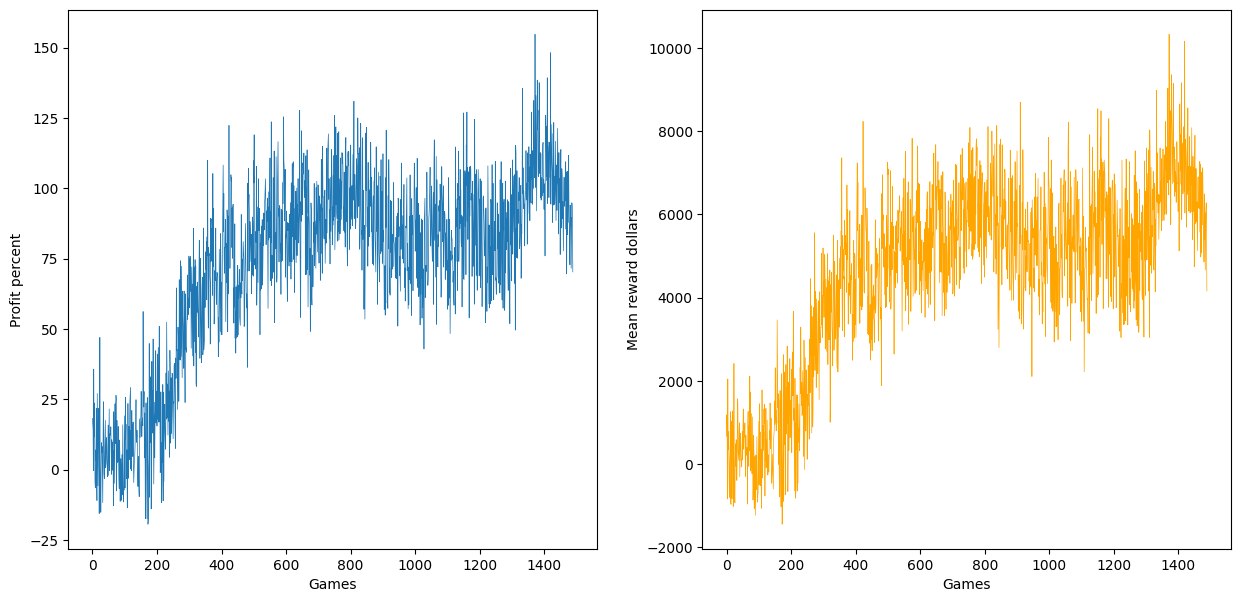

In [57]:
fig, ax=plt.subplots(1,2, figsize=(15,7))
ax[0].plot(np.array(plot_profit)*100,  linewidth=0.5) #profit as a percentage
ax[0].set(xlabel='Games', ylabel='Profit percent')

ax[1].plot(plot_reward, linewidth=0.5, color='orange')
ax[1].set(xlabel='Games', ylabel='Mean reward dollars')

# ax[2].plot(plot_loss, linewidth=0.5, color='royalblue')
# ax[2].set(xlabel='Games', ylabel='Smooth L1 Loss')

In [ ]:
# import seaborn as sns
# import seaborn.timeseries

## **Visualize Actions**, **Positive: BUY, Negative: SELL**

<ipython-input-72-1e0064b38b0d>:17: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)


Text(0, 60, 'Game1400')

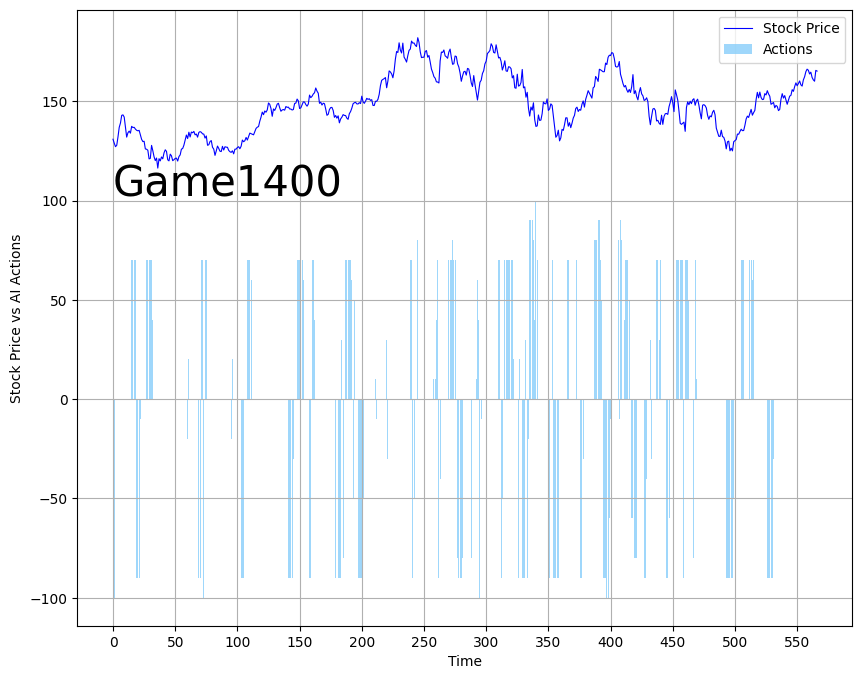

In [72]:
plt.figure(figsize=(10,8))
game_i=1400 #input this to see actions in game i
game_length=stock_price.shape[0]-CONTEXT  #length of stock price
# np.pad(stock_price, (CONTEXT//2,CONTEXT//2),'constant', constant_values=(stock_price[0], stock_price[-1]))
#visualize actions
# plt.plot(np.array(actions[game_length*game_i:game_length*(game_i+1)])/50,linewidth=1, color='tomato', label='Actions')
plt.bar(x=np.arange(0,game_length), height=np.array(actions[game_length*game_i:game_length*(game_i+1)])/50, label='Actions', color='lightskyblue', alpha=0.8)
#plot stock price
plt.plot(stock_price, linewidth=0.8, color="blue", label='Stock Price')

#plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xticks(np.arange(0,stock_price.shape[0],50))
plt.ylabel("Stock Price vs AI Actions")
plt.xlabel("Time")
plt.grid(True)
plt.legend()
plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)